In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D 
from dataclasses import dataclass
from sklearn.model_selection import train_test_split
#from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
from bokeh.plotting import figure, show
import plotly.graph_objects as go
from scipy import stats
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.optimize import Bounds
from scipy import optimize
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
import seaborn as sns
from sklearn import svm
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras import Model


In [2]:
df= pd.read_csv("./bank+marketing/bank-additional/bank-additional/bank-additional-full.csv",delimiter=";")
df.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994          -36.4      4.857       5191.0  no  
1          93.994          -36.4      4.857       5191.0  no  
2          93.994          -36.4      4.857       5191.0  no  
3          93.994          -36.4      4.857       5191.0  no  
4          93.994          -36.4      4.857       5191.0  no  

[5 rows x 21 columns]

### Important note on `Duration` column:  this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

In [3]:
df.drop('duration',axis = 1,inplace=True)

# EDA

In [4]:
df.describe()

age      campaign         pdays      previous  emp.var.rate  \
count  41188.00000  41188.000000  41188.000000  41188.000000  41188.000000   
mean      40.02406      2.567593    962.475454      0.172963      0.081886   
std       10.42125      2.770014    186.910907      0.494901      1.570960   
min       17.00000      1.000000      0.000000      0.000000     -3.400000   
25%       32.00000      1.000000    999.000000      0.000000     -1.800000   
50%       38.00000      2.000000    999.000000      0.000000      1.100000   
75%       47.00000      3.000000    999.000000      0.000000      1.400000   
max       98.00000     56.000000    999.000000      7.000000      1.400000   

       cons.price.idx  cons.conf.idx     euribor3m   nr.employed  
count    41188.000000   41188.000000  41188.000000  41188.000000  
mean        93.575664     -40.502600      3.621291   5167.035911  
std          0.578840       4.628198      1.734447     72.251528  
min         92.201000     -50.800000      0.634000   4963.600000  
25%         93.075000     -42.700000      1.344000   5099.100000  
50%         93.749000     -41.800000      4.857000   5191.000000  
75%         93.994000     -36.400000      4.961000   5228.100000  
max         94.767000     -26.900000      5.045000   5228.100000

## Visualization on categorical columns

In [5]:
cat_var = list(df.select_dtypes(include='O').keys())
cat_var.remove('y')
for col in cat_var:
    categories = list(df[col].value_counts().index) #list(df['y'].unique())
    Yes = list(df[df['y']=='yes'][col].value_counts().values)
    No = list(df[df['y']=='no'][col].value_counts().values)
    trace1 = go.Bar(
        x=categories,
        y=Yes,
        name='Yes',
        offsetgroup=0
    )

    trace2 = go.Bar(
        x=categories,
        y=No,
        name='No',
        offsetgroup=1
    )

    layout = go.Layout(
        title= "Distribution",
        xaxis=dict(title= col),
        yaxis=dict(title='Number of term deposite'),
        barmode='group',
        legend=dict(x=0, y=1)
    )
    fig = go.Figure(data=[trace1, trace2], layout=layout)
    fig.show()
    print(df[col].unique())


['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']


['married' 'single' 'divorced' 'unknown']


['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']


['no' 'unknown' 'yes']


['no' 'yes' 'unknown']


['no' 'yes' 'unknown']


['telephone' 'cellular']


['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']


['mon' 'tue' 'wed' 'thu' 'fri']


['nonexistent' 'failure' 'success']


## Analysis on Numerical columns

In [6]:
def fun(df,col):
    df_1 = pd.pivot_table(df,index = col,columns='y',aggfunc='count',fill_value=0,)['contact']
    #df_1
    df_1.reset_index(inplace=True)
    df_1 = df_1[df_1['yes']!=0]
    df_1['Precentage of conversion'] = (df_1['yes']/(df_1['no']+df_1['yes'])*100)
    df_1 = df_1[df_1['yes']>df_1['yes'].mean()]
    min_ = df_1[col].min()
    max_ = df_1[col].max()
    return df_1,min_,max_

In [7]:
def fun_cmp(df,df_1):
    Normal = (df[df['y']=='yes']['y'].count()/df['y'].count())*100
    After = (df_1.sum()[2]/(df_1.sum()[1]+df_1.sum()[2]))*100
    return Normal,After

In [8]:
#l1 = ['age','campaign','duration','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']
l1 = list(df.select_dtypes(include='number').keys())
#emp.var.rate	cons.price.idx	cons.conf.idx	euribor3m	nr.employed
Normal = 0
After = 0
min_ =0
max_ = 0
for i in l1:
    df_2,min_,max_ = fun(df,i)
    print("Summary of {} column".format(i))
    print(df_2.to_markdown())
    print("\n")
    Normal,After = fun_cmp(df,df_2)
    print("Generic: {}".format(Normal))
    print("After Modified: {}".format(After))
    print("Minimum value: {}".format(min_))
    print("Maximum Value: {}".format(max_))
    print("\n")

Summary of age column
|    |   age |   no |   yes |   Precentage of conversion |
|---:|------:|-----:|------:|---------------------------:|
|  7 |    24 |  377 |    86 |                   18.5745  |
|  8 |    25 |  505 |    93 |                   15.5518  |
|  9 |    26 |  576 |   122 |                   17.4785  |
| 10 |    27 |  737 |   114 |                   13.396   |
| 11 |    28 |  850 |   151 |                   15.0849  |
| 12 |    29 | 1267 |   186 |                   12.8011  |
| 13 |    30 | 1512 |   202 |                   11.7853  |
| 14 |    31 | 1727 |   220 |                   11.2994  |
| 15 |    32 | 1662 |   184 |                    9.9675  |
| 16 |    33 | 1623 |   210 |                   11.4566  |
| 17 |    34 | 1561 |   184 |                   10.5444  |
| 18 |    35 | 1592 |   167 |                    9.49403 |
| 19 |    36 | 1626 |   154 |                    8.65169 |
| 20 |    37 | 1338 |   137 |                    9.28814 |
| 21 |    38 | 1264 |   143 |     

Summary of nr.employed column
|    |   nr.employed |    no |   yes |   Precentage of conversion |
|---:|--------------:|------:|------:|---------------------------:|
|  3 |        5017.5 |   617 |   454 |                   42.3903  |
|  5 |        5076.2 |  1069 |   594 |                   35.7186  |
|  6 |        5099.1 |  7442 |  1092 |                   12.7959  |
| 10 |        5228.1 | 15368 |   866 |                    5.33448 |


Generic: 11.265417111780131
After Modified: 10.930114173514653
Minimum value: 5017.5
Maximum Value: 5228.1




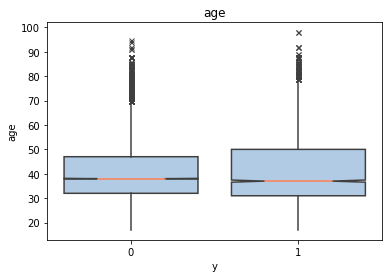

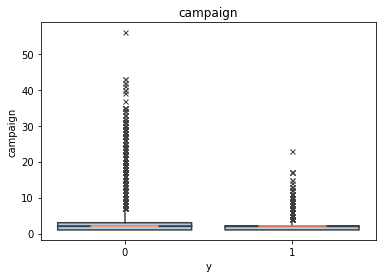

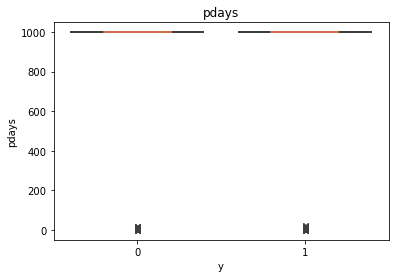

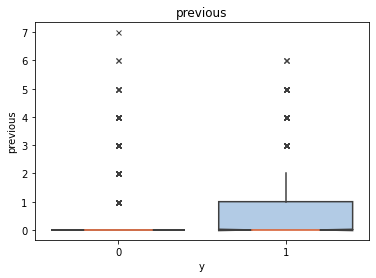

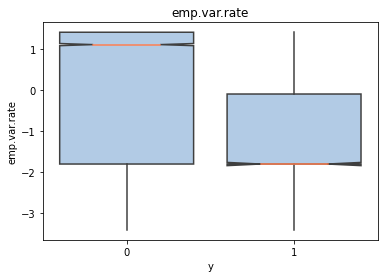

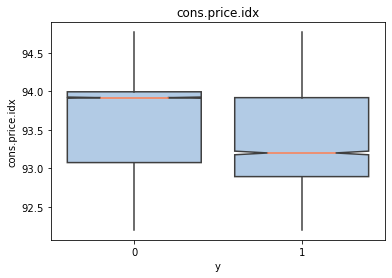

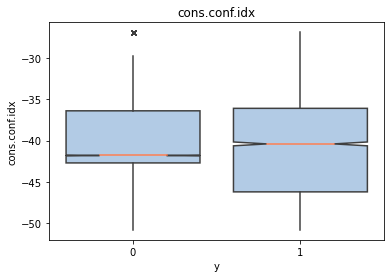

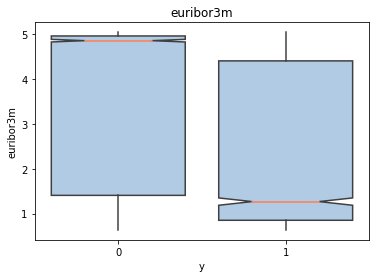

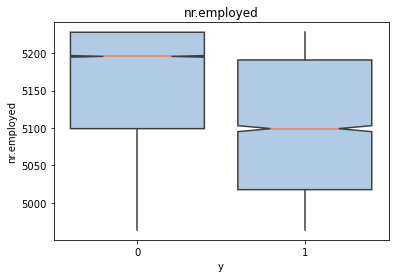

In [157]:
'''#l1 = ['age','campaign','duration','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed','Deposit Demand']
for i in l1:
    plt.boxplot(df[i])
    plt.title(i)
    plt.show()
'''
#l1 = ['age','campaign','duration','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed','Deposit Demand']
for i in l1:
    
    sns.boxplot(
    data=df, y= i , x="y",
    notch=True, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"},
    orient="v",
    )
    plt.title(i)
    plt.show()

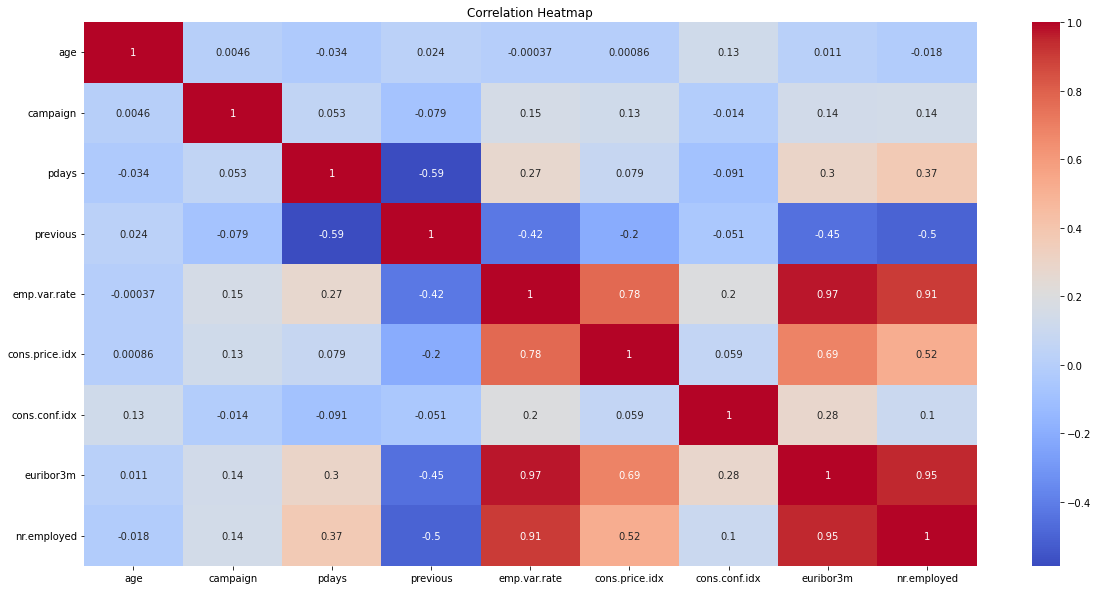

In [10]:
correlation_matrix = df[l1].corr()
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Data Pre-processing

In [11]:
df.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  campaign  pdays  previous     poutcome  emp.var.rate  \
0   may         mon         1    999         0  nonexistent           1.1   
1   may         mon         1    999         0  nonexistent           1.1   
2   may         mon         1    999         0  nonexistent           1.1   
3   may         mon         1    999         0  nonexistent           1.1   
4   may         mon         1    999         0  nonexistent           1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994          -36.4      4.857       5191.0  no  
1          93.994          -36.4      4.857       5191.0  no  
2          93.994          -36.4      4.857       5191.0  no  
3          93.994          -36.4      4.857       5191.0  no  
4          93.994          -36.4      4.857       5191.0  no

In [12]:
df_num = df.select_dtypes(include='number')

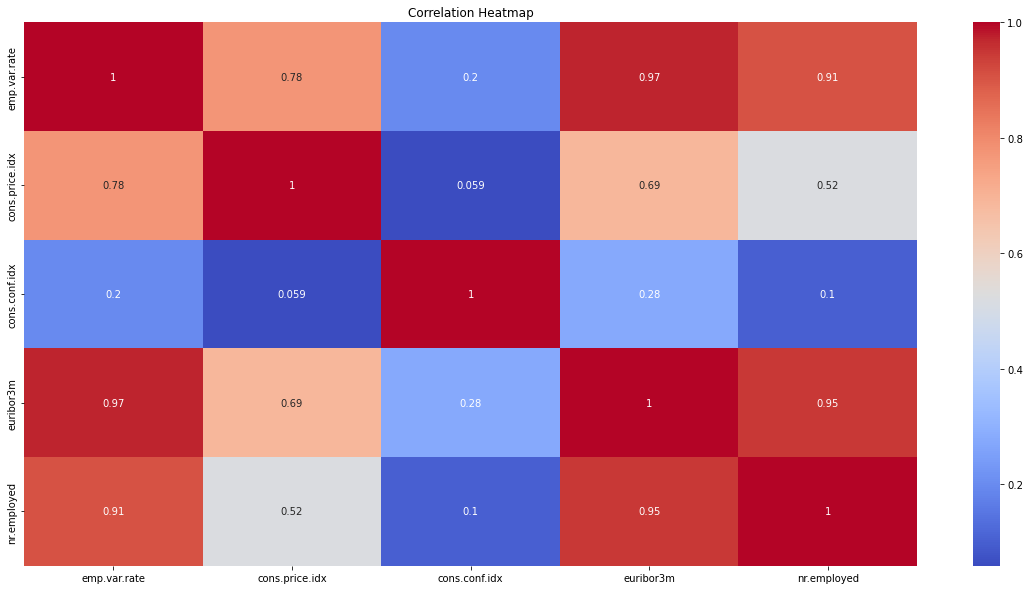

In [13]:
correlation_matrix = df_num[['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']].corr()
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### Analysis from above Heat Map
- cons.conf.idx column is not correlated, we have to apply PCA on rest of the above columns 
- or We can drop every column keeping one of highly correlated columns

In [14]:

#df_num.drop('age', axis = 1,inplace = True)

In [15]:
df['y'] = pd.get_dummies(df['y'],drop_first=True)

In [16]:
df_cat = df.select_dtypes(include='O')
one_hot_encoded_data = pd.get_dummies(df_cat, columns = list(df_cat.columns),drop_first=True)
one_hot_encoded_data['y']= df['y']

In [17]:
df_OHE = pd.concat([df_num,one_hot_encoded_data], axis=1)
df_OHE.shape

(41188, 53)

In [18]:
df_OHE.columns

Index(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'marital_unknown',
       'education_basic.6y', 'education_basic.9y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_unknown',
       'default_yes', 'housing_unknown', 'housing_yes', 'loan_unknown',
       'loan_yes', 'contact_telephone', 'month_aug', 'month_dec', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'poutcome_nonexistent', 'poutcome_success', 'y'

In [19]:
class kmeans_clustering:
    
    def __init__(self, data,columns, k, max_iterations=100,epsilon=0.000000000001):
        self.data = data
        self.k = k
        self.max_iterations = max_iterations
        self.epsilon = epsilon
        self.columns = columns
        
    def update_centroids(self,data, labels, k):
        centroids = np.zeros((k, self.data.shape[1]))
        for i in range(k):
            cluster_points = self.data[labels == i]
            if len(cluster_points) > 0:
                centroids[i] = np.mean(cluster_points, axis=0)
        return centroids
        
    def assign_labels(self,data, centroids):
        labels = np.zeros(len(self.data))
        for i, point in enumerate(self.data):
            distances = np.linalg.norm(point - centroids, axis=1)
            labels[i] = np.argmin(distances)
        return labels
    
    def fit(self):
        centroids = self.data[np.random.choice(range(len(self.data)), self.k, replace=False)]
        labels = self.assign_labels(self.data, centroids)
        '''for _ in range(self.max_iterations):
            # Assign data points to the nearest centroid
            labels = self.assign_labels(self.data, centroids)

            # Update centroids based on the mean of the assigned data points
            new_centroids = self.update_centroids(self.data, labels, k)
            

            # Check if the centroids have converged
            if np.all(centroids == new_centroids):
                break

            centroids = new_centroids'''
        df1 = pd.DataFrame(self.data,columns = self.columns)
        df_labels = pd.DataFrame(labels,columns=['Cluster Number'])
        new_data = pd.concat([df1, df_labels], axis=1)
        self.gradient(self.data, centroids)
            

        return new_data, centroids
    
    def gradient(self,data,centriods):
        errors = []
        old_centroids = [np.zeros((k, self.data.shape[1]))]
        prev_distance = float('inf')
        labels = self.assign_labels(self.data, centriods)
        for i in tqdm(range(self.max_iterations),colour = 'red'):
            new_centroids = self.update_centroids(self.data,labels, k)
            curr_distance = np.linalg.norm(old_centroids - new_centroids)
            old_centroids = new_centroids
            #self.W = self.W - self.learning_rate * self.cost_derivative(X,y)
            #curr_error = self.cost_function(X,y)
            
            if abs(prev_distance - curr_distance) < self.epsilon:
                print("Convergence condition satisfied")
                print("new_centroids")
                print(new_centroids)
                break
            prev_distance = curr_distance
            errors.append(curr_distance)
        #self.plot_cost(errors)
        

In [20]:
data = np.array(df_num)
k = 3
columns=list(df_num.columns)
model = kmeans_clustering(data,columns,k)
df_1,centriods = model.fit()
lable_centriod = {}
for i in range(centriods.shape[0]):
    lable_centriod[i] = centriods[i].tolist()
df_1

  2%|█▌                                                                               | 2/100 [00:00<00:00, 154.22it/s]

Convergence condition satisfied
new_centroids
[[ 4.00274116e+01  3.14266355e+00  9.99000000e+02  0.00000000e+00
   1.40000000e+00  9.39142811e+01 -4.03535912e+01  4.95454361e+00
   5.22810000e+03]
 [ 3.99035368e+01  2.21745808e+00  9.99000000e+02  1.96595418e-01
  -6.90264090e-01  9.33562066e+01 -4.07454968e+01  2.86820905e+00
   5.13364879e+03]
 [ 4.18528053e+01  1.82244224e+00  6.01452145e+00  1.66072607e+00
  -2.09623762e+00  9.33425069e+01 -3.83413861e+01  9.85949175e-01
   5.02924469e+03]]


age  campaign  pdays  previous  emp.var.rate  cons.price.idx  \
0      56.0       1.0  999.0       0.0           1.1          93.994   
1      57.0       1.0  999.0       0.0           1.1          93.994   
2      37.0       1.0  999.0       0.0           1.1          93.994   
3      40.0       1.0  999.0       0.0           1.1          93.994   
4      56.0       1.0  999.0       0.0           1.1          93.994   
...     ...       ...    ...       ...           ...             ...   
41183  73.0       1.0  999.0       0.0          -1.1          94.767   
41184  46.0       1.0  999.0       0.0          -1.1          94.767   
41185  56.0       2.0  999.0       0.0          -1.1          94.767   
41186  44.0       1.0  999.0       0.0          -1.1          94.767   
41187  74.0       3.0  999.0       1.0          -1.1          94.767   

       cons.conf.idx  euribor3m  nr.employed  Cluster Number  
0              -36.4      4.857       5191.0             1.0  
1              -36.4      4.857       5191.0             1.0  
2              -36.4      4.857       5191.0             1.0  
3              -36.4      4.857       5191.0             1.0  
4              -36.4      4.857       5191.0             1.0  
...              ...        ...          ...             ...  
41183          -50.8      1.028       4963.6             1.0  
41184          -50.8      1.028       4963.6             1.0  
41185          -50.8      1.028       4963.6             1.0  
41186          -50.8      1.028       4963.6             1.0  
41187          -50.8      1.028       4963.6             1.0  

[41188 rows x 10 columns]

In [21]:
df_1['Cluster Number'].value_counts()

1.0    23439
0.0    16234
2.0     1515
Name: Cluster Number, dtype: int64

In [22]:
df_1['y']=df['y']
df_1.head()

age  campaign  pdays  previous  emp.var.rate  cons.price.idx  \
0  56.0       1.0  999.0       0.0           1.1          93.994   
1  57.0       1.0  999.0       0.0           1.1          93.994   
2  37.0       1.0  999.0       0.0           1.1          93.994   
3  40.0       1.0  999.0       0.0           1.1          93.994   
4  56.0       1.0  999.0       0.0           1.1          93.994   

   cons.conf.idx  euribor3m  nr.employed  Cluster Number  y  
0          -36.4      4.857       5191.0             1.0  0  
1          -36.4      4.857       5191.0             1.0  0  
2          -36.4      4.857       5191.0             1.0  0  
3          -36.4      4.857       5191.0             1.0  0  
4          -36.4      4.857       5191.0             1.0  0

In [23]:
df_1['Cluster Number'].value_counts()
df_2 = pd.pivot_table(df_1,index = 'Cluster Number',columns='y',aggfunc='count',fill_value=0,)['age']
df_2.reset_index(inplace=True)
df_2
# 0- No
# 1- Yes

y  Cluster Number      0     1
0             0.0  15368   866
1             1.0  20632  2807
2             2.0    548   967

In [24]:
class PCA:
    
    def __init__(self, X):
        
        self.X = X
    
    def fit(self):
        
        self.mean = np.mean(self.X, axis = 0)
        self.X = self.X - self.mean
        
        cov_matrix = np.cov(self.X.T)
        e_values, e_vectors = np.linalg.eig(cov_matrix)
        
        sort_idx = np.argsort(e_values)[::-1]
        e_values   = e_values[sort_idx]
        e_vectors  = e_vectors[:, sort_idx]
        
        self.eigen_vectors = e_vectors
        self.eigen_values = e_values
    
    
    def transform(self, num_components):
        
        # decomposition
        components = self.eigen_vectors[:num_components]
        print("Variance Captured : ", np.sum(self.eigen_values[:num_components]) / np.sum(self.eigen_values))
        return np.matmul(self.X, components.T)

In [25]:
X = np.array(df_num[['emp.var.rate', 'cons.price.idx', 'euribor3m', 'nr.employed']])
pca = PCA(X)
pca.fit()
pca.eigen_values

array([5.22509273e+03, 8.76161215e-01, 8.49814113e-02, 4.06584467e-02])

In [26]:
pca.transform(1)

Variance Captured :  0.9998083078926981


array([[-16.92151355],
       [-16.92151355],
       [-16.92151355],
       ...,
       [145.5720887 ],
       [145.5720887 ],
       [145.5720887 ]])

In [27]:
df_OHE.drop(['emp.var.rate', 'cons.price.idx', 'euribor3m', 'nr.employed'],axis = 1,inplace=True)
df_OHE.shape

(41188, 49)

In [166]:
df_OHE.drop('y',axis = 1)

age  campaign  pdays  previous  cons.conf.idx  job_blue-collar  \
0       56         1    999         0          -36.4                0   
1       57         1    999         0          -36.4                0   
2       37         1    999         0          -36.4                0   
3       40         1    999         0          -36.4                0   
4       56         1    999         0          -36.4                0   
...    ...       ...    ...       ...            ...              ...   
41183   73         1    999         0          -50.8                0   
41184   46         1    999         0          -50.8                1   
41185   56         2    999         0          -50.8                0   
41186   44         1    999         0          -50.8                0   
41187   74         3    999         1          -50.8                0   

       job_entrepreneur  job_housemaid  job_management  job_retired  ...  \
0                     0              1               0            0  ...   
1                     0              0               0            0  ...   
2                     0              0               0            0  ...   
3                     0              0               0            0  ...   
4                     0              0               0            0  ...   
...                 ...            ...             ...          ...  ...   
41183                 0              0               0            1  ...   
41184                 0              0               0            0  ...   
41185                 0              0               0            1  ...   
41186                 0              0               0            0  ...   
41187                 0              0               0            1  ...   

       month_may  month_nov  month_oct  month_sep  day_of_week_mon  \
0              1          0          0          0                1   
1              1          0          0          0                1   
2              1          0          0          0                1   
3              1          0          0          0                1   
4              1          0          0          0                1   
...          ...        ...        ...        ...              ...   
41183          0          1          0          0                0   
41184          0          1          0          0                0   
41185          0          1          0          0                0   
41186          0          1          0          0                0   
41187          0          1          0          0                0   

       day_of_week_thu  day_of_week_tue  day_of_week_wed  \
0                    0                0                0   
1                    0                0                0   
2                    0                0                0   
3                    0                0                0   
4                    0                0                0   
...                ...              ...              ...   
41183                0                0                0   
41184                0                0                0   
41185                0                0                0   
41186                0                0                0   
41187                0                0                0   

       poutcome_nonexistent  poutcome_success  
0                         1                 0  
1                         1                 0  
2                         1                 0  
3                         1                 0  
4                         1                 0  
...                     ...               ...  
41183                     1                 0  
41184                     1                 0  
41185                     1                 0  
41186                     1                 0  
41187                     0                 0  

[41188 rows x 48 columns]

In [28]:
d = pd.DataFrame(pca.transform(1),columns=['PCA1'])
d.shape

Variance Captured :  0.9998083078926981


(41188, 1)

In [167]:
df_AfterPCA = pd.concat([df_OHE,d],axis = 1)
df_AfterPCA.shape

(41188, 50)

In [171]:
#df_num = df_num.drop(['y'],axis = 1)
df_BeforPCA = pd.concat([df_num,one_hot_encoded_data],axis = 1)
df_BeforPCA = df_BeforPCA.drop(['cons.price.idx', 'euribor3m', 'nr.employed'],axis = 1)

In [31]:
df_BeforPCA.shape

(41188, 50)

## Random Under-Sampling of majority class

In [32]:
X_RUS = df_BeforPCA.drop('y',axis = 1)
y_RUS = df_BeforPCA['y']

In [33]:
rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable
x_rus, y_rus = rus.fit_resample(X_RUS, y_RUS)
print('original dataset shape:', Counter(y_RUS))
print('Resample dataset shape', Counter(y_rus))

original dataset shape: Counter({0: 36548, 1: 4640})
Resample dataset shape Counter({0: 4640, 1: 4640})


In [34]:
X_ARUS = df_AfterPCA.drop('y',axis = 1)
y_ARUS = df_AfterPCA['y']

In [35]:
rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable
x_arus, y_arus = rus.fit_resample(X_ARUS, y_ARUS)
print('original dataset shape:', Counter(y_RUS))
print('Resample dataset shape', Counter(y_rus))

original dataset shape: Counter({0: 36548, 1: 4640})
Resample dataset shape Counter({0: 4640, 1: 4640})


In [36]:
x_rus.shape

(9280, 49)

In [37]:
from sklearn.manifold import TSNE


X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity= 10).fit_transform(x_arus)

X_embedded.shape

(9280, 2)

In [38]:
import plotly.express as px
fig = px.scatter(X_embedded, x=X_embedded.T[0], y=X_embedded.T[1],text=y_arus, color= y_arus)

fig.update_traces(textposition="bottom center")

fig.update_layout(
    height=800,
    title_text='Lower dimension distribution'
)
fig.show()

## Synthetic Minority Oversampling Technique (SMOTE)

In [39]:
smote = SMOTE()
X_SMOTE = df_num
y_SMOTE = df['y']
# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(X_SMOTE, y_SMOTE)

print('Original dataset shape', Counter(y_SMOTE))
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({0: 36548, 1: 4640})
Resample dataset shape Counter({0: 36548, 1: 36548})


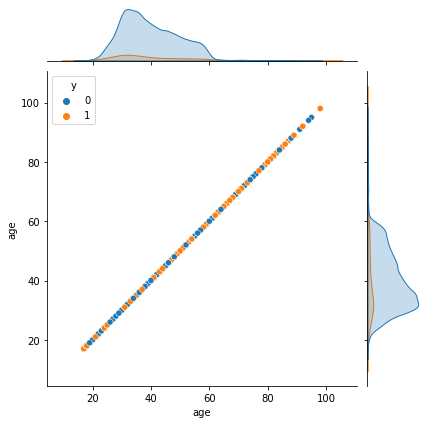

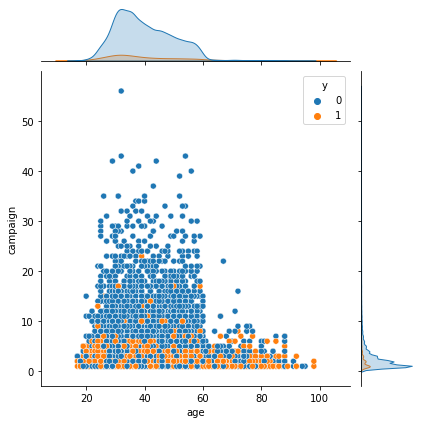

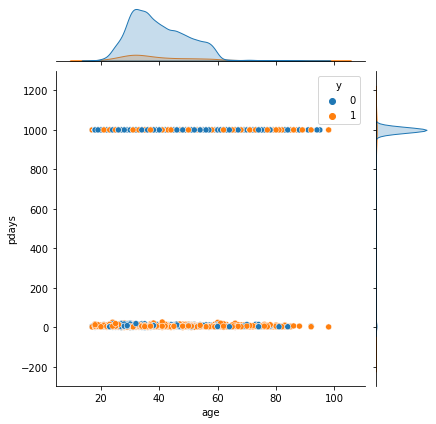

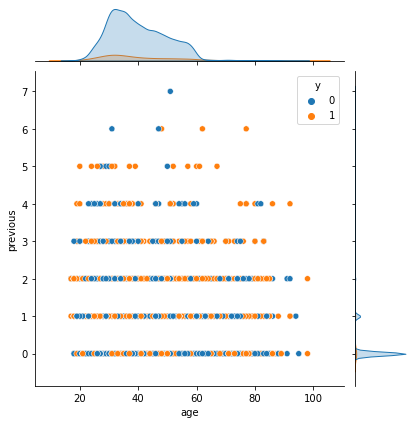

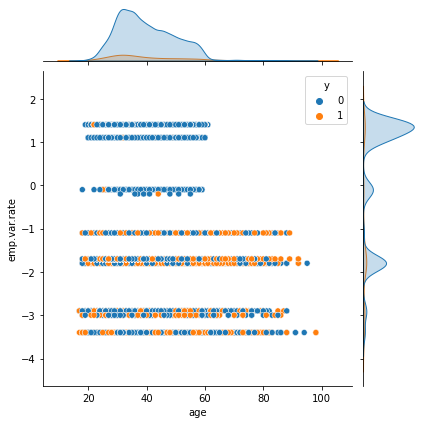

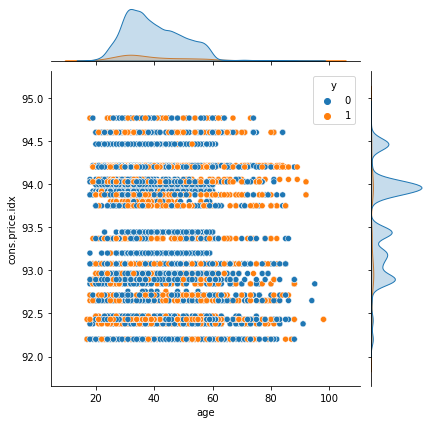

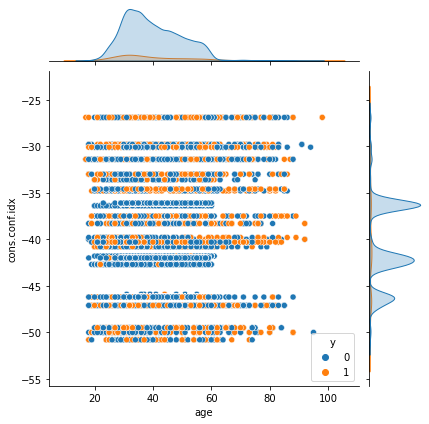

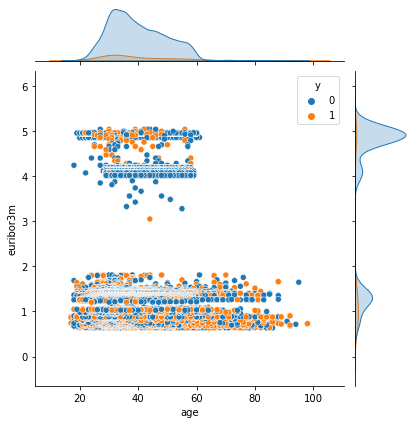

In [40]:
imp_col = df_num.columns
for i in range(len(imp_col)-1):
    sns.jointplot(x=df[imp_col[0]], y=df[imp_col[i]],hue='y', data=df)

## Logistic Regression

In [41]:
class PreprocessingClass:
    def __init__(self, data, target_var, test_split_ratio = 0.2, stratify = False) -> None:

        self.data = data
        self.target_var = target_var
        self.test_split_ratio = test_split_ratio
        self.stratify = stratify

    def train_test_split_data(self, X, y):
        if self.stratify:
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X ,y ,test_size= self.test_split_ratio, 
                                                                                    stratify= y, random_state= 42)
        else:
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X ,y ,
                                                                                    test_size= self.test_split_ratio, random_state= 42)
    
    def train_normalize(self, X):
        mean = X.mean()
        std = X.std()
        X = (X - mean)/std
        return X, mean, std
    
    def test_normalize(self, X, mean, std):
        X = (X - mean)/std
        return X
    

    def fit(self):
        self.X_data = self.data.drop([self.target_var], axis = 1)
        self.y_data = self.data[self.target_var]

        self.train_test_split_data(self.X_data, self.y_data)
        
        self.X_train, mean, std = self.train_normalize(self.X_train)
        self.X_test = self.test_normalize(self.X_test, mean, std)

In [42]:
class LogisticRegressionClass:
    def __init__(self, data, target, learning_rate = 0.00005, epsilon = 1e-8, 
                 max_iterations= 1000, reg_type = None, reg_lambda = 0,method = 'gd', 
                 fit_intercept = True, print_log = False, remove_index = []) -> None:
         
        """
        @data: pandas dataframe or np.array, Passed data,

        @does: ,
        @return: ,
        """
        self.fit_intercept = fit_intercept
        self.remove_index = remove_index
        
        self.X = np.insert(data.to_numpy(),0,1,axis=1) if self.fit_intercept == True else data.to_numpy()
        self.y = target.to_numpy()
        
        self.reg_type = reg_type
        self.reg_lambda = 0 if self.reg_type == None else reg_lambda
        
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.max_iterations = max_iterations
        self.weight = None
        self.method = method
        
        self.print_log = print_log
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def multiply(self, X):
        return np.matmul(X, self.weight)
    
    def predict(self, X, cutoff = 0.5):
        sol = self.sigmoid(np.matmul(X, self.weight))
        return (sol > cutoff).astype(int)

    def loss_functions(self, X, y):
        y_hat = self.multiply(X)
        p = self.sigmoid(y_hat)
        #return -1 - np.dot(y, y_hat) + (self.sigmoid(y_hat)).sum()
        return -(np.matmul(y, np.log(p)) + np.matmul(1-y, np.log(1-p)))/len(y)


    def derivative_loss_functions(self, X, y):
        y_hat = self.multiply(X)
        return np.matmul(X.T, (self.sigmoid(y_hat) - y))
        
        
    def reg_functions(self):
        if self.reg_type == "L2":
            return ((self.weight) ** 2).sum()
        
        if self.reg_type == "L1":
            return (abs(self.weight)).sum()
        else:
            return 0

    def derivative_reg_functions(self):

        if self.reg_type == "L2":
            return 2* self.weight
        
        if self.reg_type == "L1":
            return np.sign(self.weight)
        
        else:
            return 0
        
    def gradient_descent(self, X, y):
        costs = []
        iterations = []
        previous_cost = math.inf
        for iter in tqdm(range(1, self.max_iterations)):
            
            
            if self.method == "sgd":
                X_train, X_test, y_train, y_test = train_test_split(X ,y , train_size=0.2)
            
            else:
                X_train, y_train = X, y
            
            
            step = self.learning_rate * (self.derivative_loss_functions(X_train, y_train) + self.reg_lambda * self.derivative_reg_functions())
            
            self.weight = self.weight - step
            
            
            ### RMSE cost
            
            current_cost = ((self.loss_functions(X_train, y_train) + self.reg_lambda * self.reg_functions())/X_train.shape[0]) ** 0.5
            #current_cost = (self.loss_functions(X_train, y_train) + self.reg_lambda * self.reg_functions())
            
            #print(current_cost)
            costs.append(current_cost)
            iterations.append(iter)
            
            
            if self.print_log:
                print("Step : " + str(iter) + ": ","\n")
                print("\t" + "change ",step, "\n")
                print("current_weights: ", self.weight)
                print("current_cost: ", current_cost)
                print("current_cost_change: ", abs(current_cost - previous_cost), "\n")
            
            if abs(current_cost - previous_cost) < self.epsilon:
                print("Done")
                break
            previous_cost = current_cost
        self.fig_plot(x_data = iterations, y_data = costs)
    
    def evaluation_metrics(self, X = None, y = None, mode = "train"):
        
        if mode == "train":
            print("Training metrics")
            y_pred = self.predict(self.X)
            self.confusion_matrix(self.y, y_pred)
        
        elif (mode == 'test') and (X is not None) and (y is not None):
            print("Testing metrics")
            
            X = np.insert(X.to_numpy(),0,1,axis=1) if self.fit_intercept == True else X.to_numpy()
            y = y.to_numpy()
        
            y_pred = self.predict(X)
            self.confusion_matrix(y, y_pred)

    def confusion_matrix(self, y, y_pred):
        
        a1_p1 = np.sum((y & y_pred))
        a1_p0 = y.sum() - a1_p1

        a0_p1 = y_pred.sum() - a1_p1
        a0_p0 = len(y) - y.sum() - a0_p1

        matrix = np.array([[a0_p0, a0_p1], [a1_p0, a1_p1]])

        plt.figure(figsize=(10,6))
        sns.heatmap(matrix, annot=True, cmap='Blues', fmt='g')
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        
        ## Metrics
        Accuracy = (a1_p1 + a0_p0)/ len(y)
        Error_rate = 1 - Accuracy
        
        Sensitivity = a1_p1/y.sum()
        False_Negative_Rate = 1 - Sensitivity
        
        Specificity = a0_p0/(len(y) - y.sum())
        
        F1_score = 2 * Sensitivity * Specificity/(Sensitivity + Specificity)
        
        metrics_df = pd.DataFrame({ "Metrics": ["Accuracy", "Error rate", "Sensitivity/Recall/True Positive Rate", 
                                                "False Negative Rate", "Specificity/True Negative Rate", "F1 score"
                                               ],
                                   "Values": [Accuracy, Error_rate, Sensitivity, False_Negative_Rate,
                                             Specificity, F1_score
                                             ]
        
        })
        metrics_df.set_index("Metrics", inplace = True)
        display(metrics_df)
        
    def fig_plot(self, x_data, y_data):
        sns.lineplot(x= x_data, y= y_data)
        plt.show()

    def fit(self):
        if len(self.remove_index) != 0:
            self.X = np.delete(self.X, np.array(self.remove_index)-1, axis=0)
            self.y = np.delete(self.y, np.array(self.remove_index)-1, axis=0)
        
        #self.weight = np.random.randn(self.X.shape[1])
        self.weight = np.zeros(self.X.shape[1])
        self.gradient_descent(self.X, self.y)
        print("Gradient descent used")
        print(self.weight, "\n")
        
        self.y_pred = self.predict(self.X)
        
        self.evaluation_metrics(self.y, self.y_pred)

In [43]:
df_num['y']=df['y']
df_num.head()

age  campaign  pdays  previous  emp.var.rate  cons.price.idx  \
0   56         1    999         0           1.1          93.994   
1   57         1    999         0           1.1          93.994   
2   37         1    999         0           1.1          93.994   
3   40         1    999         0           1.1          93.994   
4   56         1    999         0           1.1          93.994   

   cons.conf.idx  euribor3m  nr.employed  y  
0          -36.4      4.857       5191.0  0  
1          -36.4      4.857       5191.0  0  
2          -36.4      4.857       5191.0  0  
3          -36.4      4.857       5191.0  0  
4          -36.4      4.857       5191.0  0

## Before Applying PCA

In [44]:
df.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  campaign  pdays  previous     poutcome  emp.var.rate  \
0   may         mon         1    999         0  nonexistent           1.1   
1   may         mon         1    999         0  nonexistent           1.1   
2   may         mon         1    999         0  nonexistent           1.1   
3   may         mon         1    999         0  nonexistent           1.1   
4   may         mon         1    999         0  nonexistent           1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed  y  
0          93.994          -36.4      4.857       5191.0  0  
1          93.994          -36.4      4.857       5191.0  0  
2          93.994          -36.4      4.857       5191.0  0  
3          93.994          -36.4      4.857       5191.0  0  
4          93.994          -36.4      4.857       5191.0  0

In [45]:
df_num.columns

Index(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [46]:
one_hot_encoded_data.columns

Index(['job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'marital_unknown',
       'education_basic.6y', 'education_basic.9y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_unknown',
       'default_yes', 'housing_unknown', 'housing_yes', 'loan_unknown',
       'loan_yes', 'contact_telephone', 'month_aug', 'month_dec', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'poutcome_nonexistent', 'poutcome_success', 'y'],
      dtype='object')

In [162]:
df_BeforPCA = df_BeforPCA.drop('y',axis = 1)

In [172]:
X = df_BeforPCA.drop('y',axis =1)
y = df_BeforPCA['y']
X_Ptrain, X_Ptest, y_Ptrain, y_Ptest = train_test_split(X,y,test_size=0.3,random_state=24,stratify=y)
X_Ptrain.shape, X_Ptest.shape, y_Ptrain.shape, y_Ptest.shape

((28831, 49), (12357, 49), (28831,), (12357,))

CPU times: total: 0 ns
Wall time: 0 ns


  0%|                                                                                          | 0/999 [00:00<?, ?it/s]C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\4144562977.py:30: RuntimeWarning:

overflow encountered in exp

C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\4144562977.py:43: RuntimeWarning:

divide by zero encountered in log

C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\4144562977.py:43: RuntimeWarning:

invalid value encountered in matmul

100%|████████████████████████████████████████████████████████████████████████████████| 999/999 [00:10<00:00, 98.79it/s]


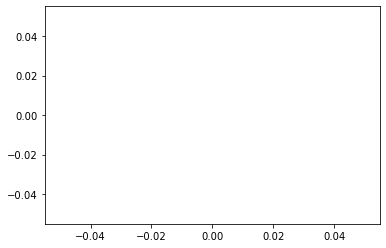

Gradient descent used
[ 3.44797838e-01  1.56554216e+01 -1.27921234e+01 -1.66865121e+02
  2.51944291e+00 -3.14650919e+01 -7.57369670e-01 -1.98228383e+00
 -1.82397941e-01 -1.35408527e-01 -3.68886691e-02  1.06582828e+00
  3.33916581e-02 -7.21135483e-01  1.03147207e+00 -4.20760952e-02
  1.56714223e-01 -2.88560517e-02 -1.64434731e+00  2.19605913e+00
 -1.11469889e-03 -3.33402988e-01 -9.63270707e-01 -4.27783400e-02
 -1.27025999e-03  7.21102692e-02  1.80078356e+00  2.37321511e-01
 -2.86018841e+00 -1.87000000e-03 -4.11225089e-02  6.75881012e-01
 -4.11225089e-02 -1.73455755e-01 -4.70639886e+00 -2.88414516e-01
  3.28940864e-01 -5.52271521e-01 -2.57903308e-02  1.33206164e+00
 -3.70585955e+00 -4.14669392e-01  1.15385695e+00  8.69524740e-01
 -6.85482340e-01  4.46657882e-01  1.30237418e-01  3.74406614e-01
 -1.17948083e+00  4.29595491e-01] 

Training metrics


C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\4144562977.py:30: RuntimeWarning:

overflow encountered in exp



Values
Metrics                                        
Accuracy                               0.891818
Error rate                             0.108182
Sensitivity/Recall/True Positive Rate  0.081589
False Negative Rate                    0.918411
Specificity/True Negative Rate         0.994684
F1 score                               0.150807

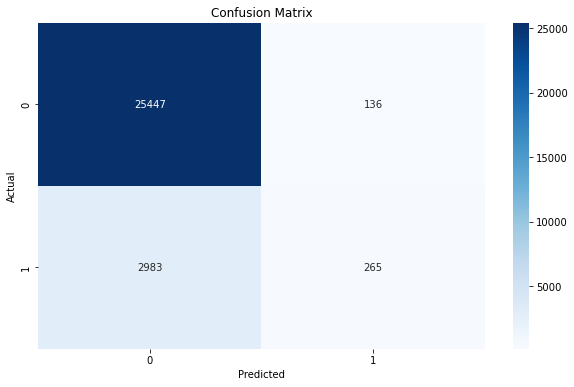

In [173]:
%time
log_beforePCA = LogisticRegressionClass(data = X_Ptrain,target = y_Ptrain,learning_rate = 1e-5, epsilon = 1e-5, max_iterations= 1000)
log_beforePCA.fit()

Testing metrics


C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\4144562977.py:30: RuntimeWarning:

overflow encountered in exp



Values
Metrics                                        
Accuracy                               0.893421
Error rate                             0.106579
Sensitivity/Recall/True Positive Rate  0.106322
False Negative Rate                    0.893678
Specificity/True Negative Rate         0.993342
F1 score                               0.192084

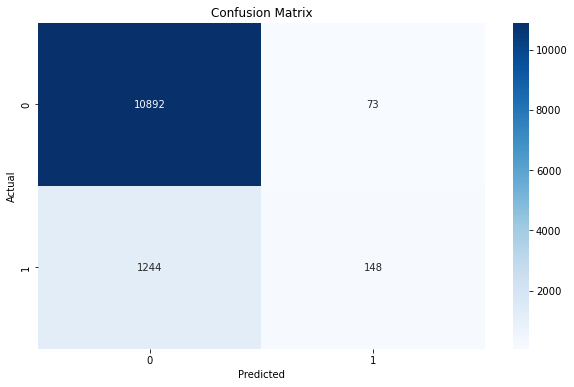

In [174]:
log_beforePCA.evaluation_metrics(X_Ptest,y_Ptest,mode = 'test')

In [175]:
X = df_AfterPCA.drop('y',axis =1)
y = df_AfterPCA['y']
X_Ptrain, X_Ptest, y_Ptrain, y_Ptest = train_test_split(X,y,test_size=0.3,random_state=24,stratify=y)
X_Ptrain.shape, X_Ptest.shape, y_Ptrain.shape, y_Ptest.shape

((28831, 49), (12357, 49), (28831,), (12357,))

  0%|                                                                                          | 0/999 [00:00<?, ?it/s]C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\4144562977.py:30: RuntimeWarning:

overflow encountered in exp

C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\4144562977.py:43: RuntimeWarning:

divide by zero encountered in log

C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\4144562977.py:43: RuntimeWarning:

invalid value encountered in matmul

100%|████████████████████████████████████████████████████████████████████████████████| 999/999 [00:10<00:00, 94.06it/s]


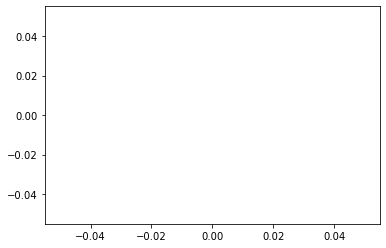

C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\4144562977.py:30: RuntimeWarning:

overflow encountered in exp



Gradient descent used
[-2.24326717e+00 -6.53702502e+01 -1.14162653e+01  1.58416380e+01
 -4.83903545e+00  9.49265321e+01 -1.79816193e+00 -1.11749387e-01
 -1.06516477e-01 -1.47939477e-01  6.87732857e-01  2.32396831e-02
 -7.86547885e-01  2.03398372e-01 -2.23786036e-01 -1.37705227e-02
 -3.38704336e-02 -1.94982721e+00 -2.49263556e-02 -6.14782970e-03
 -2.78345284e-01 -9.77109302e-01 -8.76156930e-01 -2.64172419e-04
 -2.36633388e-01  6.04993955e-01 -5.48924805e-02 -1.70080600e+00
 -9.50000000e-04 -1.11660233e-01 -9.61159294e-01 -1.11660233e-01
 -5.21101146e-01 -3.51948460e+00  3.58700828e-01  8.47743365e-02
  9.65211050e-01  6.53303151e-01  7.85121245e-01 -5.46003373e+00
 -5.75481741e-01  2.24132478e-01 -9.47062372e-03 -1.28826129e+00
 -3.70917346e-02 -3.70761192e-01  1.35797567e-02  6.46376673e-01
 -1.85690211e+00  9.79507840e+01] 

Training metrics


Values
Metrics                                        
Accuracy                               0.114148
Error rate                             0.885852
Sensitivity/Recall/True Positive Rate  0.971367
False Negative Rate                    0.028633
Specificity/True Negative Rate         0.005316
F1 score                               0.010574

CPU times: total: 23 s
Wall time: 10.8 s


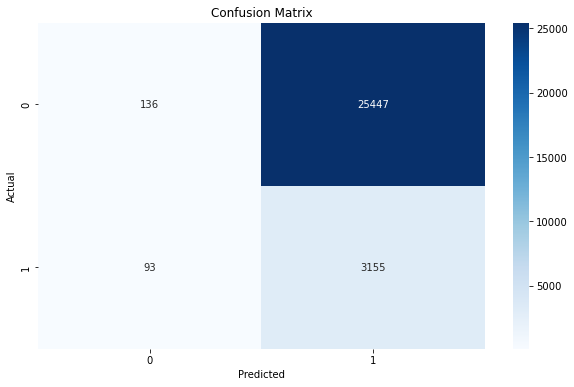

In [176]:
%%time
log_afterPCA = LogisticRegressionClass(data = X_Ptrain,target = y_Ptrain,learning_rate = 1e-5, epsilon = 1e-5, max_iterations= 1000)
log_afterPCA.fit()

Testing metrics


C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\4144562977.py:30: RuntimeWarning:

overflow encountered in exp



Values
Metrics                                        
Accuracy                               0.114348
Error rate                             0.885652
Sensitivity/Recall/True Positive Rate  0.967672
False Negative Rate                    0.032328
Specificity/True Negative Rate         0.006019
F1 score                               0.011964

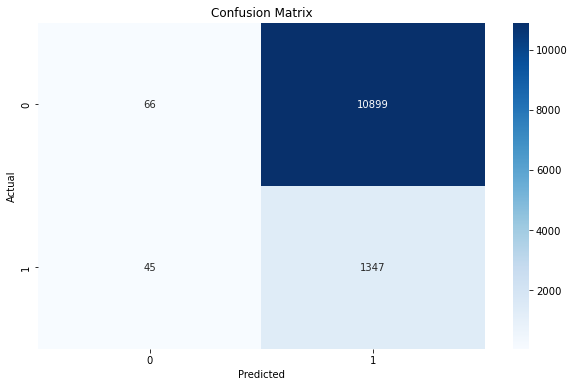

In [177]:
log_afterPCA.evaluation_metrics(X_Ptest,y_Ptest,mode = 'test')

In [56]:
x_rus.columns

Index(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.conf.idx',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'marital_unknown',
       'education_basic.6y', 'education_basic.9y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_unknown',
       'default_yes', 'housing_unknown', 'housing_yes', 'loan_unknown',
       'loan_yes', 'contact_telephone', 'month_aug', 'month_dec', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'poutcome_nonexistent', 'poutcome_success'],
      dtype='object')

CPU times: total: 0 ns
Wall time: 0 ns


  0%|                                                                                          | 0/999 [00:00<?, ?it/s]C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\4144562977.py:30: RuntimeWarning:

overflow encountered in exp

C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\4144562977.py:43: RuntimeWarning:

divide by zero encountered in log

C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\4144562977.py:43: RuntimeWarning:

invalid value encountered in matmul

100%|███████████████████████████████████████████████████████████████████████████████| 999/999 [00:03<00:00, 291.64it/s]


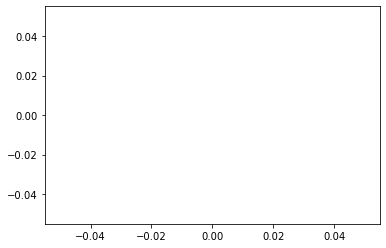

C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\4144562977.py:30: RuntimeWarning:

overflow encountered in exp



Gradient descent used
[ 1.22061998e-01  9.12052561e+00 -9.94583002e+00 -2.22341318e+01
  1.56233676e+00 -2.59843567e+01  1.08651095e+00 -1.46948914e+00
 -1.56978300e-01 -1.44551664e-01  5.70400557e-02  9.33109683e-01
 -7.21764721e-02 -4.85326472e-01  8.31905984e-01 -9.32829702e-02
  4.89087486e-03 -2.57036075e-02 -1.50724456e+00  1.85076768e+00
  7.27208249e-03 -1.86444730e-01 -7.96151125e-01 -5.08202803e-02
  1.22492986e-02  9.37719256e-03  1.28040196e+00  2.54029206e-01
 -2.04042946e+00  0.00000000e+00 -2.20754816e-02  2.99240630e-01
 -2.20754816e-02 -9.42110226e-02 -3.95888406e+00 -3.97111908e-01
  2.72317904e-01 -2.00567335e-01 -5.94384573e-02  1.05708113e+00
 -2.94876890e+00 -5.39000349e-01  9.51998914e-01  6.53569272e-01
 -5.73109480e-01  2.76133075e-01  9.87123286e-02  2.40249154e-01
 -9.32223595e-01  5.86802676e-02] 

Training metrics


Values
Metrics                                        
Accuracy                               0.592565
Error rate                             0.407435
Sensitivity/Recall/True Positive Rate  0.196983
False Negative Rate                    0.803017
Specificity/True Negative Rate         0.988147
F1 score                               0.328484

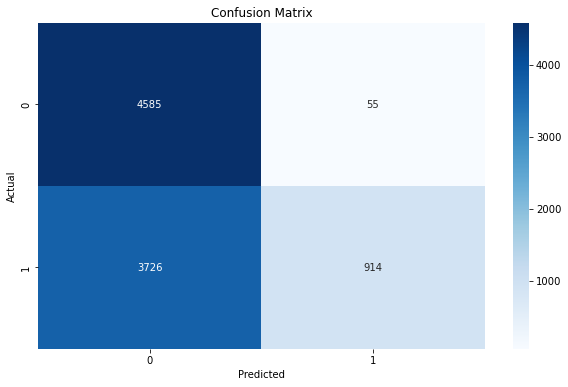

In [57]:
%time
log_RUS_beforePCA = LogisticRegressionClass(data = x_rus,target = y_rus,
                                        learning_rate = 1e-5, epsilon = 1e-5, max_iterations= 1000)
log_RUS_beforePCA.fit()

Testing metrics


C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\4144562977.py:30: RuntimeWarning:

overflow encountered in exp



Values
Metrics                                        
Accuracy                               0.897467
Error rate                             0.102533
Sensitivity/Recall/True Positive Rate  0.214799
False Negative Rate                    0.785201
Specificity/True Negative Rate         0.984131
F1 score                               0.352632

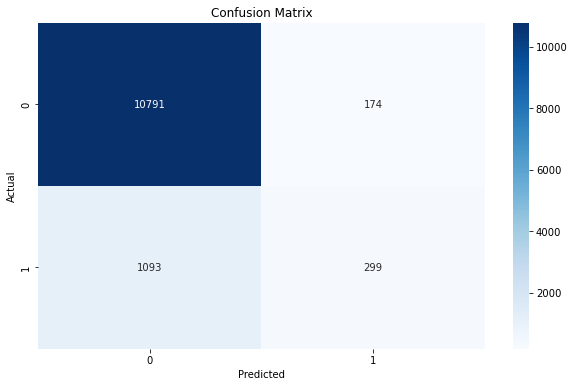

In [58]:
log_RUS_beforePCA.evaluation_metrics(X_Ptest,y_Ptest,mode = 'test')

CPU times: total: 0 ns
Wall time: 0 ns


  0%|                                                                                          | 0/999 [00:00<?, ?it/s]C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\4144562977.py:43: RuntimeWarning:

divide by zero encountered in log

C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\4144562977.py:43: RuntimeWarning:

invalid value encountered in matmul

C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\4144562977.py:30: RuntimeWarning:

overflow encountered in exp

100%|███████████████████████████████████████████████████████████████████████████████| 999/999 [00:03<00:00, 294.52it/s]


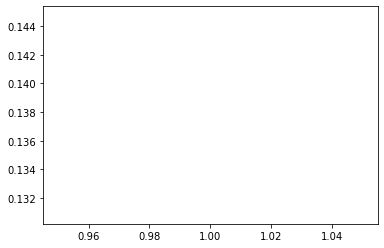

Gradient descent used
[-4.88123959e-02 -1.33139361e+00 -5.17653565e-01  5.30486154e-02
 -1.35308254e-01  3.08607735e+00 -1.08269671e-01 -5.12243146e-03
 -9.63172958e-03  9.83914220e-03  4.67244486e-02 -4.44133880e-03
 -3.84049575e-02  3.21610411e-02  4.20149586e-03 -6.42588005e-03
 -2.12164824e-03 -1.10562168e-01  7.17059461e-02  2.38413975e-04
 -1.27234135e-02 -6.48481528e-02 -2.49835011e-02  1.19506413e-03
 -2.51706748e-03  8.23063928e-02  9.12322010e-03 -9.43148174e-02
  0.00000000e+00 -7.81180067e-03 -3.33993643e-02 -7.81180067e-03
 -1.70347646e-02 -2.12702228e-01  5.36811590e-02  1.08637403e-02
  1.37129697e-01  5.64469875e-02  5.44933505e-02 -4.26120710e-01
  3.82587381e-03  4.41543398e-02  1.65784866e-02 -7.15423838e-02
  9.75151972e-03 -1.86466255e-03  2.39141989e-02  6.12471606e-02
 -4.52852867e-02  9.79005538e+00] 

Training metrics


Values
Metrics                                        
Accuracy                               0.716703
Error rate                             0.283297
Sensitivity/Recall/True Positive Rate  0.711422
False Negative Rate                    0.288578
Specificity/True Negative Rate         0.721983
F1 score                               0.716664

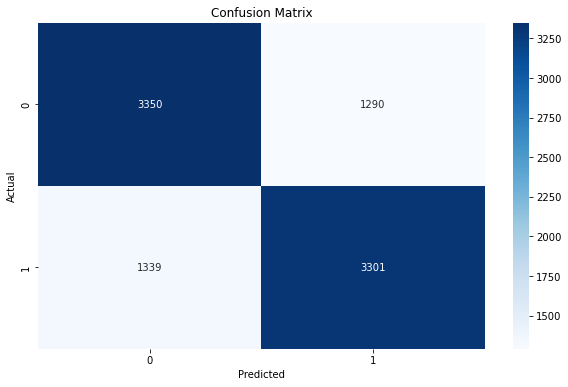

In [59]:
%time
log_RUS_afterPCA = LogisticRegressionClass(data = x_arus,target = y_arus,
                                        learning_rate = 1e-6, epsilon = 1e-5, max_iterations= 1000)
log_RUS_afterPCA.fit()

Testing metrics


Values
Metrics                                        
Accuracy                               0.722991
Error rate                             0.277009
Sensitivity/Recall/True Positive Rate  0.704741
False Negative Rate                    0.295259
Specificity/True Negative Rate         0.725308
F1 score                               0.714877

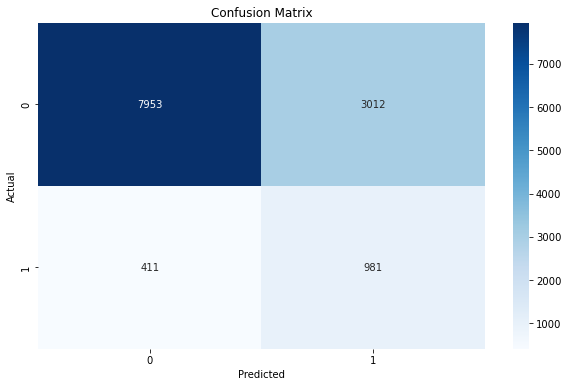

In [60]:
log_RUS_afterPCA.evaluation_metrics(X_Ptest,y_Ptest,mode = 'test')

## Soft SVM

In [61]:
@dataclass
class SoftMarginSVM:
    c:float
        
    def fit(self,X,y):
        X = X.to_numpy()
        y = y.to_numpy()
        N, n_features = X.shape
        y = np.where(y!=1,-1,1)
        Xy = X*y[:,np.newaxis]
        gramXy = np.matmul(Xy,Xy.T)
        
        
        def objectivefunction(alpha,gramXy):
            return alpha.sum() - 0.5*alpha.dot(alpha.dot(gramXy))
        
        
        def gradobjectivefunction(alpha,gramXy):
            return np.ones(N) - alpha.dot(gramXy)
        
        alphas = np.zeros(N)
        alpha_bounds = Bounds(np.zeros(N), np.ones(N)*self.c)
        
        constraints = ({'type':'eq', 'fun':lambda alpha:np.dot(alpha,y),'jac':lambda alpha: -y})
        
        with tqdm(total=5) as pbar:
            for i in range(5):
        
                slsqp = optimize.minimize(fun = lambda a: -objectivefunction(a,gramXy), x0 = alphas, jac = lambda a: -gradobjectivefunction(a,gramXy),
                                 constraints=constraints,bounds=alpha_bounds,method = 'SLSQP')
                pbar.update(1)
        
        
        self.alphas = slsqp.x
        print(self.alphas.shape)
        print(Xy.shape)
        self.w = np.sum((Xy.T.dot(self.alphas[:,np.newaxis])),axis = 1)
        print(self.w)
        epsilon = 0.001
        self.support_vectors = X[self.alphas > epsilon]
        self.support_labels = y[self.alphas > epsilon]
        
        b = []
        for i in range(len(self.support_vectors)):
            b_i = self.support_labels[i] - np.matmul(self.support_vectors[i],self.w)
            b.append(b_i)
            
            
        self.b = sum(b)/len(b)
        print(self.b)

In [62]:
x_rus.shape

(9280, 49)

In [181]:
X_train, X_test, y_train, y_test = train_test_split(x_rus, y_rus, test_size=0.95, random_state=42, stratify = y_rus)

In [182]:
%time
SVM_RUS_beforePCA = SoftMarginSVM(c=0.01)
SVM_RUS_beforePCA.fit(X_train,y_train)

CPU times: total: 0 ns
Wall time: 0 ns


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]C:\Users\DELL\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:20<00:00, 64.12s/it]

(464,)
(464, 33)
[ 2.20236326e-02  2.06770899e-02  9.63571465e-03  1.63385931e-03
 -9.99999988e-03 -8.74143369e-03 -3.68029036e-03  0.00000000e+00
 -9.69479867e-05 -1.16950331e-02  1.33813755e-02 -1.43070098e-02
  1.37723607e-02 -1.28887207e-03  3.90124112e-03  5.83480969e-03
 -3.22244063e-03  1.06133493e-01  2.32135915e-02  1.23053413e-01
 -1.95663120e-01 -2.06712096e-02 -6.84089836e-03 -9.26419691e-03
 -5.07193628e-02  5.94653314e-02 -2.07286904e-01  1.68914260e-02
 -1.63193191e-04 -3.26849880e-03 -5.96795116e-04 -9.44255398e-02
 -1.36571596e-02]
-0.03804862518906646


In [183]:
def Confusion_Matrix(y, y_pred):
    
    a1_p1 = np.sum((y & y_pred))
    a1_p0 = y.sum() - a1_p1

    a0_p1 = y_pred.sum() - a1_p1
    a0_p0 = len(y) - y.sum() - a0_p1

    matrix = np.array([[a0_p0, a0_p1], [a1_p0, a1_p1]])

    plt.figure(figsize=(10,6))
    sns.heatmap(matrix, annot=True, cmap='Blues', fmt='g')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    ## Metrics
    Accuracy = (a1_p1 + a0_p0)/ len(y)
    Error_rate = 1 - Accuracy

    Sensitivity = a1_p1/y.sum()
    False_Negative_Rate = 1 - Sensitivity

    Specificity = a0_p0/(len(y) - y.sum())

    F1_score = 2 * Sensitivity * Specificity/(Sensitivity + Specificity)

    metrics_df = pd.DataFrame({ "Metrics": ["Accuracy", "Error rate", "Sensitivity/Recall/True Positive Rate", 
                                            "False Negative Rate", "Specificity/True Negative Rate", "F1 score"
                                           ],
                               "Values": [Accuracy, Error_rate, Sensitivity, False_Negative_Rate,
                                         Specificity, F1_score
                                         ]

    })
    metrics_df.set_index("Metrics", inplace = True)
    display(metrics_df)

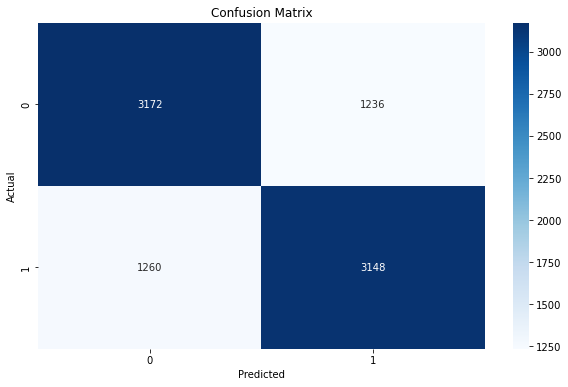

Values
Metrics                                        
Accuracy                               0.716878
Error rate                             0.283122
Sensitivity/Recall/True Positive Rate  0.714156
False Negative Rate                    0.285844
Specificity/True Negative Rate         0.719601
F1 score                               0.716868

In [184]:
y_pred = np.sign(np.add(np.matmul(X_test,SVM_RUS_beforePCA.w),SVM_RUS_beforePCA.b))
y_pred = np.where(y_pred==-1,0,1)
Confusion_Matrix(y_test,y_pred)

## QDA

In [65]:
class LDAQDA:
    def __init__(self, X,y,method='LDA'):
      self.method = method
      self.prior = None
      self.means = None
      self.covs = None
      self.classes = None
      self.X = X.to_numpy()
      self.y = y.to_numpy()

        # Load the dataset from a CSV file
    '''data = pd.read_csv('/bank-additional-full.csv')

    # Extract the features and labels
    X = data.iloc[:, :-1].values  # Features
    y = data.iloc[:, -1].values   # Labels

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
'''

    def fit(self):
      self.classes = np.unique(self.y)
      self.prior = np.zeros(len(self.classes))
      self.means = np.zeros((len(self.classes), self.X.shape[1]))
      self.covs = []

      for i, c in enumerate(self.classes):
          X_c = self.X[self.y == c]
          self.prior[i] = X_c.shape[0] / self.X.shape[0]
          self.means[i] = np.mean(X_c, axis=0)
          self.covs.append(np.cov(X_c.T))

      self.covs = np.array(self.covs)


    def predict(self, X_test):
      X_test = X_test.to_numpy()
      if self.classes is None:
        raise ValueError("The model has not been trained yet.")
      preds = np.zeros(X_test.shape[0])

      for i in range(X_test.shape[0]):
        posteriors = []
        for j, c in enumerate(self.classes):
          mean_diff = X_test[i] - self.means[j]
          if self.method == 'LDA':
            exponent = -0.5 * np.dot(np.dot(mean_diff, np.linalg.inv(np.cov(X_test.T))), mean_diff.T)
          elif self.method == 'QDA':
            try:
                cov_inv = np.linalg.inv(self.covs[j])
            except:
                cov_inv = np.eye(self.covs[j].shape[0],dtype=float)
            exponent = -0.5 * np.dot(np.dot(mean_diff, cov_inv), mean_diff.T)
            exponent = np.exp(exponent)/(np.linalg.det(self.covs[j]))
          else:
            raise ValueError("Invalid method specified. Choose 'LDA' or 'QDA'.")

          #likelihood = multivariate_normal.pdf(X_test[i], mean=self.means[j], cov=self.covs[j])
          posterior = exponent * self.prior[j]
          posteriors.append(posterior)
          '''
          likelihood = multivariate_normal.pdf(X_test[i], mean=self.means[j], cov=self.covs[j])
          posterior = likelihood * self.prior[j]
          posteriors.append(posterior)
          '''

        preds[i] = self.classes[np.argmax(posteriors)]

      return preds

In [66]:
X = df_AfterPCA.drop('y',axis =1)
y = df_AfterPCA['y']
X_Ptrain, X_Ptest, y_Ptrain, y_Ptest = train_test_split(X,y,test_size=0.3,random_state=24,stratify=y)
X_Ptrain.shape, X_Ptest.shape, y_Ptrain.shape, y_Ptest.shape

((28831, 49), (12357, 49), (28831,), (12357,))

In [67]:
%time
QDA = LDAQDA(X_Ptrain,y_Ptrain,method='QDA')

CPU times: total: 0 ns
Wall time: 0 ns


C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\3240372393.py:54: RuntimeWarning:

divide by zero encountered in double_scalars

C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\3240372393.py:54: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\3240372393.py:54: RuntimeWarning:

overflow encountered in exp



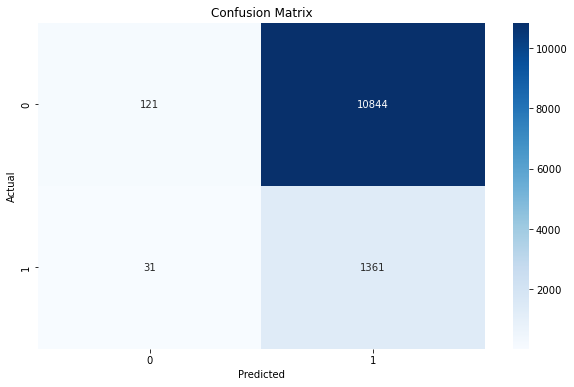

Values
Metrics                                        
Accuracy                               0.119932
Error rate                             0.880068
Sensitivity/Recall/True Positive Rate  0.977730
False Negative Rate                    0.022270
Specificity/True Negative Rate         0.011035
F1 score                               0.021824

In [70]:
QDA.fit()
y_pred = QDA.predict(X_Ptest)
Confusion_Matrix(y_Ptest,y_pred.astype('int32'))

## Neural Networks

In [71]:
y_rus.shape

(9280,)

In [72]:
dfn = x_rus
X = dfn
y = y_rus

# Create train-test split with 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the training and testing data
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (7424, 49)
X_test shape: (1856, 49)
y_train shape: (7424,)
y_test shape: (1856,)


In [73]:
%time
modeln = Sequential()
modeln.add(Dense(20, input_shape=(X_train.shape[1],), activation='relu')) # layer 1
modeln.add(Dense(10, activation='tanh'))  # layer 2
modeln.add(Dense(1, activation='sigmoid'))  # layer 3

# Compile the model
modeln.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'],)

# Train the model
NeuralNet = modeln.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=1)

CPU times: total: 0 ns
Wall time: 0 ns
Epoch 1/20
186/186 [==============================] - 2s 3ms/step - loss: 0.6809 - accuracy: 0.5514 - val_loss: 0.6398 - val_accuracy: 0.6007
Epoch 2/20
186/186 [==============================] - 0s 2ms/step - loss: 0.6408 - accuracy: 0.5999 - val_loss: 0.6361 - val_accuracy: 0.6007
Epoch 3/20
186/186 [==============================] - 0s 2ms/step - loss: 0.6378 - accuracy: 0.6016 - val_loss: 0.6354 - val_accuracy: 0.6007
Epoch 4/20
186/186 [==============================] - 0s 2ms/step - loss: 0.6384 - accuracy: 0.5999 - val_loss: 0.6342 - val_accuracy: 0.6007
Epoch 5/20
186/186 [==============================] - 0s 2ms/step - loss: 0.6376 - accuracy: 0.5999 - val_loss: 0.6335 - val_accuracy: 0.6007
Epoch 6/20
186/186 [==============================] - 0s 3ms/step - loss: 0.6374 - accuracy: 0.5999 - val_loss: 0.6331 - val_accuracy: 0.6007
Epoch 7/20
186/186 [==============================] - 0s 2ms/step - loss: 0.6372 - accuracy: 0.5999 - val_los

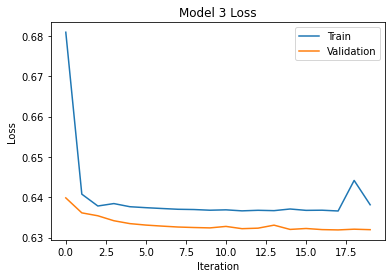

In [74]:
plt.plot(NeuralNet.history['loss'])
plt.plot(NeuralNet.history['val_loss'])
plt.title('Model 3 Loss')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [75]:
cutoff = 0.5
y_pred = modeln.predict(X_test)
y_pred_1 = (y_pred > cutoff).astype('int64')
y_pred_1.shape

58/58 [==============================] - 0s 1ms/step


(1856, 1)

In [76]:
y_pred_1.shape

(1856, 1)

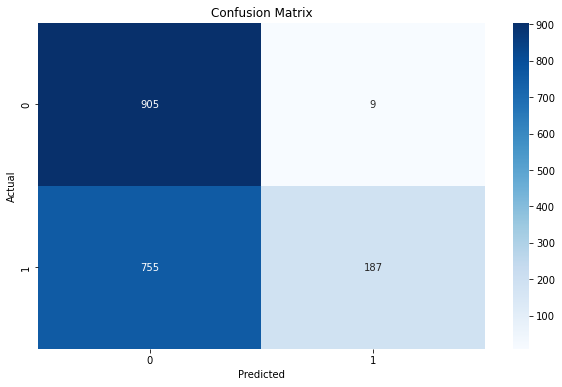

Values
Metrics                                        
Accuracy                               0.588362
Error rate                             0.411638
Sensitivity/Recall/True Positive Rate  0.198514
False Negative Rate                    0.801486
Specificity/True Negative Rate         0.990153
F1 score                               0.330722

In [77]:
Confusion_Matrix(y_test,y_pred_1.reshape(-1))

In [78]:
%time
modeln_1 = Sequential()
modeln_1.add(Dense(120, input_shape=(X_train.shape[1],), activation='LeakyReLU')) # layer 1
modeln_1.add(Dense(80, activation='tanh'))  # layer 2
modeln_1.add(Dense(1, activation='sigmoid'))  # layer 3

# Compile the model
modeln_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
NeuralNet3 = modeln_1.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=1)

CPU times: total: 0 ns
Wall time: 0 ns
Epoch 1/100
186/186 [==============================] - 1s 3ms/step - loss: 0.6435 - accuracy: 0.5924 - val_loss: 0.6382 - val_accuracy: 0.6007
Epoch 2/100
186/186 [==============================] - 0s 2ms/step - loss: 0.6388 - accuracy: 0.5999 - val_loss: 0.6315 - val_accuracy: 0.6007
Epoch 3/100
186/186 [==============================] - 0s 2ms/step - loss: 0.6374 - accuracy: 0.5957 - val_loss: 0.6326 - val_accuracy: 0.6007
Epoch 4/100
186/186 [==============================] - 0s 2ms/step - loss: 0.6385 - accuracy: 0.5999 - val_loss: 0.6321 - val_accuracy: 0.6007
Epoch 5/100
186/186 [==============================] - 0s 2ms/step - loss: 0.6381 - accuracy: 0.5892 - val_loss: 0.6319 - val_accuracy: 0.6007
Epoch 6/100
186/186 [==============================] - 0s 3ms/step - loss: 0.6382 - accuracy: 0.5999 - val_loss: 0.6317 - val_accuracy: 0.6007
Epoch 7/100
186/186 [==============================] - 0s 2ms/step - loss: 0.6382 - accuracy: 0.5952 - 

Epoch 58/100
186/186 [==============================] - 1s 3ms/step - loss: 0.6326 - accuracy: 0.6006 - val_loss: 0.6317 - val_accuracy: 0.6007
Epoch 59/100
186/186 [==============================] - 0s 2ms/step - loss: 0.6336 - accuracy: 0.5940 - val_loss: 0.6319 - val_accuracy: 0.6007
Epoch 60/100
186/186 [==============================] - 0s 2ms/step - loss: 0.6329 - accuracy: 0.5999 - val_loss: 0.6325 - val_accuracy: 0.6007
Epoch 61/100
186/186 [==============================] - 0s 2ms/step - loss: 0.6326 - accuracy: 0.5935 - val_loss: 0.6339 - val_accuracy: 0.6007
Epoch 62/100
186/186 [==============================] - 0s 2ms/step - loss: 0.6321 - accuracy: 0.5999 - val_loss: 0.6348 - val_accuracy: 0.6007
Epoch 63/100
186/186 [==============================] - 1s 3ms/step - loss: 0.6315 - accuracy: 0.6001 - val_loss: 0.6328 - val_accuracy: 0.6007
Epoch 64/100
186/186 [==============================] - 0s 2ms/step - loss: 0.6323 - accuracy: 0.6006 - val_loss: 0.6322 - val_accuracy:

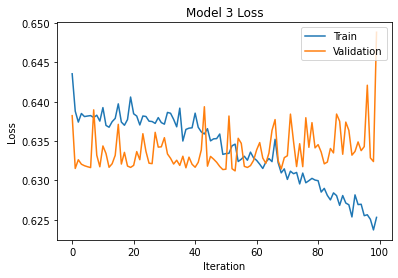

In [79]:
plt.plot(NeuralNet3.history['loss'])
plt.plot(NeuralNet3.history['val_loss'])
plt.title('Model 3 Loss')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

58/58 [==============================] - 0s 2ms/step


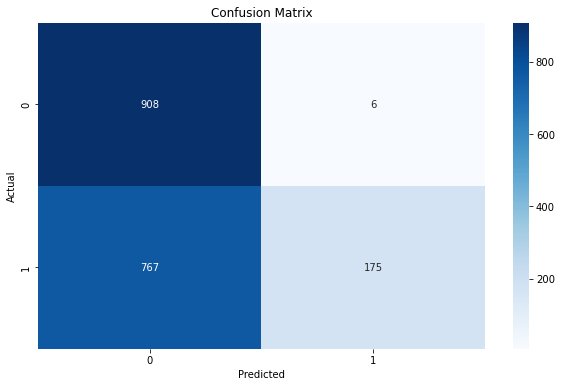

Values
Metrics                                        
Accuracy                               0.583513
Error rate                             0.416487
Sensitivity/Recall/True Positive Rate  0.185775
False Negative Rate                    0.814225
Specificity/True Negative Rate         0.993435
F1 score                               0.313015

In [80]:
cutoff = 0.5
y_pred = modeln_1.predict(X_test)
y_pred_1 = (y_pred > cutoff).astype('int64')
#y_pred_1.shape
Confusion_Matrix(y_test,y_pred_1.reshape(-1))

In [81]:
class datagen:

    def __init__(self,X_train, y_train, X_dev,y_dev,sample_size = 32):
        self.X_train = X_train.to_numpy()
        self.y_train = y_train.to_numpy()
        self.X_dev = X_dev.to_numpy()
        self.y_dev = y_dev.to_numpy()
        self.sample_size = sample_size


    def trainingSample(self):
        while True:
            idxs = np.random.choice(np.arange((self.X_train.shape[0])),self.sample_size)

            X = self.X_train[idxs]
            y = self.y_train[idxs]

            yield X,y

    def devSample(self):
        while True:
            idxs = np.random.choice(np.arange(self.X_dev.shape[0]),self.sample_size)

            X = self.X_dev[idxs]
            y = self.y_dev[idxs]

            yield X,y

In [82]:
datagen_ = datagen(X_train,y_train,X_test,y_test)
X, y = next(iter(datagen_.devSample()))
early_stopping = EarlyStopping(patience=89, monitor='val_loss', restore_best_weights=True)


In [83]:
%time
knt = modeln.fit(
    datagen_.trainingSample(),
    validation_data=datagen_.devSample(),
    epochs=250,
    steps_per_epoch=len(datagen_.X_train) // datagen_.sample_size,
    validation_steps=len(datagen_.X_dev) // datagen_.sample_size,
    callbacks=[early_stopping]
)

CPU times: total: 0 ns
Wall time: 0 ns
Epoch 1/250
232/232 [==============================] - 1s 3ms/step - loss: 0.6319 - accuracy: 0.6036 - val_loss: 0.6395 - val_accuracy: 0.5975
Epoch 2/250
232/232 [==============================] - 1s 2ms/step - loss: 0.6359 - accuracy: 0.5958 - val_loss: 0.6309 - val_accuracy: 0.5878
Epoch 3/250
232/232 [==============================] - 0s 2ms/step - loss: 0.6357 - accuracy: 0.5995 - val_loss: 0.6366 - val_accuracy: 0.5846
Epoch 4/250
232/232 [==============================] - 1s 3ms/step - loss: 0.6385 - accuracy: 0.5946 - val_loss: 0.6269 - val_accuracy: 0.5911
Epoch 5/250
232/232 [==============================] - 1s 2ms/step - loss: 0.6424 - accuracy: 0.5927 - val_loss: 0.6268 - val_accuracy: 0.6051
Epoch 6/250
232/232 [==============================] - 1s 3ms/step - loss: 0.6365 - accuracy: 0.5878 - val_loss: 0.6317 - val_accuracy: 0.5867
Epoch 7/250
232/232 [==============================] - 1s 3ms/step - loss: 0.6382 - accuracy: 0.6068 - 

Epoch 58/250
232/232 [==============================] - 1s 2ms/step - loss: 0.6358 - accuracy: 0.6012 - val_loss: 0.6317 - val_accuracy: 0.6024
Epoch 59/250
232/232 [==============================] - 0s 2ms/step - loss: 0.6278 - accuracy: 0.6048 - val_loss: 0.6289 - val_accuracy: 0.6029
Epoch 60/250
232/232 [==============================] - 1s 2ms/step - loss: 0.6293 - accuracy: 0.6083 - val_loss: 0.6478 - val_accuracy: 0.5824
Epoch 61/250
232/232 [==============================] - 1s 2ms/step - loss: 0.6344 - accuracy: 0.5993 - val_loss: 0.6309 - val_accuracy: 0.5921
Epoch 62/250
232/232 [==============================] - 1s 2ms/step - loss: 0.6341 - accuracy: 0.6045 - val_loss: 0.6333 - val_accuracy: 0.5932
Epoch 63/250
232/232 [==============================] - 0s 2ms/step - loss: 0.6393 - accuracy: 0.5938 - val_loss: 0.6271 - val_accuracy: 0.5986
Epoch 64/250
232/232 [==============================] - 0s 2ms/step - loss: 0.6351 - accuracy: 0.6060 - val_loss: 0.6466 - val_accuracy:

Epoch 115/250
232/232 [==============================] - 1s 2ms/step - loss: 0.6341 - accuracy: 0.6032 - val_loss: 0.6418 - val_accuracy: 0.5927
Epoch 116/250
232/232 [==============================] - 1s 2ms/step - loss: 0.6382 - accuracy: 0.5983 - val_loss: 0.6333 - val_accuracy: 0.5932
Epoch 117/250
232/232 [==============================] - 0s 2ms/step - loss: 0.6282 - accuracy: 0.6157 - val_loss: 0.6444 - val_accuracy: 0.5857
Epoch 118/250
232/232 [==============================] - 0s 2ms/step - loss: 0.6382 - accuracy: 0.5927 - val_loss: 0.6404 - val_accuracy: 0.5781
Epoch 119/250
232/232 [==============================] - 1s 2ms/step - loss: 0.6383 - accuracy: 0.6009 - val_loss: 0.6381 - val_accuracy: 0.5814
Epoch 120/250
232/232 [==============================] - 0s 2ms/step - loss: 0.6361 - accuracy: 0.6010 - val_loss: 0.6388 - val_accuracy: 0.5797
Epoch 121/250
232/232 [==============================] - 1s 2ms/step - loss: 0.6380 - accuracy: 0.5993 - val_loss: 0.6310 - val_ac

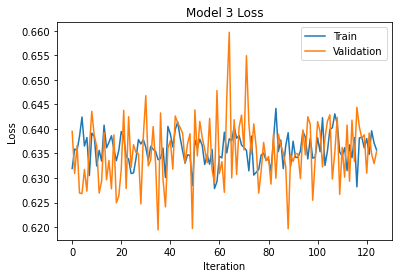

In [84]:
plt.plot(knt.history['loss'])
plt.plot(knt.history['val_loss'])
plt.title('Model 3 Loss')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
cutoff = 0.5
y_pred = modeln.predict(X_test)
y_pred_1 = (y_pred > cutoff).astype('int64')
#y_pred_1.shape
Confusion_Matrix(y_test,y_pred_1.reshape(-1))

In [85]:
%time
modeln_2 = Sequential()
modeln_2.add(Dense(120, input_shape=(X_train.shape[1],), activation='LeakyReLU')) # layer 1
modeln_2.add(Dense(80, activation='tanh'))  # layer 2
modeln_2.add(Dense(1, activation='sigmoid'))  # layer 3


CPU times: total: 0 ns
Wall time: 0 ns


In [86]:
%time
modeln_2.compile(optimizer='adam',loss = 'binary_crossentropy',metrics=['accuracy'])
knt = modeln_2.fit(
    datagen_.trainingSample(),
    validation_data=datagen_.devSample(),
    epochs=50,
    steps_per_epoch=len(datagen_.X_train) // datagen_.sample_size,
    validation_steps=len(datagen_.X_dev) // datagen_.sample_size,
    callbacks=[early_stopping]
)

CPU times: total: 0 ns
Wall time: 0 ns
Epoch 1/50
232/232 [==============================] - 1s 3ms/step - loss: 0.6415 - accuracy: 0.5990 - val_loss: 0.6412 - val_accuracy: 0.5787
Epoch 2/50
232/232 [==============================] - 1s 2ms/step - loss: 0.6355 - accuracy: 0.6026 - val_loss: 0.6435 - val_accuracy: 0.5754
Epoch 3/50
232/232 [==============================] - 0s 2ms/step - loss: 0.6312 - accuracy: 0.6047 - val_loss: 0.6444 - val_accuracy: 0.5991
Epoch 4/50
232/232 [==============================] - 0s 2ms/step - loss: 0.6405 - accuracy: 0.5885 - val_loss: 0.6336 - val_accuracy: 0.6051
Epoch 5/50
232/232 [==============================] - 0s 2ms/step - loss: 0.6334 - accuracy: 0.6075 - val_loss: 0.6447 - val_accuracy: 0.5803
Epoch 6/50
232/232 [==============================] - 1s 3ms/step - loss: 0.6356 - accuracy: 0.5920 - val_loss: 0.6412 - val_accuracy: 0.5884
Epoch 7/50
232/232 [==============================] - 1s 2ms/step - loss: 0.6370 - accuracy: 0.5998 - val_los

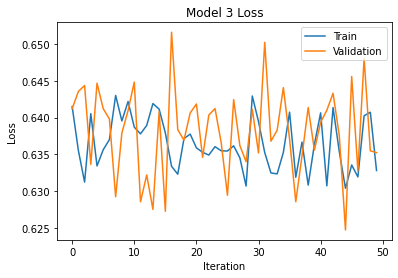

In [87]:
plt.plot(knt.history['loss'])
plt.plot(knt.history['val_loss'])
plt.title('Model 3 Loss')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

58/58 [==============================] - 0s 1ms/step


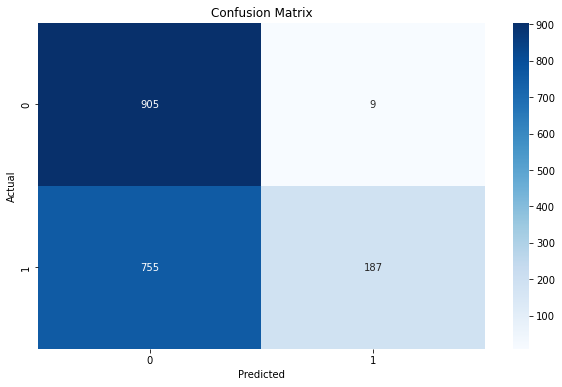

Values
Metrics                                        
Accuracy                               0.588362
Error rate                             0.411638
Sensitivity/Recall/True Positive Rate  0.198514
False Negative Rate                    0.801486
Specificity/True Negative Rate         0.990153
F1 score                               0.330722

In [88]:
cutoff = 0.5
y_pred = modeln_2.predict(X_test)
y_pred_1 = (y_pred > cutoff).astype('int64')
#y_pred_1.shape
Confusion_Matrix(y_test,y_pred_1.reshape(-1))

## After encoding categorical columns

In [89]:
class encoding:
    def __init__(self, data):
        self.data = data
    
    def generate_binary_numbers(self, n):
        binary_numbers = []
        for i in range(2**n):
            binary_number = format(i, 'b').zfill(n)
            if binary_number != '0'*n:
                binary_numbers.append(binary_number)
        return binary_numbers

    def fit(self):
        for col in self.data.columns:
            unique = self.data[col].unique()
            if len(unique)>2:
                num = math.ceil(math.log(len(unique), 1.9))

                bits = self.generate_binary_numbers(num)

                zipped_list = list(zip(unique, bits))
                zipped_dict = dict(zipped_list[:len(unique)])

                print(zipped_dict)
                for key, value in zipped_dict.items():
                    new_list = [str(col)+str(i) for i in range(1,len(value)+1)]
                    zipped_dict[key] = dict(list(zip(new_list, list(value))))

                self.data[col] = self.data[col].map(zipped_dict)
            
            else:
                self.data.drop([col], axis = 1, inplace = True)

In [90]:
df_cat_enc = df.drop(["y"], axis  = 1).select_dtypes(include='O')

enc = encoding(data = df_cat_enc)
enc.fit()

{'housemaid': '0001', 'services': '0010', 'admin.': '0011', 'blue-collar': '0100', 'technician': '0101', 'retired': '0110', 'management': '0111', 'unemployed': '1000', 'self-employed': '1001', 'unknown': '1010', 'entrepreneur': '1011', 'student': '1100'}
{'married': '001', 'single': '010', 'divorced': '011', 'unknown': '100'}
{'basic.4y': '0001', 'high.school': '0010', 'basic.6y': '0011', 'basic.9y': '0100', 'professional.course': '0101', 'unknown': '0110', 'university.degree': '0111', 'illiterate': '1000'}
{'no': '01', 'unknown': '10', 'yes': '11'}
{'no': '01', 'yes': '10', 'unknown': '11'}
{'no': '01', 'yes': '10', 'unknown': '11'}
{'may': '0001', 'jun': '0010', 'jul': '0011', 'aug': '0100', 'oct': '0101', 'nov': '0110', 'dec': '0111', 'mar': '1000', 'apr': '1001', 'sep': '1010'}
{'mon': '001', 'tue': '010', 'wed': '011', 'thu': '100', 'fri': '101'}
{'nonexistent': '01', 'failure': '10', 'success': '11'}


In [91]:
df_cat_encoded = enc.data
df_cat_encoded

job  \
0      {'job1': '0', 'job2': '0', 'job3': '0', 'job4'...   
1      {'job1': '0', 'job2': '0', 'job3': '1', 'job4'...   
2      {'job1': '0', 'job2': '0', 'job3': '1', 'job4'...   
3      {'job1': '0', 'job2': '0', 'job3': '1', 'job4'...   
4      {'job1': '0', 'job2': '0', 'job3': '1', 'job4'...   
...                                                  ...   
41183  {'job1': '0', 'job2': '1', 'job3': '1', 'job4'...   
41184  {'job1': '0', 'job2': '1', 'job3': '0', 'job4'...   
41185  {'job1': '0', 'job2': '1', 'job3': '1', 'job4'...   
41186  {'job1': '0', 'job2': '1', 'job3': '0', 'job4'...   
41187  {'job1': '0', 'job2': '1', 'job3': '1', 'job4'...   

                                                 marital  \
0      {'marital1': '0', 'marital2': '0', 'marital3':...   
1      {'marital1': '0', 'marital2': '0', 'marital3':...   
2      {'marital1': '0', 'marital2': '0', 'marital3':...   
3      {'marital1': '0', 'marital2': '0', 'marital3':...   
4      {'marital1': '0', 'marital2': '0', 'marital3':...   
...                                                  ...   
41183  {'marital1': '0', 'marital2': '0', 'marital3':...   
41184  {'marital1': '0', 'marital2': '0', 'marital3':...   
41185  {'marital1': '0', 'marital2': '0', 'marital3':...   
41186  {'marital1': '0', 'marital2': '0', 'marital3':...   
41187  {'marital1': '0', 'marital2': '0', 'marital3':...   

                                               education  \
0      {'education1': '0', 'education2': '0', 'educat...   
1      {'education1': '0', 'education2': '0', 'educat...   
2      {'education1': '0', 'education2': '0', 'educat...   
3      {'education1': '0', 'education2': '0', 'educat...   
4      {'education1': '0', 'education2': '0', 'educat...   
...                                                  ...   
41183  {'education1': '0', 'education2': '1', 'educat...   
41184  {'education1': '0', 'education2': '1', 'educat...   
41185  {'education1': '0', 'education2': '1', 'educat...   
41186  {'education1': '0', 'education2': '1', 'educat...   
41187  {'education1': '0', 'education2': '1', 'educat...   

                                  default                             housing  \
0      {'default1': '0', 'default2': '1'}  {'housing1': '0', 'housing2': '1'}   
1      {'default1': '1', 'default2': '0'}  {'housing1': '0', 'housing2': '1'}   
2      {'default1': '0', 'default2': '1'}  {'housing1': '1', 'housing2': '0'}   
3      {'default1': '0', 'default2': '1'}  {'housing1': '0', 'housing2': '1'}   
4      {'default1': '0', 'default2': '1'}  {'housing1': '0', 'housing2': '1'}   
...                                   ...                                 ...   
41183  {'default1': '0', 'default2': '1'}  {'housing1': '1', 'housing2': '0'}   
41184  {'default1': '0', 'default2': '1'}  {'housing1': '0', 'housing2': '1'}   
41185  {'default1': '0', 'default2': '1'}  {'housing1': '1', 'housing2': '0'}   
41186  {'default1': '0', 'default2': '1'}  {'housing1': '0', 'housing2': '1'}   
41187  {'default1': '0', 'default2': '1'}  {'housing1': '1', 'housing2': '0'}   

                               loan  \
0      {'loan1': '0', 'loan2': '1'}   
1      {'loan1': '0', 'loan2': '1'}   
2      {'loan1': '0', 'loan2': '1'}   
3      {'loan1': '0', 'loan2': '1'}   
4      {'loan1': '1', 'loan2': '0'}   
...                             ...   
41183  {'loan1': '0', 'loan2': '1'}   
41184  {'loan1': '0', 'loan2': '1'}   
41185  {'loan1': '0', 'loan2': '1'}   
41186  {'loan1': '0', 'loan2': '1'}   
41187  {'loan1': '0', 'loan2': '1'}   

                                                   month  \
0      {'month1': '0', 'month2': '0', 'month3': '0', ...   
1      {'month1': '0', 'month2': '0', 'month3': '0', ...   
2      {'month1': '0', 'month2': '0', 'month3': '0', ...   
3      {'month1': '0', 'month2': '0', 'month3': '0', ...   
4      {'month1': '0', 'month2': '0', 'month3': '0', ...   
...                                                  ...   
41183  {'month1': '0', 'mont

In [92]:
for column in df_cat_encoded.columns:

    # Convert the column to a list of dictionaries
    column_dicts = df_cat_encoded[column].apply(pd.Series)

    # Get the unique keys of the dictionaries
    keys = column_dicts.keys()

    # For each unique key, create a new column
    for key in keys:
        new_column = column_dicts[key]
        df_cat_encoded[key] = new_column

    # Drop the original column
    df_cat_encoded.drop([column], axis=1, inplace=True)
df_cat_encoded

job1 job2 job3 job4 marital1 marital2 marital3 education1 education2  \
0        0    0    0    1        0        0        1          0          0   
1        0    0    1    0        0        0        1          0          0   
2        0    0    1    0        0        0        1          0          0   
3        0    0    1    1        0        0        1          0          0   
4        0    0    1    0        0        0        1          0          0   
...    ...  ...  ...  ...      ...      ...      ...        ...        ...   
41183    0    1    1    0        0        0        1          0          1   
41184    0    1    0    0        0        0        1          0          1   
41185    0    1    1    0        0        0        1          0          1   
41186    0    1    0    1        0        0        1          0          1   
41187    0    1    1    0        0        0        1          0          1   

      education3  ... loan2 month1 month2 month3 month4 day_of_week1  \
0              0  ...     1      0      0      0      1            0   
1              1  ...     1      0      0      0      1            0   
2              1  ...     1      0      0      0      1            0   
3              1  ...     1      0      0      0      1            0   
4              1  ...     0      0      0      0      1            0   
...          ...  ...   ...    ...    ...    ...    ...          ...   
41183          0  ...     1      0      1      1      0            1   
41184          0  ...     1      0      1      1      0            1   
41185          1  ...     1      0      1      1      0            1   
41186          0  ...     1      0      1      1      0            1   
41187          0  ...     1      0      1      1      0            1   

      day_of_week2 day_of_week3 poutcome1 poutcome2  
0                0            1         0         1  
1                0            1         0         1  
2                0            1         0         1  
3                0            1         0         1  
4                0            1         0         1  
...            ...          ...       ...       ...  
41183            0            1         0         1  
41184            0            1         0         1  
41185            0            1         0         1  
41186            0            1         0         1  
41187            0            1         1         0  

[41188 rows x 26 columns]

In [93]:
df_cat_encoded = df_cat_encoded.astype('int32')


In [94]:
df_num = df.select_dtypes(include='number')
df_dummy = pd.DataFrame(one_hot_encoded_data['contact_telephone'],columns=['contact_telephone'])

In [95]:
df_cat_encoded

job1  job2  job3  job4  marital1  marital2  marital3  education1  \
0         0     0     0     1         0         0         1           0   
1         0     0     1     0         0         0         1           0   
2         0     0     1     0         0         0         1           0   
3         0     0     1     1         0         0         1           0   
4         0     0     1     0         0         0         1           0   
...     ...   ...   ...   ...       ...       ...       ...         ...   
41183     0     1     1     0         0         0         1           0   
41184     0     1     0     0         0         0         1           0   
41185     0     1     1     0         0         0         1           0   
41186     0     1     0     1         0         0         1           0   
41187     0     1     1     0         0         0         1           0   

       education2  education3  ...  loan2  month1  month2  month3  month4  \
0               0           0  ...      1       0       0       0       1   
1               0           1  ...      1       0       0       0       1   
2               0           1  ...      1       0       0       0       1   
3               0           1  ...      1       0       0       0       1   
4               0           1  ...      0       0       0       0       1   
...           ...         ...  ...    ...     ...     ...     ...     ...   
41183           1           0  ...      1       0       1       1       0   
41184           1           0  ...      1       0       1       1       0   
41185           1           1  ...      1       0       1       1       0   
41186           1           0  ...      1       0       1       1       0   
41187           1           0  ...      1       0       1       1       0   

       day_of_week1  day_of_week2  day_of_week3  poutcome1  poutcome2  
0                 0             0             1          0          1  
1                 0             0             1          0          1  
2                 0             0             1          0          1  
3                 0             0             1          0          1  
4                 0             0             1          0          1  
...             ...           ...           ...        ...        ...  
41183             1             0             1          0          1  
41184             1             0             1          0          1  
41185             1             0             1          0          1  
41186             1             0             1          0          1  
41187             1             0             1          1          0  

[41188 rows x 26 columns]

In [96]:
df_beforePCA = pd.concat([df_cat_encoded,df_dummy,df_num],axis = 1)
df_beforePCA

job1  job2  job3  job4  marital1  marital2  marital3  education1  \
0         0     0     0     1         0         0         1           0   
1         0     0     1     0         0         0         1           0   
2         0     0     1     0         0         0         1           0   
3         0     0     1     1         0         0         1           0   
4         0     0     1     0         0         0         1           0   
...     ...   ...   ...   ...       ...       ...       ...         ...   
41183     0     1     1     0         0         0         1           0   
41184     0     1     0     0         0         0         1           0   
41185     0     1     1     0         0         0         1           0   
41186     0     1     0     1         0         0         1           0   
41187     0     1     1     0         0         0         1           0   

       education2  education3  ...  age  campaign  pdays  previous  \
0               0           0  ...   56         1    999         0   
1               0           1  ...   57         1    999         0   
2               0           1  ...   37         1    999         0   
3               0           1  ...   40         1    999         0   
4               0           1  ...   56         1    999         0   
...           ...         ...  ...  ...       ...    ...       ...   
41183           1           0  ...   73         1    999         0   
41184           1           0  ...   46         1    999         0   
41185           1           1  ...   56         2    999         0   
41186           1           0  ...   44         1    999         0   
41187           1           0  ...   74         3    999         1   

       emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed  y  
0               1.1          93.994          -36.4      4.857       5191.0  0  
1               1.1          93.994          -36.4      4.857       5191.0  0  
2               1.1          93.994          -36.4      4.857       5191.0  0  
3               1.1          93.994          -36.4      4.857       5191.0  0  
4               1.1          93.994          -36.4      4.857       5191.0  0  
...             ...             ...            ...        ...          ... ..  
41183          -1.1          94.767          -50.8      1.028       4963.6  1  
41184          -1.1          94.767          -50.8      1.028       4963.6  0  
41185          -1.1          94.767          -50.8      1.028       4963.6  0  
41186          -1.1          94.767          -50.8      1.028       4963.6  1  
41187          -1.1          94.767          -50.8      1.028       4963.6  0  

[41188 rows x 37 columns]

In [97]:
df_beforePCA = df_beforePCA.drop(['cons.price.idx', 'euribor3m', 'nr.employed'],axis = 1)
df_beforePCA.shape

(41188, 34)

In [98]:
d = pd.DataFrame(pca.transform(1),columns=['PCA1'])
df_afterPCA = pd.concat([df_cat_encoded,df_dummy,d,df_num],axis = 1)

Variance Captured :  0.9998083078926981


In [99]:
df_afterPCA = df_afterPCA.drop(['emp.var.rate', 'cons.price.idx', 'euribor3m', 'nr.employed'],axis =1)

In [100]:
X = df_beforePCA.drop('y',axis =1)
y = df_beforePCA['y']
X_Ptrain, X_Ptest, y_Ptrain, y_Ptest = train_test_split(X,y,test_size=0.3,random_state=24,stratify=y)
X_Ptrain.shape, X_Ptest.shape, y_Ptrain.shape, y_Ptest.shape

((28831, 33), (12357, 33), (28831,), (12357,))

CPU times: total: 0 ns
Wall time: 0 ns


  0%|                                                                                         | 0/4999 [00:00<?, ?it/s]C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\4144562977.py:30: RuntimeWarning:

overflow encountered in exp

C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\4144562977.py:43: RuntimeWarning:

divide by zero encountered in log

C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\4144562977.py:43: RuntimeWarning:

invalid value encountered in matmul

100%|██████████████████████████████████████████████████████████████████████████████| 4999/4999 [01:14<00:00, 66.97it/s]


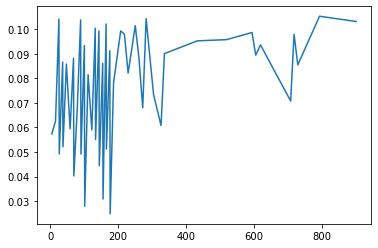

Gradient descent used
[ 1.95634732e-02  1.00921322e-01 -3.11866885e-03  1.11550410e-01
  7.38371278e-02 -2.00931159e-04  1.96719338e-01 -2.00820140e-01
 -2.12061443e-04  1.05739991e-01  1.55628895e-01  1.00317138e-01
 -2.84044099e-01  3.03424571e-01  5.26136137e-02 -3.77507647e-02
 -2.27070790e-02  3.75699279e-02  3.79239978e-01  6.15003706e-02
  1.43536429e-02 -1.13285039e-01  4.61427565e-02  4.45205113e-02
 -3.12665995e-02  1.24657354e-01 -8.79248294e-02 -4.66617207e-01
  4.38900680e-01 -1.27132728e+00 -3.32454358e+00  2.08500521e-01
 -3.04369206e+00  2.17394864e-01] 

Training metrics


C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\4144562977.py:30: RuntimeWarning:

overflow encountered in exp



Values
Metrics                                        
Accuracy                               0.892616
Error rate                             0.107384
Sensitivity/Recall/True Positive Rate  0.088670
False Negative Rate                    0.911330
Specificity/True Negative Rate         0.994684
F1 score                               0.162825

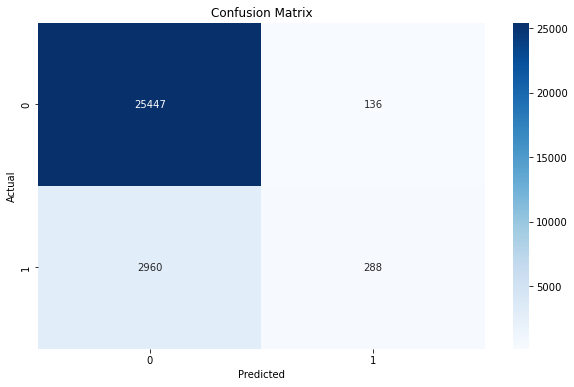

In [101]:
%time
log_beforePCA = LogisticRegressionClass(data = X_Ptrain,target = y_Ptrain,
                                        learning_rate = 1e-6, epsilon = 1e-5, max_iterations= 5000,method='sgd')
log_beforePCA.fit()

Testing metrics


C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\4144562977.py:30: RuntimeWarning:

overflow encountered in exp



Values
Metrics                                        
Accuracy                               0.893825
Error rate                             0.106175
Sensitivity/Recall/True Positive Rate  0.111351
False Negative Rate                    0.888649
Specificity/True Negative Rate         0.993160
F1 score                               0.200250

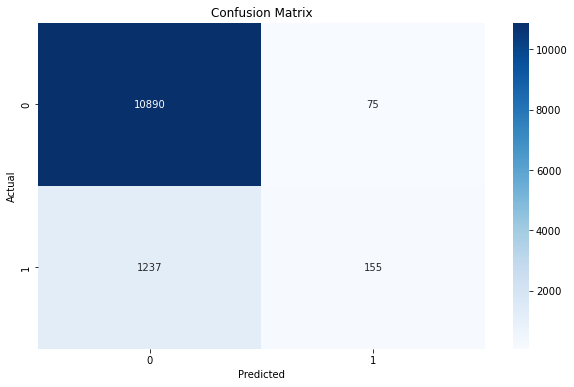

In [102]:
log_beforePCA.evaluation_metrics(X_Ptest,y_Ptest,mode = 'test')

In [103]:
X = df_afterPCA.drop('y',axis =1)
y = df_afterPCA['y']
X_Ptrain, X_Ptest, y_Ptrain, y_Ptest = train_test_split(X,y,test_size=0.3,random_state=24,stratify=y)
X_Ptrain.shape, X_Ptest.shape, y_Ptrain.shape, y_Ptest.shape

((28831, 33), (12357, 33), (28831,), (12357,))

CPU times: total: 0 ns
Wall time: 0 ns


  0%|                                                                                         | 0/4999 [00:00<?, ?it/s]C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\4144562977.py:30: RuntimeWarning:

overflow encountered in exp

C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\4144562977.py:43: RuntimeWarning:

divide by zero encountered in log

C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\4144562977.py:43: RuntimeWarning:

invalid value encountered in matmul

100%|██████████████████████████████████████████████████████████████████████████████| 4999/4999 [01:14<00:00, 67.50it/s]


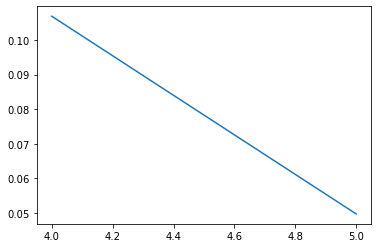

Gradient descent used
[-7.25826589e-02  2.72810404e-02 -5.32353502e-02  4.52204065e-02
  4.17772174e-02 -2.36411190e-04  2.47971142e-02 -1.07492113e-01
 -5.06615130e-05  2.68143783e-02  3.46138769e-02  5.25863278e-02
 -1.32805253e-01  6.01527982e-02 -2.28766027e-02 -5.72032111e-02
 -3.72895103e-02 -4.27903034e-02  1.31179384e-01  7.12137957e-02
  1.83214422e-01 -2.82650117e-01 -4.95348123e-05  2.73211330e-02
 -9.93407537e-02 -1.70897028e-01  5.61445408e-02 -2.82144431e-01
  2.08642629e+00 -5.05639398e-01 -7.51529586e-01  2.98603689e-02
 -3.29759828e-01  3.43251521e+00] 

Training metrics


Values
Metrics                                        
Accuracy                               0.874684
Error rate                             0.125316
Sensitivity/Recall/True Positive Rate  0.449507
False Negative Rate                    0.550493
Specificity/True Negative Rate         0.928664
F1 score                               0.605790

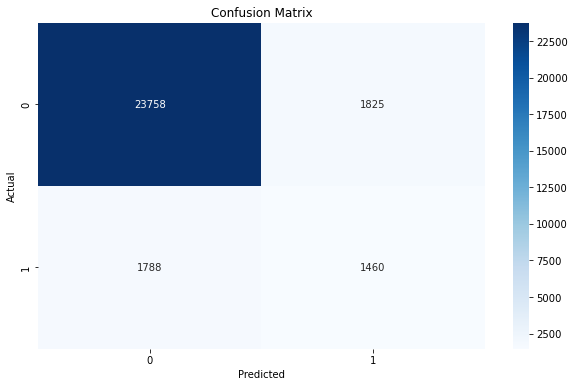

In [104]:
%time
log_afterPCA = LogisticRegressionClass(data = X_Ptrain,target = y_Ptrain,
                                       learning_rate = 1e-6, epsilon = 1e-5, max_iterations= 5000,method='sgd')
log_afterPCA.fit()

Testing metrics


Values
Metrics                                        
Accuracy                               0.874484
Error rate                             0.125516
Sensitivity/Recall/True Positive Rate  0.441810
False Negative Rate                    0.558190
Specificity/True Negative Rate         0.929412
F1 score                               0.598916

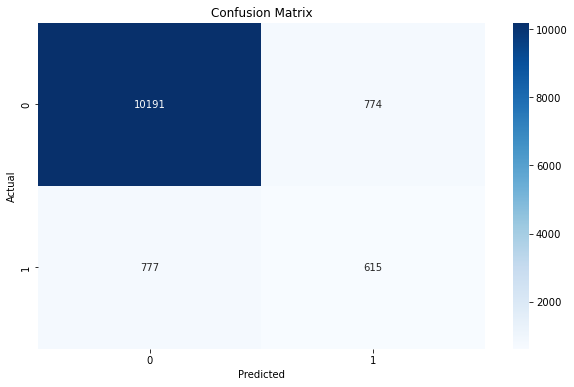

In [105]:
log_afterPCA.evaluation_metrics(X_Ptest,y_Ptest,mode = 'test')

In [106]:
X_RUS = df_afterPCA.drop('y',axis = 1)
y_RUS = df_afterPCA['y']

rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable
x_rus, y_rus = rus.fit_resample(X_RUS, y_RUS)
print('original dataset shape:', Counter(y_RUS))
print('Resample dataset shape', Counter(y_rus))

original dataset shape: Counter({0: 36548, 1: 4640})
Resample dataset shape Counter({0: 4640, 1: 4640})


CPU times: total: 0 ns
Wall time: 0 ns


  0%|                                                                                          | 0/999 [00:00<?, ?it/s]C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\4144562977.py:43: RuntimeWarning:

divide by zero encountered in log

C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\4144562977.py:43: RuntimeWarning:

invalid value encountered in matmul

C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\4144562977.py:30: RuntimeWarning:

overflow encountered in exp

100%|███████████████████████████████████████████████████████████████████████████████| 999/999 [00:02<00:00, 435.28it/s]


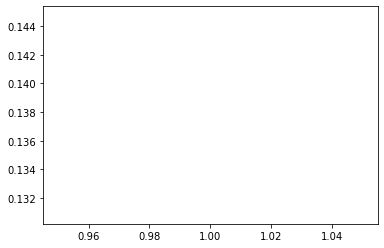

Gradient descent used
[-4.75248198e-02  1.45532575e-02 -1.44911817e-02  4.47579148e-02
  2.77906671e-02  2.22190144e-04  6.33833508e-02 -1.21436007e-01
  1.20011294e-03  2.51616588e-02  5.50911431e-02  3.15912815e-02
 -9.63531324e-02  4.88283126e-02 -3.98464916e-02 -1.53846799e-02
 -2.44273507e-02 -3.08038207e-02  7.56115891e-02  1.11098184e-01
  2.21007905e-01 -2.31109497e-01  1.43053653e-03  2.21718574e-02
 -5.58847191e-02 -1.07286423e-01  1.44763798e-02 -2.17584687e-01
  1.08925441e+01 -1.29705323e+00 -5.24751934e-01  1.33926566e+00
 -1.32187851e-01  2.98217477e+00] 

Training metrics


Values
Metrics                                        
Accuracy                               0.500431
Error rate                             0.499569
Sensitivity/Recall/True Positive Rate  0.999353
False Negative Rate                    0.000647
Specificity/True Negative Rate         0.001509
F1 score                               0.003013

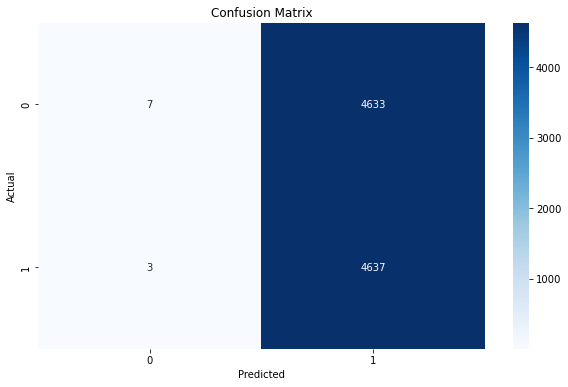

In [107]:
%time
log_RUS_afterPCA = LogisticRegressionClass(data = x_rus,target = y_rus,
                                        learning_rate = 1e-6, epsilon = 1e-5, max_iterations= 1000)
log_RUS_afterPCA.fit()

Testing metrics


Values
Metrics                                        
Accuracy                               0.113377
Error rate                             0.886623
Sensitivity/Recall/True Positive Rate  0.999282
False Negative Rate                    0.000718
Specificity/True Negative Rate         0.000912
F1 score                               0.001822

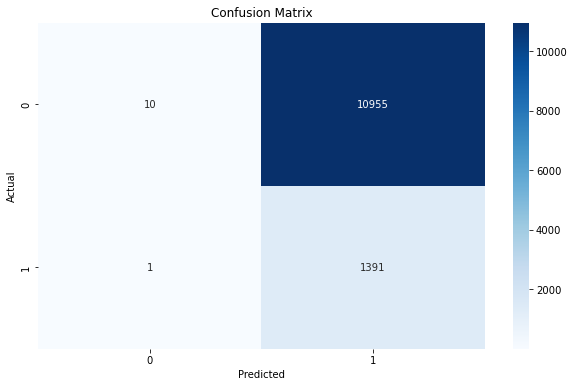

In [108]:
log_RUS_afterPCA.evaluation_metrics(X_Ptest,y_Ptest,mode = 'test')

In [109]:
@dataclass
class SoftMarginSVM:
    c:float
        
    def fit(self,X,y):
        X = X.to_numpy()
        y = y.to_numpy()
        N, n_features = X.shape
        y = np.where(y!=1,-1,1)
        Xy = X*y[:,np.newaxis]
        gramXy = np.matmul(Xy,Xy.T)
        
        
        def objectivefunction(alpha,gramXy):
            return alpha.sum() - 0.5*alpha.dot(alpha.dot(gramXy))
        
        
        def gradobjectivefunction(alpha,gramXy):
            return np.ones(N) - alpha.dot(gramXy)
        
        alphas = np.zeros(N)
        alpha_bounds = Bounds(np.zeros(N), np.ones(N)*self.c)
        
        constraints = ({'type':'eq', 'fun':lambda alpha:np.dot(alpha,y),'jac':lambda alpha: -y})
        
        with tqdm(total=5) as pbar:
            for i in range(5):
        
                slsqp = optimize.minimize(fun = lambda a: -objectivefunction(a,gramXy), x0 = alphas, jac = lambda a: -gradobjectivefunction(a,gramXy),
                                 constraints=constraints,bounds=alpha_bounds,method = 'SLSQP')
                pbar.update(1)
        
        
        self.alphas = slsqp.x
        print(self.alphas.shape)
        print(Xy.shape)
        self.w = np.sum((Xy.T.dot(self.alphas[:,np.newaxis])),axis = 1)
        print(self.w)
        epsilon = 0.001
        self.support_vectors = X[self.alphas > epsilon]
        self.support_labels = y[self.alphas > epsilon]
        
        b = []
        for i in range(len(self.support_vectors)):
            b_i = self.support_labels[i] - np.matmul(self.support_vectors[i],self.w)
            b.append(b_i)
            
            
        self.b = sum(b)/len(b)
        print(self.b)

In [187]:
X_train, X_test, y_train, y_test = train_test_split(x_rus, y_rus, test_size=0.95, random_state=42, stratify = y_rus)

In [188]:
%time
SVM_RUS_beforePCA = SoftMarginSVM(c=0.01)
SVM_RUS_beforePCA.fit(X_train,y_train)

CPU times: total: 0 ns
Wall time: 0 ns


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]C:\Users\DELL\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:57<00:00, 59.50s/it]

(464,)
(464, 33)
[ 2.20236326e-02  2.06770899e-02  9.63571465e-03  1.63385931e-03
 -9.99999988e-03 -8.74143369e-03 -3.68029036e-03  0.00000000e+00
 -9.69479867e-05 -1.16950331e-02  1.33813755e-02 -1.43070098e-02
  1.37723607e-02 -1.28887207e-03  3.90124112e-03  5.83480969e-03
 -3.22244063e-03  1.06133493e-01  2.32135915e-02  1.23053413e-01
 -1.95663120e-01 -2.06712096e-02 -6.84089836e-03 -9.26419691e-03
 -5.07193628e-02  5.94653314e-02 -2.07286904e-01  1.68914260e-02
 -1.63193191e-04 -3.26849880e-03 -5.96795116e-04 -9.44255398e-02
 -1.36571596e-02]
-0.03804862518906646


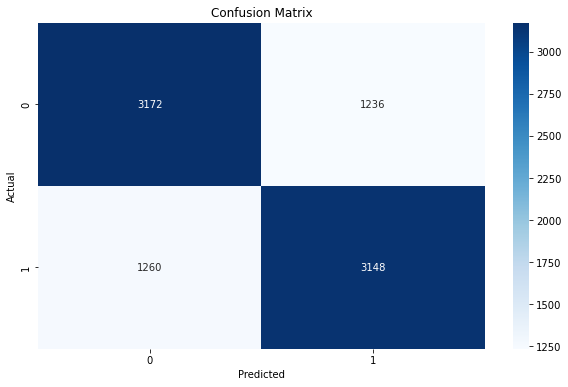

Values
Metrics                                        
Accuracy                               0.716878
Error rate                             0.283122
Sensitivity/Recall/True Positive Rate  0.714156
False Negative Rate                    0.285844
Specificity/True Negative Rate         0.719601
F1 score                               0.716868

In [189]:
y_pred = np.sign(np.add(np.matmul(X_test,SVM_RUS_beforePCA.w),SVM_RUS_beforePCA.b))
y_pred = np.where(y_pred==-1,0,1)
Confusion_Matrix(y_test,y_pred)

### QDA

In [112]:
class LDAQDA:
    def __init__(self, X,y,method='LDA'):
      self.method = method
      self.prior = None
      self.means = None
      self.covs = None
      self.classes = None
      self.X = X.to_numpy()
      self.y = y.to_numpy()

        # Load the dataset from a CSV file
    '''data = pd.read_csv('/bank-additional-full.csv')

    # Extract the features and labels
    X = data.iloc[:, :-1].values  # Features
    y = data.iloc[:, -1].values   # Labels

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
'''

    def fit(self):
      self.classes = np.unique(self.y)
      self.prior = np.zeros(len(self.classes))
      self.means = np.zeros((len(self.classes), self.X.shape[1]))
      self.covs = []

      for i, c in enumerate(self.classes):
          X_c = self.X[self.y == c]
          self.prior[i] = X_c.shape[0] / self.X.shape[0]
          self.means[i] = np.mean(X_c, axis=0)
          self.covs.append(np.cov(X_c.T))

      self.covs = np.array(self.covs)


    def predict(self, X_test):
      X_test = X_test.to_numpy()
      if self.classes is None:
        raise ValueError("The model has not been trained yet.")
      preds = np.zeros(X_test.shape[0])

      for i in range(X_test.shape[0]):
        posteriors = []
        for j, c in enumerate(self.classes):
          mean_diff = X_test[i] - self.means[j]
          if self.method == 'LDA':
            exponent = -0.5 * np.dot(np.dot(mean_diff, np.linalg.inv(np.cov(X_test.T))), mean_diff.T)
          elif self.method == 'QDA':
            try:
                cov_inv = np.linalg.inv(self.covs[j])
            except:
                cov_inv = np.eye(self.covs[j].shape[0],dtype=float)
            exponent = -0.5 * np.dot(np.dot(mean_diff, cov_inv), mean_diff.T)
            exponent = np.exp(exponent)/(np.linalg.det(self.covs[j]))
          else:
            raise ValueError("Invalid method specified. Choose 'LDA' or 'QDA'.")

          #likelihood = multivariate_normal.pdf(X_test[i], mean=self.means[j], cov=self.covs[j])
          posterior = exponent * self.prior[j]
          posteriors.append(posterior)
          '''
          likelihood = multivariate_normal.pdf(X_test[i], mean=self.means[j], cov=self.covs[j])
          posterior = likelihood * self.prior[j]
          posteriors.append(posterior)
          '''

        preds[i] = self.classes[np.argmax(posteriors)]

      return preds

In [113]:
X = df_afterPCA.drop('y',axis =1)
y = df_afterPCA['y']
X_Ptrain, X_Ptest, y_Ptrain, y_Ptest = train_test_split(X,y,test_size=0.3,random_state=24,stratify=y)
X_Ptrain.shape, X_Ptest.shape, y_Ptrain.shape, y_Ptest.shape


((28831, 33), (12357, 33), (28831,), (12357,))

In [114]:
%time
QDA = LDAQDA(X_Ptrain,y_Ptrain,method='QDA')
QDA.fit()

CPU times: total: 0 ns
Wall time: 0 ns


In [115]:
QDA.covs[1].shape

(33, 33)

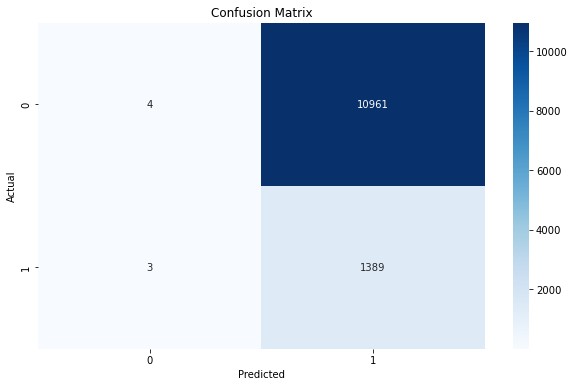

Values
Metrics                                        
Accuracy                               0.112730
Error rate                             0.887270
Sensitivity/Recall/True Positive Rate  0.997845
False Negative Rate                    0.002155
Specificity/True Negative Rate         0.000365
F1 score                               0.000729

In [116]:
y_pred = QDA.predict(X_Ptest)
Confusion_Matrix(y_Ptest,y_pred.astype('int32'))

In [117]:
dfn = x_rus
X = dfn
y = y_rus

# Create train-test split with 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the training and testing data
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (7424, 33)
X_test shape: (1856, 33)
y_train shape: (7424,)
y_test shape: (1856,)


In [118]:
%time
epochs_list = [10, 20, 30, 40, 50,100, 200]
optimizer_list = ['adam', 'rmsprop', 'SGD']
model_list = []
for epoch in epochs_list:
    for optimizer in optimizer_list:
        modeln = Sequential()
        modeln.add(Dense(20, input_shape=(X_train.shape[1],), activation='relu')) # layer 1
        modeln.add(Dense(10, activation='tanh'))  # layer 2
        modeln.add(Dense(1, activation='sigmoid'))  # layer 3

        # Compile the model
        modeln.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy',"AUC", "Recall", "Precision"])

        # Train the model
        nn = modeln.fit(X_train, y_train, epochs=epoch, validation_split=0.2, verbose=1)
        
        model_list.append(nn)

CPU times: total: 0 ns
Wall time: 0 ns
Epoch 1/10
186/186 [==============================] - 2s 4ms/step - loss: 0.6383 - accuracy: 0.5999 - auc: 0.5875 - recall: 0.2105 - precision: 0.9353 - val_loss: 0.6317 - val_accuracy: 0.6007 - val_auc: 0.6010 - val_recall: 0.2127 - val_precision: 0.9518
Epoch 2/10
186/186 [==============================] - 1s 4ms/step - loss: 0.6356 - accuracy: 0.5999 - auc: 0.5951 - recall: 0.2105 - precision: 0.9353 - val_loss: 0.6311 - val_accuracy: 0.6013 - val_auc: 0.6020 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 3/10
186/186 [==============================] - 0s 3ms/step - loss: 0.6348 - accuracy: 0.6001 - auc: 0.5921 - recall: 0.2098 - precision: 0.9394 - val_loss: 0.6301 - val_accuracy: 0.6013 - val_auc: 0.6023 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 4/10
186/186 [==============================] - 0s 2ms/step - loss: 0.6336 - accuracy: 0.5999 - auc: 0.5918 - recall: 0.2095 - precision: 0.9393 - val_loss: 0.6299 - val_accuracy: 0.6013 

Epoch 3/20
186/186 [==============================] - 0s 2ms/step - loss: 0.5741 - accuracy: 0.7170 - auc: 0.7382 - recall: 0.7124 - precision: 0.7170 - val_loss: 0.5840 - val_accuracy: 0.6990 - val_auc: 0.7292 - val_recall: 0.6851 - val_precision: 0.7050
Epoch 4/20
186/186 [==============================] - 0s 3ms/step - loss: 0.5726 - accuracy: 0.7173 - auc: 0.7357 - recall: 0.7066 - precision: 0.7200 - val_loss: 0.6377 - val_accuracy: 0.6498 - val_auc: 0.6677 - val_recall: 0.3351 - val_precision: 0.9055
Epoch 5/20
186/186 [==============================] - 0s 2ms/step - loss: 0.5755 - accuracy: 0.7143 - auc: 0.7342 - recall: 0.6870 - precision: 0.7245 - val_loss: 0.5812 - val_accuracy: 0.7024 - val_auc: 0.7314 - val_recall: 0.6972 - val_precision: 0.7048
Epoch 6/20
186/186 [==============================] - 1s 4ms/step - loss: 0.5701 - accuracy: 0.7196 - auc: 0.7391 - recall: 0.7164 - precision: 0.7191 - val_loss: 0.5810 - val_accuracy: 0.7030 - val_auc: 0.7319 - val_recall: 0.7012 

Epoch 15/20
186/186 [==============================] - 1s 3ms/step - loss: 0.6350 - accuracy: 0.6001 - auc: 0.5954 - recall: 0.2098 - precision: 0.9394 - val_loss: 0.6319 - val_accuracy: 0.6013 - val_auc: 0.6018 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 16/20
186/186 [==============================] - 0s 2ms/step - loss: 0.6348 - accuracy: 0.6001 - auc: 0.5938 - recall: 0.2098 - precision: 0.9394 - val_loss: 0.6317 - val_accuracy: 0.6013 - val_auc: 0.6018 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 17/20
186/186 [==============================] - 1s 3ms/step - loss: 0.6346 - accuracy: 0.6001 - auc: 0.5827 - recall: 0.2098 - precision: 0.9394 - val_loss: 0.6315 - val_accuracy: 0.6013 - val_auc: 0.6023 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 18/20
186/186 [==============================] - 0s 2ms/step - loss: 0.6347 - accuracy: 0.6001 - auc: 0.5866 - recall: 0.2098 - precision: 0.9394 - val_loss: 0.6315 - val_accuracy: 0.6013 - val_auc: 0.6015 - val_recall: 0.2

Epoch 7/30
186/186 [==============================] - 0s 2ms/step - loss: 0.5712 - accuracy: 0.7196 - auc: 0.7382 - recall: 0.7168 - precision: 0.7189 - val_loss: 0.5801 - val_accuracy: 0.7030 - val_auc: 0.7311 - val_recall: 0.7012 - val_precision: 0.7041
Epoch 8/30
186/186 [==============================] - 0s 2ms/step - loss: 0.5705 - accuracy: 0.7196 - auc: 0.7421 - recall: 0.7168 - precision: 0.7189 - val_loss: 0.5814 - val_accuracy: 0.7030 - val_auc: 0.7296 - val_recall: 0.7012 - val_precision: 0.7041
Epoch 9/30
186/186 [==============================] - 0s 2ms/step - loss: 0.5693 - accuracy: 0.7200 - auc: 0.7412 - recall: 0.7164 - precision: 0.7196 - val_loss: 0.5819 - val_accuracy: 0.7030 - val_auc: 0.7288 - val_recall: 0.7012 - val_precision: 0.7041
Epoch 10/30
186/186 [==============================] - 0s 2ms/step - loss: 0.5690 - accuracy: 0.7196 - auc: 0.7400 - recall: 0.7164 - precision: 0.7191 - val_loss: 0.5824 - val_accuracy: 0.7030 - val_auc: 0.7282 - val_recall: 0.7012

Epoch 9/30
186/186 [==============================] - 0s 2ms/step - loss: 0.5831 - accuracy: 0.7196 - auc: 0.7427 - recall: 0.7164 - precision: 0.7191 - val_loss: 0.5860 - val_accuracy: 0.7030 - val_auc: 0.7313 - val_recall: 0.7012 - val_precision: 0.7041
Epoch 10/30
186/186 [==============================] - 0s 2ms/step - loss: 0.5769 - accuracy: 0.7196 - auc: 0.7439 - recall: 0.7164 - precision: 0.7191 - val_loss: 0.5858 - val_accuracy: 0.7030 - val_auc: 0.7313 - val_recall: 0.7012 - val_precision: 0.7041
Epoch 11/30
186/186 [==============================] - 0s 2ms/step - loss: 0.5738 - accuracy: 0.7196 - auc: 0.7411 - recall: 0.7164 - precision: 0.7191 - val_loss: 0.5827 - val_accuracy: 0.7030 - val_auc: 0.7312 - val_recall: 0.7012 - val_precision: 0.7041
Epoch 12/30
186/186 [==============================] - 0s 2ms/step - loss: 0.5726 - accuracy: 0.7196 - auc: 0.7397 - recall: 0.7164 - precision: 0.7191 - val_loss: 0.5835 - val_accuracy: 0.7030 - val_auc: 0.7313 - val_recall: 0.70

Epoch 11/30
186/186 [==============================] - 1s 4ms/step - loss: 0.6346 - accuracy: 0.6003 - auc: 0.5870 - recall: 0.2098 - precision: 0.9408 - val_loss: 0.6314 - val_accuracy: 0.6013 - val_auc: 0.6024 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 12/30
186/186 [==============================] - 1s 3ms/step - loss: 0.6343 - accuracy: 0.6003 - auc: 0.5907 - recall: 0.2102 - precision: 0.9395 - val_loss: 0.6312 - val_accuracy: 0.6013 - val_auc: 0.6023 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 13/30
186/186 [==============================] - 0s 2ms/step - loss: 0.6342 - accuracy: 0.6001 - auc: 0.5878 - recall: 0.2098 - precision: 0.9394 - val_loss: 0.6312 - val_accuracy: 0.6013 - val_auc: 0.6018 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 14/30
186/186 [==============================] - 0s 2ms/step - loss: 0.6341 - accuracy: 0.6003 - auc: 0.5835 - recall: 0.2102 - precision: 0.9395 - val_loss: 0.6310 - val_accuracy: 0.6013 - val_auc: 0.6012 - val_recall: 0.2

Epoch 13/40
186/186 [==============================] - 0s 2ms/step - loss: 0.5789 - accuracy: 0.7196 - auc: 0.7406 - recall: 0.7164 - precision: 0.7191 - val_loss: 0.5849 - val_accuracy: 0.7030 - val_auc: 0.7311 - val_recall: 0.7012 - val_precision: 0.7041
Epoch 14/40
186/186 [==============================] - 0s 2ms/step - loss: 0.5747 - accuracy: 0.7196 - auc: 0.7387 - recall: 0.7164 - precision: 0.7191 - val_loss: 0.5835 - val_accuracy: 0.7030 - val_auc: 0.7312 - val_recall: 0.7012 - val_precision: 0.7041
Epoch 15/40
186/186 [==============================] - 0s 2ms/step - loss: 0.5730 - accuracy: 0.7195 - auc: 0.7422 - recall: 0.7164 - precision: 0.7188 - val_loss: 0.5826 - val_accuracy: 0.7030 - val_auc: 0.7311 - val_recall: 0.7012 - val_precision: 0.7041
Epoch 16/40
186/186 [==============================] - 0s 2ms/step - loss: 0.5711 - accuracy: 0.7196 - auc: 0.7458 - recall: 0.7174 - precision: 0.7186 - val_loss: 0.5832 - val_accuracy: 0.7024 - val_auc: 0.7311 - val_recall: 0.7

Epoch 5/40
186/186 [==============================] - 0s 2ms/step - loss: 0.5760 - accuracy: 0.7178 - auc: 0.7420 - recall: 0.7022 - precision: 0.7227 - val_loss: 0.5802 - val_accuracy: 0.7030 - val_auc: 0.7314 - val_recall: 0.7012 - val_precision: 0.7041
Epoch 6/40
186/186 [==============================] - 1s 3ms/step - loss: 0.5737 - accuracy: 0.7188 - auc: 0.7416 - recall: 0.7039 - precision: 0.7235 - val_loss: 0.6006 - val_accuracy: 0.6808 - val_auc: 0.7564 - val_recall: 0.4118 - val_precision: 0.8921
Epoch 7/40
186/186 [==============================] - 0s 2ms/step - loss: 0.5727 - accuracy: 0.7180 - auc: 0.7438 - recall: 0.7005 - precision: 0.7238 - val_loss: 0.5612 - val_accuracy: 0.7327 - val_auc: 0.7633 - val_recall: 0.6137 - val_precision: 0.8057
Epoch 8/40
186/186 [==============================] - 0s 2ms/step - loss: 0.5731 - accuracy: 0.7166 - auc: 0.7417 - recall: 0.7036 - precision: 0.7204 - val_loss: 0.5803 - val_accuracy: 0.7030 - val_auc: 0.7311 - val_recall: 0.7012 

Epoch 37/40
186/186 [==============================] - 1s 3ms/step - loss: 0.5655 - accuracy: 0.7090 - auc: 0.7571 - recall: 0.5932 - precision: 0.7692 - val_loss: 0.5865 - val_accuracy: 0.7030 - val_auc: 0.7403 - val_recall: 0.7012 - val_precision: 0.7041
Epoch 38/40
186/186 [==============================] - 0s 2ms/step - loss: 0.5660 - accuracy: 0.7195 - auc: 0.7534 - recall: 0.7083 - precision: 0.7225 - val_loss: 0.5718 - val_accuracy: 0.7017 - val_auc: 0.7471 - val_recall: 0.6985 - val_precision: 0.7033
Epoch 39/40
186/186 [==============================] - 0s 2ms/step - loss: 0.5619 - accuracy: 0.7190 - auc: 0.7570 - recall: 0.6931 - precision: 0.7288 - val_loss: 0.5738 - val_accuracy: 0.7010 - val_auc: 0.7441 - val_recall: 0.6918 - val_precision: 0.7051
Epoch 40/40
186/186 [==============================] - 0s 3ms/step - loss: 0.5636 - accuracy: 0.7151 - auc: 0.7563 - recall: 0.6995 - precision: 0.7200 - val_loss: 0.5663 - val_accuracy: 0.7030 - val_auc: 0.7569 - val_recall: 0.7

Epoch 29/40
186/186 [==============================] - 1s 3ms/step - loss: 0.6347 - accuracy: 0.6001 - auc: 0.5941 - recall: 0.2098 - precision: 0.9394 - val_loss: 0.6298 - val_accuracy: 0.6013 - val_auc: 0.6024 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 30/40
186/186 [==============================] - 0s 2ms/step - loss: 0.6346 - accuracy: 0.6001 - auc: 0.5974 - recall: 0.2098 - precision: 0.9394 - val_loss: 0.6301 - val_accuracy: 0.6013 - val_auc: 0.6023 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 31/40
186/186 [==============================] - 0s 2ms/step - loss: 0.6346 - accuracy: 0.6001 - auc: 0.5979 - recall: 0.2098 - precision: 0.9394 - val_loss: 0.6299 - val_accuracy: 0.6013 - val_auc: 0.6024 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 32/40
186/186 [==============================] - 0s 2ms/step - loss: 0.6344 - accuracy: 0.6001 - auc: 0.6004 - recall: 0.2098 - precision: 0.9394 - val_loss: 0.6306 - val_accuracy: 0.6013 - val_auc: 0.6023 - val_recall: 0.2

Epoch 21/50
186/186 [==============================] - 1s 4ms/step - loss: 0.6363 - accuracy: 0.5999 - auc: 0.5880 - recall: 0.2105 - precision: 0.9353 - val_loss: 0.6315 - val_accuracy: 0.6007 - val_auc: 0.6011 - val_recall: 0.2127 - val_precision: 0.9518
Epoch 22/50
186/186 [==============================] - 0s 3ms/step - loss: 0.6362 - accuracy: 0.5999 - auc: 0.5873 - recall: 0.2105 - precision: 0.9353 - val_loss: 0.6318 - val_accuracy: 0.6007 - val_auc: 0.6011 - val_recall: 0.2127 - val_precision: 0.9518
Epoch 23/50
186/186 [==============================] - 0s 2ms/step - loss: 0.6362 - accuracy: 0.5999 - auc: 0.5949 - recall: 0.2105 - precision: 0.9353 - val_loss: 0.6317 - val_accuracy: 0.6007 - val_auc: 0.6011 - val_recall: 0.2127 - val_precision: 0.9518
Epoch 24/50
186/186 [==============================] - 0s 2ms/step - loss: 0.6605 - accuracy: 0.5752 - auc: 0.5956 - recall: 0.4088 - precision: 0.6089 - val_loss: 0.6339 - val_accuracy: 0.6007 - val_auc: 0.6011 - val_recall: 0.2

Epoch 3/50
186/186 [==============================] - 0s 2ms/step - loss: 0.6429 - accuracy: 0.5998 - auc: 0.5972 - recall: 0.2098 - precision: 0.9366 - val_loss: 0.6392 - val_accuracy: 0.6007 - val_auc: 0.6011 - val_recall: 0.2127 - val_precision: 0.9518
Epoch 4/50
186/186 [==============================] - 1s 3ms/step - loss: 0.6406 - accuracy: 0.6001 - auc: 0.5790 - recall: 0.2105 - precision: 0.9367 - val_loss: 0.6360 - val_accuracy: 0.6007 - val_auc: 0.6011 - val_recall: 0.2127 - val_precision: 0.9518
Epoch 5/50
186/186 [==============================] - 1s 3ms/step - loss: 0.6389 - accuracy: 0.5999 - auc: 0.5914 - recall: 0.2105 - precision: 0.9353 - val_loss: 0.6344 - val_accuracy: 0.6007 - val_auc: 0.6011 - val_recall: 0.2127 - val_precision: 0.9518
Epoch 6/50
186/186 [==============================] - 0s 2ms/step - loss: 0.6378 - accuracy: 0.5999 - auc: 0.6001 - recall: 0.2105 - precision: 0.9353 - val_loss: 0.6338 - val_accuracy: 0.6007 - val_auc: 0.6011 - val_recall: 0.2127 

Epoch 35/50
186/186 [==============================] - 1s 3ms/step - loss: 0.5720 - accuracy: 0.7181 - auc: 0.7391 - recall: 0.7086 - precision: 0.7203 - val_loss: 0.6192 - val_accuracy: 0.6673 - val_auc: 0.6741 - val_recall: 0.3822 - val_precision: 0.8903
Epoch 36/50
186/186 [==============================] - 0s 2ms/step - loss: 0.5711 - accuracy: 0.7188 - auc: 0.7429 - recall: 0.7069 - precision: 0.7221 - val_loss: 0.5812 - val_accuracy: 0.7030 - val_auc: 0.7311 - val_recall: 0.7012 - val_precision: 0.7041
Epoch 37/50
186/186 [==============================] - 0s 3ms/step - loss: 0.5696 - accuracy: 0.7198 - auc: 0.7448 - recall: 0.7168 - precision: 0.7192 - val_loss: 0.5821 - val_accuracy: 0.7030 - val_auc: 0.7309 - val_recall: 0.7012 - val_precision: 0.7041
Epoch 38/50
186/186 [==============================] - 0s 2ms/step - loss: 0.5698 - accuracy: 0.7190 - auc: 0.7382 - recall: 0.7154 - precision: 0.7186 - val_loss: 0.5818 - val_accuracy: 0.7030 - val_auc: 0.7315 - val_recall: 0.7

Epoch 17/50
186/186 [==============================] - 1s 3ms/step - loss: 0.6341 - accuracy: 0.5999 - auc: 0.5915 - recall: 0.2105 - precision: 0.9353 - val_loss: 0.6305 - val_accuracy: 0.6007 - val_auc: 0.6014 - val_recall: 0.2127 - val_precision: 0.9518
Epoch 18/50
186/186 [==============================] - 0s 3ms/step - loss: 0.6341 - accuracy: 0.5999 - auc: 0.5885 - recall: 0.2105 - precision: 0.9353 - val_loss: 0.6304 - val_accuracy: 0.6007 - val_auc: 0.6014 - val_recall: 0.2127 - val_precision: 0.9518
Epoch 19/50
186/186 [==============================] - 0s 2ms/step - loss: 0.6341 - accuracy: 0.5999 - auc: 0.5909 - recall: 0.2105 - precision: 0.9353 - val_loss: 0.6305 - val_accuracy: 0.6007 - val_auc: 0.6014 - val_recall: 0.2127 - val_precision: 0.9518
Epoch 20/50
186/186 [==============================] - 1s 3ms/step - loss: 0.6340 - accuracy: 0.5999 - auc: 0.5961 - recall: 0.2105 - precision: 0.9353 - val_loss: 0.6302 - val_accuracy: 0.6007 - val_auc: 0.6014 - val_recall: 0.2

Epoch 49/50
186/186 [==============================] - 0s 2ms/step - loss: 0.6334 - accuracy: 0.5999 - auc: 0.6063 - recall: 0.2105 - precision: 0.9353 - val_loss: 0.6306 - val_accuracy: 0.6007 - val_auc: 0.6014 - val_recall: 0.2127 - val_precision: 0.9518
Epoch 50/50
186/186 [==============================] - 0s 2ms/step - loss: 0.6338 - accuracy: 0.5999 - auc: 0.5922 - recall: 0.2105 - precision: 0.9353 - val_loss: 0.6300 - val_accuracy: 0.6007 - val_auc: 0.6013 - val_recall: 0.2127 - val_precision: 0.9518
Epoch 1/100
186/186 [==============================] - 2s 4ms/step - loss: 0.5917 - accuracy: 0.7050 - auc: 0.7311 - recall: 0.6146 - precision: 0.7476 - val_loss: 0.5854 - val_accuracy: 0.7030 - val_auc: 0.7314 - val_recall: 0.7012 - val_precision: 0.7041
Epoch 2/100
186/186 [==============================] - 0s 2ms/step - loss: 0.5750 - accuracy: 0.7198 - auc: 0.7409 - recall: 0.7168 - precision: 0.7192 - val_loss: 0.5817 - val_accuracy: 0.7030 - val_auc: 0.7305 - val_recall: 0.7

Epoch 31/100
186/186 [==============================] - 0s 2ms/step - loss: 0.6304 - accuracy: 0.6009 - auc: 0.5939 - recall: 0.2085 - precision: 0.9521 - val_loss: 0.6311 - val_accuracy: 0.6013 - val_auc: 0.6020 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 32/100
186/186 [==============================] - 0s 2ms/step - loss: 0.6309 - accuracy: 0.6006 - auc: 0.5944 - recall: 0.2085 - precision: 0.9492 - val_loss: 0.6322 - val_accuracy: 0.5987 - val_auc: 0.6023 - val_recall: 0.2073 - val_precision: 0.9565
Epoch 33/100
186/186 [==============================] - 0s 2ms/step - loss: 0.6299 - accuracy: 0.6009 - auc: 0.6056 - recall: 0.2085 - precision: 0.9521 - val_loss: 0.6328 - val_accuracy: 0.6013 - val_auc: 0.6020 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 34/100
186/186 [==============================] - 0s 2ms/step - loss: 0.6305 - accuracy: 0.6008 - auc: 0.5974 - recall: 0.2085 - precision: 0.9506 - val_loss: 0.6310 - val_accuracy: 0.6013 - val_auc: 0.6023 - val_recall:

Epoch 63/100
186/186 [==============================] - 0s 2ms/step - loss: 0.6286 - accuracy: 0.6014 - auc: 0.6034 - recall: 0.2085 - precision: 0.9565 - val_loss: 0.6328 - val_accuracy: 0.6013 - val_auc: 0.6010 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 64/100
186/186 [==============================] - 1s 3ms/step - loss: 0.6284 - accuracy: 0.6018 - auc: 0.6109 - recall: 0.2088 - precision: 0.9581 - val_loss: 0.6335 - val_accuracy: 0.6013 - val_auc: 0.6015 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 65/100
186/186 [==============================] - 0s 2ms/step - loss: 0.6292 - accuracy: 0.6013 - auc: 0.5925 - recall: 0.2085 - precision: 0.9550 - val_loss: 0.6324 - val_accuracy: 0.6013 - val_auc: 0.6010 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 66/100
186/186 [==============================] - 0s 2ms/step - loss: 0.6287 - accuracy: 0.6016 - auc: 0.5968 - recall: 0.2091 - precision: 0.9552 - val_loss: 0.6331 - val_accuracy: 0.6007 - val_auc: 0.6011 - val_recall:

Epoch 95/100
186/186 [==============================] - 0s 3ms/step - loss: 0.6270 - accuracy: 0.6018 - auc: 0.5953 - recall: 0.2088 - precision: 0.9581 - val_loss: 0.6334 - val_accuracy: 0.6013 - val_auc: 0.6021 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 96/100
186/186 [==============================] - 1s 3ms/step - loss: 0.6270 - accuracy: 0.6021 - auc: 0.6024 - recall: 0.2095 - precision: 0.9582 - val_loss: 0.6339 - val_accuracy: 0.6013 - val_auc: 0.6015 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 97/100
186/186 [==============================] - 1s 3ms/step - loss: 0.6273 - accuracy: 0.6016 - auc: 0.5948 - recall: 0.2088 - precision: 0.9566 - val_loss: 0.6336 - val_accuracy: 0.6013 - val_auc: 0.6014 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 98/100
186/186 [==============================] - 1s 4ms/step - loss: 0.6277 - accuracy: 0.6016 - auc: 0.5923 - recall: 0.2102 - precision: 0.9510 - val_loss: 0.6332 - val_accuracy: 0.6007 - val_auc: 0.6021 - val_recall:

Epoch 27/100
186/186 [==============================] - 1s 3ms/step - loss: 0.5706 - accuracy: 0.7188 - auc: 0.7438 - recall: 0.7140 - precision: 0.7189 - val_loss: 0.5817 - val_accuracy: 0.7030 - val_auc: 0.7311 - val_recall: 0.7012 - val_precision: 0.7041
Epoch 28/100
186/186 [==============================] - 0s 2ms/step - loss: 0.5714 - accuracy: 0.7180 - auc: 0.7402 - recall: 0.7036 - precision: 0.7224 - val_loss: 0.5818 - val_accuracy: 0.7030 - val_auc: 0.7308 - val_recall: 0.7012 - val_precision: 0.7041
Epoch 29/100
186/186 [==============================] - 0s 2ms/step - loss: 0.5696 - accuracy: 0.7196 - auc: 0.7443 - recall: 0.7168 - precision: 0.7189 - val_loss: 0.5813 - val_accuracy: 0.7030 - val_auc: 0.7309 - val_recall: 0.7012 - val_precision: 0.7041
Epoch 30/100
186/186 [==============================] - 0s 3ms/step - loss: 0.5695 - accuracy: 0.7198 - auc: 0.7438 - recall: 0.7168 - precision: 0.7192 - val_loss: 0.5818 - val_accuracy: 0.7030 - val_auc: 0.7311 - val_recall:

Epoch 59/100
186/186 [==============================] - 0s 2ms/step - loss: 0.5678 - accuracy: 0.7198 - auc: 0.7446 - recall: 0.7168 - precision: 0.7192 - val_loss: 0.5811 - val_accuracy: 0.7030 - val_auc: 0.7308 - val_recall: 0.7012 - val_precision: 0.7041
Epoch 60/100
186/186 [==============================] - 0s 2ms/step - loss: 0.5683 - accuracy: 0.7198 - auc: 0.7484 - recall: 0.7168 - precision: 0.7192 - val_loss: 0.5823 - val_accuracy: 0.7030 - val_auc: 0.7308 - val_recall: 0.7012 - val_precision: 0.7041
Epoch 61/100
186/186 [==============================] - 0s 2ms/step - loss: 0.5682 - accuracy: 0.7198 - auc: 0.7442 - recall: 0.7168 - precision: 0.7192 - val_loss: 0.5835 - val_accuracy: 0.7030 - val_auc: 0.7286 - val_recall: 0.7012 - val_precision: 0.7041
Epoch 62/100
186/186 [==============================] - 0s 2ms/step - loss: 0.5679 - accuracy: 0.7198 - auc: 0.7446 - recall: 0.7168 - precision: 0.7192 - val_loss: 0.5817 - val_accuracy: 0.7030 - val_auc: 0.7308 - val_recall:

Epoch 91/100
186/186 [==============================] - 0s 2ms/step - loss: 0.5674 - accuracy: 0.7212 - auc: 0.7440 - recall: 0.7157 - precision: 0.7216 - val_loss: 0.5834 - val_accuracy: 0.7017 - val_auc: 0.7293 - val_recall: 0.6985 - val_precision: 0.7033
Epoch 92/100
186/186 [==============================] - 0s 2ms/step - loss: 0.5679 - accuracy: 0.7203 - auc: 0.7391 - recall: 0.7140 - precision: 0.7211 - val_loss: 0.5818 - val_accuracy: 0.7024 - val_auc: 0.7305 - val_recall: 0.6999 - val_precision: 0.7037
Epoch 93/100
186/186 [==============================] - 0s 2ms/step - loss: 0.5686 - accuracy: 0.7191 - auc: 0.7410 - recall: 0.7181 - precision: 0.7176 - val_loss: 0.5820 - val_accuracy: 0.7024 - val_auc: 0.7305 - val_recall: 0.6999 - val_precision: 0.7037
Epoch 94/100
186/186 [==============================] - 0s 2ms/step - loss: 0.5677 - accuracy: 0.7210 - auc: 0.7433 - recall: 0.7161 - precision: 0.7212 - val_loss: 0.5809 - val_accuracy: 0.7030 - val_auc: 0.7313 - val_recall:

Epoch 23/100
186/186 [==============================] - 0s 2ms/step - loss: 0.6323 - accuracy: 0.6001 - auc: 0.5967 - recall: 0.2095 - precision: 0.9407 - val_loss: 0.6317 - val_accuracy: 0.6007 - val_auc: 0.6009 - val_recall: 0.2113 - val_precision: 0.9573
Epoch 24/100
186/186 [==============================] - 0s 2ms/step - loss: 0.6319 - accuracy: 0.6004 - auc: 0.6015 - recall: 0.2091 - precision: 0.9450 - val_loss: 0.6314 - val_accuracy: 0.6013 - val_auc: 0.6022 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 25/100
186/186 [==============================] - 0s 2ms/step - loss: 0.6319 - accuracy: 0.6001 - auc: 0.5885 - recall: 0.2095 - precision: 0.9407 - val_loss: 0.6321 - val_accuracy: 0.5987 - val_auc: 0.6011 - val_recall: 0.2073 - val_precision: 0.9565
Epoch 26/100
186/186 [==============================] - 0s 2ms/step - loss: 0.6323 - accuracy: 0.6004 - auc: 0.5909 - recall: 0.2088 - precision: 0.9463 - val_loss: 0.6311 - val_accuracy: 0.6007 - val_auc: 0.6023 - val_recall:

Epoch 55/100
186/186 [==============================] - 0s 2ms/step - loss: 0.6316 - accuracy: 0.6006 - auc: 0.5984 - recall: 0.2085 - precision: 0.9492 - val_loss: 0.6309 - val_accuracy: 0.6013 - val_auc: 0.6024 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 56/100
186/186 [==============================] - 0s 2ms/step - loss: 0.6317 - accuracy: 0.6004 - auc: 0.5922 - recall: 0.2091 - precision: 0.9450 - val_loss: 0.6326 - val_accuracy: 0.5980 - val_auc: 0.5985 - val_recall: 0.2059 - val_precision: 0.9563
Epoch 57/100
186/186 [==============================] - 0s 2ms/step - loss: 0.6315 - accuracy: 0.6006 - auc: 0.6000 - recall: 0.2091 - precision: 0.9464 - val_loss: 0.6319 - val_accuracy: 0.6007 - val_auc: 0.6024 - val_recall: 0.2113 - val_precision: 0.9573
Epoch 58/100
186/186 [==============================] - 0s 2ms/step - loss: 0.6314 - accuracy: 0.6006 - auc: 0.5955 - recall: 0.2085 - precision: 0.9492 - val_loss: 0.6312 - val_accuracy: 0.6013 - val_auc: 0.6023 - val_recall:

Epoch 87/100
186/186 [==============================] - 1s 3ms/step - loss: 0.6317 - accuracy: 0.6004 - auc: 0.5965 - recall: 0.2078 - precision: 0.9505 - val_loss: 0.6317 - val_accuracy: 0.6007 - val_auc: 0.6024 - val_recall: 0.2113 - val_precision: 0.9573
Epoch 88/100
186/186 [==============================] - 0s 2ms/step - loss: 0.6316 - accuracy: 0.6008 - auc: 0.5895 - recall: 0.2085 - precision: 0.9506 - val_loss: 0.6323 - val_accuracy: 0.6000 - val_auc: 0.5997 - val_recall: 0.2100 - val_precision: 0.9571
Epoch 89/100
186/186 [==============================] - 0s 2ms/step - loss: 0.6312 - accuracy: 0.6013 - auc: 0.6012 - recall: 0.2095 - precision: 0.9508 - val_loss: 0.6297 - val_accuracy: 0.6013 - val_auc: 0.6023 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 90/100
186/186 [==============================] - 0s 3ms/step - loss: 0.6313 - accuracy: 0.6008 - auc: 0.5972 - recall: 0.2091 - precision: 0.9479 - val_loss: 0.6338 - val_accuracy: 0.5966 - val_auc: 0.5931 - val_recall:

Epoch 19/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6343 - accuracy: 0.6001 - auc: 0.5945 - recall: 0.2098 - precision: 0.9394 - val_loss: 0.6316 - val_accuracy: 0.6013 - val_auc: 0.6012 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 20/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6334 - accuracy: 0.6004 - auc: 0.5935 - recall: 0.2095 - precision: 0.9436 - val_loss: 0.6309 - val_accuracy: 0.6013 - val_auc: 0.6012 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 21/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6328 - accuracy: 0.6003 - auc: 0.5970 - recall: 0.2095 - precision: 0.9422 - val_loss: 0.6334 - val_accuracy: 0.5987 - val_auc: 0.6012 - val_recall: 0.2073 - val_precision: 0.9565
Epoch 22/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6325 - accuracy: 0.6006 - auc: 0.5928 - recall: 0.2098 - precision: 0.9437 - val_loss: 0.6302 - val_accuracy: 0.6013 - val_auc: 0.6012 - val_recall:

Epoch 51/200
186/186 [==============================] - 1s 3ms/step - loss: 0.6317 - accuracy: 0.6009 - auc: 0.5919 - recall: 0.2091 - precision: 0.9493 - val_loss: 0.6311 - val_accuracy: 0.6013 - val_auc: 0.6010 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 52/200
186/186 [==============================] - 1s 4ms/step - loss: 0.6317 - accuracy: 0.6013 - auc: 0.5842 - recall: 0.2088 - precision: 0.9536 - val_loss: 0.6326 - val_accuracy: 0.6000 - val_auc: 0.6012 - val_recall: 0.2100 - val_precision: 0.9571
Epoch 53/200
186/186 [==============================] - 1s 3ms/step - loss: 0.6315 - accuracy: 0.6009 - auc: 0.5931 - recall: 0.2081 - precision: 0.9535 - val_loss: 0.6321 - val_accuracy: 0.6013 - val_auc: 0.6010 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 54/200
186/186 [==============================] - 1s 3ms/step - loss: 0.6314 - accuracy: 0.6008 - auc: 0.5974 - recall: 0.2081 - precision: 0.9520 - val_loss: 0.6310 - val_accuracy: 0.6013 - val_auc: 0.6012 - val_recall:

Epoch 83/200
186/186 [==============================] - 0s 3ms/step - loss: 0.6309 - accuracy: 0.6013 - auc: 0.6016 - recall: 0.2078 - precision: 0.9579 - val_loss: 0.6310 - val_accuracy: 0.6007 - val_auc: 0.6021 - val_recall: 0.2113 - val_precision: 0.9573
Epoch 84/200
186/186 [==============================] - 0s 3ms/step - loss: 0.6316 - accuracy: 0.6011 - auc: 0.5885 - recall: 0.2081 - precision: 0.9550 - val_loss: 0.6328 - val_accuracy: 0.5987 - val_auc: 0.6010 - val_recall: 0.2073 - val_precision: 0.9565
Epoch 85/200
186/186 [==============================] - 1s 3ms/step - loss: 0.6313 - accuracy: 0.6011 - auc: 0.5924 - recall: 0.2078 - precision: 0.9564 - val_loss: 0.6308 - val_accuracy: 0.6007 - val_auc: 0.6023 - val_recall: 0.2113 - val_precision: 0.9573
Epoch 86/200
186/186 [==============================] - 0s 3ms/step - loss: 0.6333 - accuracy: 0.6013 - auc: 0.5968 - recall: 0.2081 - precision: 0.9565 - val_loss: 0.6333 - val_accuracy: 0.6007 - val_auc: 0.6016 - val_recall:

Epoch 115/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6314 - accuracy: 0.6008 - auc: 0.5915 - recall: 0.2078 - precision: 0.9534 - val_loss: 0.6316 - val_accuracy: 0.6007 - val_auc: 0.6023 - val_recall: 0.2113 - val_precision: 0.9573
Epoch 116/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6310 - accuracy: 0.6013 - auc: 0.5916 - recall: 0.2081 - precision: 0.9565 - val_loss: 0.6317 - val_accuracy: 0.6007 - val_auc: 0.6023 - val_recall: 0.2113 - val_precision: 0.9573
Epoch 117/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6308 - accuracy: 0.6014 - auc: 0.5932 - recall: 0.2078 - precision: 0.9594 - val_loss: 0.6315 - val_accuracy: 0.6007 - val_auc: 0.6023 - val_recall: 0.2113 - val_precision: 0.9573
Epoch 118/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6307 - accuracy: 0.6013 - auc: 0.5920 - recall: 0.2088 - precision: 0.9536 - val_loss: 0.6310 - val_accuracy: 0.6013 - val_auc: 0.6023 - val_rec

Epoch 147/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6305 - accuracy: 0.6014 - auc: 0.6015 - recall: 0.2081 - precision: 0.9579 - val_loss: 0.6311 - val_accuracy: 0.6013 - val_auc: 0.6021 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 148/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6305 - accuracy: 0.6014 - auc: 0.5966 - recall: 0.2081 - precision: 0.9579 - val_loss: 0.6317 - val_accuracy: 0.6000 - val_auc: 0.6021 - val_recall: 0.2100 - val_precision: 0.9571
Epoch 149/200
186/186 [==============================] - 1s 4ms/step - loss: 0.6301 - accuracy: 0.6016 - auc: 0.6010 - recall: 0.2081 - precision: 0.9594 - val_loss: 0.6313 - val_accuracy: 0.6013 - val_auc: 0.6021 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 150/200
186/186 [==============================] - 1s 3ms/step - loss: 0.6298 - accuracy: 0.6016 - auc: 0.6029 - recall: 0.2081 - precision: 0.9594 - val_loss: 0.6317 - val_accuracy: 0.6013 - val_auc: 0.6021 - val_rec

Epoch 179/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6290 - accuracy: 0.6025 - auc: 0.5954 - recall: 0.2095 - precision: 0.9612 - val_loss: 0.6307 - val_accuracy: 0.6013 - val_auc: 0.6021 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 180/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6291 - accuracy: 0.6023 - auc: 0.6006 - recall: 0.2088 - precision: 0.9626 - val_loss: 0.6315 - val_accuracy: 0.6007 - val_auc: 0.6008 - val_recall: 0.2113 - val_precision: 0.9573
Epoch 181/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6289 - accuracy: 0.6025 - auc: 0.5934 - recall: 0.2095 - precision: 0.9612 - val_loss: 0.6309 - val_accuracy: 0.6013 - val_auc: 0.6021 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 182/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6290 - accuracy: 0.6026 - auc: 0.5900 - recall: 0.2095 - precision: 0.9627 - val_loss: 0.6304 - val_accuracy: 0.6013 - val_auc: 0.6021 - val_rec

Epoch 11/200
186/186 [==============================] - 0s 2ms/step - loss: 0.5764 - accuracy: 0.7200 - auc: 0.7423 - recall: 0.7151 - precision: 0.7202 - val_loss: 0.5814 - val_accuracy: 0.7030 - val_auc: 0.7313 - val_recall: 0.7012 - val_precision: 0.7041
Epoch 12/200
186/186 [==============================] - 0s 2ms/step - loss: 0.5784 - accuracy: 0.7146 - auc: 0.7362 - recall: 0.6731 - precision: 0.7318 - val_loss: 0.6063 - val_accuracy: 0.6673 - val_auc: 0.6713 - val_recall: 0.3822 - val_precision: 0.8903
Epoch 13/200
186/186 [==============================] - 0s 2ms/step - loss: 0.5952 - accuracy: 0.6786 - auc: 0.6848 - recall: 0.4179 - precision: 0.8673 - val_loss: 0.5894 - val_accuracy: 0.7030 - val_auc: 0.7315 - val_recall: 0.7012 - val_precision: 0.7041
Epoch 14/200
186/186 [==============================] - 0s 2ms/step - loss: 0.5712 - accuracy: 0.7198 - auc: 0.7426 - recall: 0.7168 - precision: 0.7192 - val_loss: 0.5816 - val_accuracy: 0.7030 - val_auc: 0.7315 - val_recall:

Epoch 43/200
186/186 [==============================] - 0s 2ms/step - loss: 0.5619 - accuracy: 0.7203 - auc: 0.7574 - recall: 0.7164 - precision: 0.7201 - val_loss: 0.5798 - val_accuracy: 0.6990 - val_auc: 0.7398 - val_recall: 0.6931 - val_precision: 0.7016
Epoch 44/200
186/186 [==============================] - 0s 2ms/step - loss: 0.5712 - accuracy: 0.7198 - auc: 0.7507 - recall: 0.7157 - precision: 0.7196 - val_loss: 0.5849 - val_accuracy: 0.6990 - val_auc: 0.7286 - val_recall: 0.6931 - val_precision: 0.7016
Epoch 45/200
186/186 [==============================] - 0s 2ms/step - loss: 0.5790 - accuracy: 0.7190 - auc: 0.7450 - recall: 0.7154 - precision: 0.7186 - val_loss: 0.5871 - val_accuracy: 0.7003 - val_auc: 0.7328 - val_recall: 0.6958 - val_precision: 0.7024
Epoch 46/200
186/186 [==============================] - 0s 2ms/step - loss: 0.5769 - accuracy: 0.7207 - auc: 0.7521 - recall: 0.7161 - precision: 0.7207 - val_loss: 0.6818 - val_accuracy: 0.7024 - val_auc: 0.7004 - val_recall:

Epoch 75/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6062 - accuracy: 0.6831 - auc: 0.6767 - recall: 0.4420 - precision: 0.8486 - val_loss: 0.6271 - val_accuracy: 0.7030 - val_auc: 0.7026 - val_recall: 0.7012 - val_precision: 0.7041
Epoch 76/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6015 - accuracy: 0.7099 - auc: 0.7152 - recall: 0.6487 - precision: 0.7367 - val_loss: 0.6167 - val_accuracy: 0.6660 - val_auc: 0.6665 - val_recall: 0.3795 - val_precision: 0.8896
Epoch 77/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6010 - accuracy: 0.6922 - auc: 0.6950 - recall: 0.4917 - precision: 0.8168 - val_loss: 0.6205 - val_accuracy: 0.7030 - val_auc: 0.7030 - val_recall: 0.7012 - val_precision: 0.7041
Epoch 78/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6012 - accuracy: 0.7087 - auc: 0.7158 - recall: 0.6318 - precision: 0.7441 - val_loss: 0.6098 - val_accuracy: 0.7030 - val_auc: 0.7024 - val_recall:

Epoch 107/200
186/186 [==============================] - 0s 3ms/step - loss: 0.5957 - accuracy: 0.7191 - auc: 0.7148 - recall: 0.6860 - precision: 0.7326 - val_loss: 0.6103 - val_accuracy: 0.7030 - val_auc: 0.7026 - val_recall: 0.7012 - val_precision: 0.7041
Epoch 108/200
186/186 [==============================] - 0s 2ms/step - loss: 0.5930 - accuracy: 0.7203 - auc: 0.7158 - recall: 0.7130 - precision: 0.7216 - val_loss: 0.6097 - val_accuracy: 0.7030 - val_auc: 0.7028 - val_recall: 0.7012 - val_precision: 0.7041
Epoch 109/200
186/186 [==============================] - 1s 5ms/step - loss: 0.5916 - accuracy: 0.7212 - auc: 0.7136 - recall: 0.6937 - precision: 0.7319 - val_loss: 0.6094 - val_accuracy: 0.7030 - val_auc: 0.7032 - val_recall: 0.7012 - val_precision: 0.7041
Epoch 110/200
186/186 [==============================] - 1s 4ms/step - loss: 0.5950 - accuracy: 0.7161 - auc: 0.7237 - recall: 0.6687 - precision: 0.7365 - val_loss: 0.6092 - val_accuracy: 0.7030 - val_auc: 0.7022 - val_rec

Epoch 139/200
186/186 [==============================] - 0s 2ms/step - loss: 0.5917 - accuracy: 0.7213 - auc: 0.7194 - recall: 0.7161 - precision: 0.7217 - val_loss: 0.6093 - val_accuracy: 0.7030 - val_auc: 0.7024 - val_recall: 0.7012 - val_precision: 0.7041
Epoch 140/200
186/186 [==============================] - 0s 2ms/step - loss: 0.5909 - accuracy: 0.7223 - auc: 0.7208 - recall: 0.7134 - precision: 0.7244 - val_loss: 0.6093 - val_accuracy: 0.7030 - val_auc: 0.7024 - val_recall: 0.7012 - val_precision: 0.7041
Epoch 141/200
186/186 [==============================] - 0s 2ms/step - loss: 0.5918 - accuracy: 0.7203 - auc: 0.7236 - recall: 0.6856 - precision: 0.7346 - val_loss: 0.6093 - val_accuracy: 0.7030 - val_auc: 0.7020 - val_recall: 0.7012 - val_precision: 0.7041
Epoch 142/200
186/186 [==============================] - 0s 2ms/step - loss: 0.5925 - accuracy: 0.7207 - auc: 0.7207 - recall: 0.7127 - precision: 0.7222 - val_loss: 0.6092 - val_accuracy: 0.7030 - val_auc: 0.7025 - val_rec

Epoch 171/200
186/186 [==============================] - 0s 2ms/step - loss: 0.5918 - accuracy: 0.7213 - auc: 0.7193 - recall: 0.7144 - precision: 0.7225 - val_loss: 0.6092 - val_accuracy: 0.7030 - val_auc: 0.7020 - val_recall: 0.7012 - val_precision: 0.7041
Epoch 172/200
186/186 [==============================] - 0s 2ms/step - loss: 0.5914 - accuracy: 0.7218 - auc: 0.7161 - recall: 0.7168 - precision: 0.7221 - val_loss: 0.6107 - val_accuracy: 0.7010 - val_auc: 0.7009 - val_recall: 0.6972 - val_precision: 0.7028
Epoch 173/200
186/186 [==============================] - 0s 2ms/step - loss: 0.5913 - accuracy: 0.7217 - auc: 0.7168 - recall: 0.7137 - precision: 0.7233 - val_loss: 0.6099 - val_accuracy: 0.7024 - val_auc: 0.7018 - val_recall: 0.6999 - val_precision: 0.7037
Epoch 174/200
186/186 [==============================] - 0s 2ms/step - loss: 0.5917 - accuracy: 0.7212 - auc: 0.7157 - recall: 0.7157 - precision: 0.7216 - val_loss: 0.6093 - val_accuracy: 0.7030 - val_auc: 0.7018 - val_rec

Epoch 3/200
186/186 [==============================] - 0s 3ms/step - loss: 0.6365 - accuracy: 0.6003 - auc: 0.5899 - recall: 0.2105 - precision: 0.9382 - val_loss: 0.6317 - val_accuracy: 0.6013 - val_auc: 0.6012 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 4/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6361 - accuracy: 0.6004 - auc: 0.5981 - recall: 0.2105 - precision: 0.9396 - val_loss: 0.6319 - val_accuracy: 0.6013 - val_auc: 0.6012 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 5/200
186/186 [==============================] - 0s 3ms/step - loss: 0.6362 - accuracy: 0.6003 - auc: 0.5869 - recall: 0.2105 - precision: 0.9382 - val_loss: 0.6312 - val_accuracy: 0.6013 - val_auc: 0.6018 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 6/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6359 - accuracy: 0.6003 - auc: 0.5960 - recall: 0.2102 - precision: 0.9395 - val_loss: 0.6310 - val_accuracy: 0.6013 - val_auc: 0.6023 - val_recall: 0.2

Epoch 35/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6348 - accuracy: 0.6003 - auc: 0.5848 - recall: 0.2102 - precision: 0.9395 - val_loss: 0.6297 - val_accuracy: 0.6013 - val_auc: 0.6024 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 36/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6347 - accuracy: 0.6003 - auc: 0.5876 - recall: 0.2098 - precision: 0.9408 - val_loss: 0.6297 - val_accuracy: 0.6013 - val_auc: 0.6024 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 37/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6347 - accuracy: 0.6004 - auc: 0.5916 - recall: 0.2102 - precision: 0.9409 - val_loss: 0.6297 - val_accuracy: 0.6013 - val_auc: 0.6025 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 38/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6347 - accuracy: 0.6003 - auc: 0.5943 - recall: 0.2098 - precision: 0.9408 - val_loss: 0.6297 - val_accuracy: 0.6013 - val_auc: 0.6024 - val_recall:

Epoch 67/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6342 - accuracy: 0.6003 - auc: 0.5902 - recall: 0.2098 - precision: 0.9408 - val_loss: 0.6293 - val_accuracy: 0.6013 - val_auc: 0.6024 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 68/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6340 - accuracy: 0.6003 - auc: 0.5989 - recall: 0.2098 - precision: 0.9408 - val_loss: 0.6295 - val_accuracy: 0.6013 - val_auc: 0.6024 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 69/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6336 - accuracy: 0.6003 - auc: 0.6107 - recall: 0.2098 - precision: 0.9408 - val_loss: 0.6307 - val_accuracy: 0.6013 - val_auc: 0.6024 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 70/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6343 - accuracy: 0.6003 - auc: 0.5910 - recall: 0.2098 - precision: 0.9408 - val_loss: 0.6293 - val_accuracy: 0.6013 - val_auc: 0.6024 - val_recall:

Epoch 99/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6337 - accuracy: 0.6003 - auc: 0.5949 - recall: 0.2098 - precision: 0.9408 - val_loss: 0.6292 - val_accuracy: 0.6013 - val_auc: 0.6024 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 100/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6337 - accuracy: 0.6003 - auc: 0.5975 - recall: 0.2098 - precision: 0.9408 - val_loss: 0.6296 - val_accuracy: 0.6013 - val_auc: 0.6024 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 101/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6338 - accuracy: 0.6004 - auc: 0.5931 - recall: 0.2102 - precision: 0.9409 - val_loss: 0.6291 - val_accuracy: 0.6013 - val_auc: 0.6024 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 102/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6337 - accuracy: 0.6003 - auc: 0.5926 - recall: 0.2098 - precision: 0.9408 - val_loss: 0.6292 - val_accuracy: 0.6013 - val_auc: 0.6024 - val_reca

Epoch 131/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6336 - accuracy: 0.6003 - auc: 0.5810 - recall: 0.2098 - precision: 0.9408 - val_loss: 0.6292 - val_accuracy: 0.6013 - val_auc: 0.6024 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 132/200
186/186 [==============================] - 0s 3ms/step - loss: 0.6335 - accuracy: 0.6003 - auc: 0.5955 - recall: 0.2098 - precision: 0.9408 - val_loss: 0.6290 - val_accuracy: 0.6013 - val_auc: 0.6024 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 133/200
186/186 [==============================] - 1s 3ms/step - loss: 0.6336 - accuracy: 0.6003 - auc: 0.5900 - recall: 0.2098 - precision: 0.9408 - val_loss: 0.6291 - val_accuracy: 0.6013 - val_auc: 0.6024 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 134/200
186/186 [==============================] - 1s 3ms/step - loss: 0.6335 - accuracy: 0.6003 - auc: 0.5971 - recall: 0.2098 - precision: 0.9408 - val_loss: 0.6291 - val_accuracy: 0.6013 - val_auc: 0.6024 - val_rec

Epoch 163/200
186/186 [==============================] - 0s 3ms/step - loss: 0.6335 - accuracy: 0.6003 - auc: 0.5886 - recall: 0.2098 - precision: 0.9408 - val_loss: 0.6291 - val_accuracy: 0.6013 - val_auc: 0.6024 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 164/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6334 - accuracy: 0.6003 - auc: 0.5887 - recall: 0.2098 - precision: 0.9408 - val_loss: 0.6290 - val_accuracy: 0.6013 - val_auc: 0.6024 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 165/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6334 - accuracy: 0.6003 - auc: 0.5886 - recall: 0.2098 - precision: 0.9408 - val_loss: 0.6290 - val_accuracy: 0.6013 - val_auc: 0.6024 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 166/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6333 - accuracy: 0.6003 - auc: 0.5949 - recall: 0.2098 - precision: 0.9408 - val_loss: 0.6291 - val_accuracy: 0.6013 - val_auc: 0.6024 - val_rec

Epoch 195/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6332 - accuracy: 0.6003 - auc: 0.5984 - recall: 0.2098 - precision: 0.9408 - val_loss: 0.6290 - val_accuracy: 0.6013 - val_auc: 0.6024 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 196/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6333 - accuracy: 0.6003 - auc: 0.5887 - recall: 0.2098 - precision: 0.9408 - val_loss: 0.6291 - val_accuracy: 0.6013 - val_auc: 0.6024 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 197/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6333 - accuracy: 0.6003 - auc: 0.5917 - recall: 0.2098 - precision: 0.9408 - val_loss: 0.6294 - val_accuracy: 0.6013 - val_auc: 0.6024 - val_recall: 0.2127 - val_precision: 0.9576
Epoch 198/200
186/186 [==============================] - 1s 3ms/step - loss: 0.6334 - accuracy: 0.6003 - auc: 0.5886 - recall: 0.2098 - precision: 0.9408 - val_loss: 0.6295 - val_accuracy: 0.6013 - val_auc: 0.6024 - val_rec

In [119]:
%time
metrics_list = [modeln.evaluate(X_test, y_test) for model in model_list]
results_df = pd.DataFrame({
    "Model": model_list,
    "Metrics": metrics_list
})

results_df["Accuracy"] = results_df["Metrics"].apply(lambda x: x[0])
results_df["AUC"] = results_df["Metrics"].apply(lambda x: x[1])
results_df["Recall"] = results_df["Metrics"].apply(lambda x: x[2])
results_df["Precision"] = results_df["Metrics"].apply(lambda x: x[3])

CPU times: total: 0 ns
Wall time: 0 ns
58/58 [==============================] - 0s 3ms/step - loss: 0.6341 - accuracy: 0.5894 - auc: 0.5963 - recall: 0.1985 - precision: 0.9639 


In [120]:
results_df = results_df.sort_values(by=["AUC"], ascending = False)
results_df

Model  \
0   <keras.callbacks.History object at 0x000001CDB...   
11  <keras.callbacks.History object at 0x000001CDC...   
19  <keras.callbacks.History object at 0x000001CDC...   
18  <keras.callbacks.History object at 0x000001CDC...   
17  <keras.callbacks.History object at 0x000001CDC...   
16  <keras.callbacks.History object at 0x000001CDB...   
15  <keras.callbacks.History object at 0x000001CDB...   
14  <keras.callbacks.History object at 0x000001CDC...   
13  <keras.callbacks.History object at 0x000001CDC...   
12  <keras.callbacks.History object at 0x000001CDC...   
10  <keras.callbacks.History object at 0x000001CDC...   
1   <keras.callbacks.History object at 0x000001CDC...   
9   <keras.callbacks.History object at 0x000001CDC...   
8   <keras.callbacks.History object at 0x000001CDC...   
7   <keras.callbacks.History object at 0x000001CDC...   
6   <keras.callbacks.History object at 0x000001CDC...   
5   <keras.callbacks.History object at 0x000001CDB...   
4   <keras.callbacks.History object at 0x000001CDB...   
3   <keras.callbacks.History object at 0x000001CDC...   
2   <keras.callbacks.History object at 0x000001CDC...   
20  <keras.callbacks.History object at 0x000001CDC...   

                                              Metrics  Accuracy      AUC  \
0   [0.6340636610984802, 0.5894396305084229, 0.596...  0.634064  0.58944   
11  [0.6340636610984802, 0.5894396305084229, 0.596...  0.634064  0.58944   
19  [0.6340636610984802, 0.5894396305084229, 0.596...  0.634064  0.58944   
18  [0.6340636610984802, 0.5894396305084229, 0.596...  0.634064  0.58944   
17  [0.6340636610984802, 0.5894396305084229, 0.596...  0.634064  0.58944   
16  [0.6340636610984802, 0.5894396305084229, 0.596...  0.634064  0.58944   
15  [0.6340636610984802, 0.5894396305084229, 0.596...  0.634064  0.58944   
14  [0.6340636610984802, 0.5894396305084229, 0.596...  0.634064  0.58944   
13  [0.6340636610984802, 0.5894396305084229, 0.596...  0.634064  0.58944   
12  [0.6340636610984802, 0.5894396305084229, 0.596...  0.634064  0.58944   
10  [0.6340636610984802, 0.5894396305084229, 0.596...  0.634064  0.58944   
1   [0.6340636610984802, 0.5894396305084229, 0.596...  0.634064  0.58944   
9   [0.6340636610984802, 0.5894396305084229, 0.596...  0.634064  0.58944   
8   [0.6340636610984802, 0.5894396305084229, 0.596...  0.634064  0.58944   
7   [0.6340636610984802, 0.5894396305084229, 0.596...  0.634064  0.58944   
6   [0.6340636610984802, 0.5894396305084229, 0.596...  0.634064  0.58944   
5   [0.6340636610984802, 0.5894396305084229, 0.596...  0.634064  0.58944   
4   [0.6340636610984802, 0.5894396305084229, 0.596...  0.634064  0.58944   
3   [0.6340636610984802, 0.5894396305084229, 0.596...  0.634064  0.58944   
2   [0.6340636610984802, 0.5894396305084229, 0.596...  0.634064  0.58944   
20  [0.6340636610984802, 0.5894396305084229, 0.596...  0.634064  0.58944   

      Recall  Precision  
0   0.596306   0.198514  
11  0.596306   0.198514  
19  0.596306   0.198514  
18  0.596306   0.198514  
17  0.596306   0.198514  
16  0.596306   0.198514  
15  0.596306   0.198514  
14  0.596306   0.198514  
13  0.596306   0.198514  
12  0.596306   0.198514  
10  0.596306   0.198514  
1   0.596306   0.198514  
9   0.596306   0.198514  
8   0.596306   0.198514  
7   0.596306   0.198514  
6   0.596306   0.198514  
5   0.596306   0.198514  
4   0.596306   0.198514  
3   0.596306   0.198514  
2   0.596306   0.198514  
20  0.596306   0.198514

In [121]:
best_model = results_df.iloc[0][0]

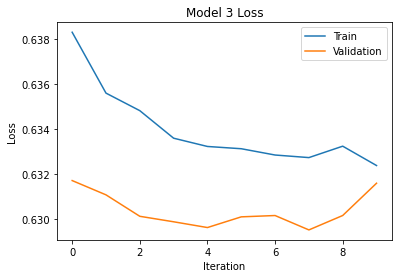

In [122]:
plt.plot(best_model.history['loss'])
plt.plot(best_model.history['val_loss'])
plt.title('Model 3 Loss')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

58/58 [==============================] - 0s 1ms/step


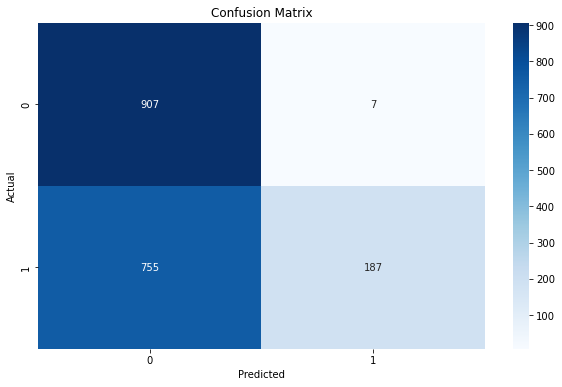

Values
Metrics                                        
Accuracy                               0.589440
Error rate                             0.410560
Sensitivity/Recall/True Positive Rate  0.198514
False Negative Rate                    0.801486
Specificity/True Negative Rate         0.992341
F1 score                               0.330844

In [123]:
cutoff = 0.5
y_pred = modeln.predict(X_test)
y_pred_1 = (y_pred > cutoff).astype('int64')
Confusion_Matrix(y_test,y_pred_1.reshape(-1))

In [124]:
%time
modeln_1 = Sequential()
modeln_1.add(Dense(20, input_shape=(X_train.shape[1],), activation='sigmoid')) # layer 1
modeln_1.add(Dense(10, activation='tanh'))  # layer 2
modeln_1.add(Dense(1, activation='sigmoid'))  # layer 3

# Compile the model
modeln_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
NeuralNet3 = modeln_1.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=1)

CPU times: total: 0 ns
Wall time: 0 ns
Epoch 1/20
186/186 [==============================] - 1s 3ms/step - loss: 0.5949 - accuracy: 0.7048 - val_loss: 0.5720 - val_accuracy: 0.7030
Epoch 2/20
186/186 [==============================] - 0s 3ms/step - loss: 0.5592 - accuracy: 0.7185 - val_loss: 0.5744 - val_accuracy: 0.6835
Epoch 3/20
186/186 [==============================] - 0s 2ms/step - loss: 0.5594 - accuracy: 0.7181 - val_loss: 0.5677 - val_accuracy: 0.7030
Epoch 4/20
186/186 [==============================] - 1s 3ms/step - loss: 0.5569 - accuracy: 0.7196 - val_loss: 0.5688 - val_accuracy: 0.7030
Epoch 5/20
186/186 [==============================] - 0s 3ms/step - loss: 0.5593 - accuracy: 0.7196 - val_loss: 0.5734 - val_accuracy: 0.7030
Epoch 6/20
186/186 [==============================] - 0s 2ms/step - loss: 0.5563 - accuracy: 0.7196 - val_loss: 0.5631 - val_accuracy: 0.7030
Epoch 7/20
186/186 [==============================] - 0s 3ms/step - loss: 0.5532 - accuracy: 0.7198 - val_los

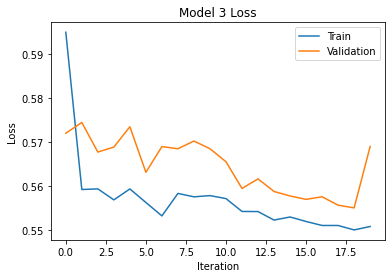

In [125]:
plt.plot(NeuralNet3.history['loss'])
plt.plot(NeuralNet3.history['val_loss'])
plt.title('Model 3 Loss')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

58/58 [==============================] - 0s 1ms/step


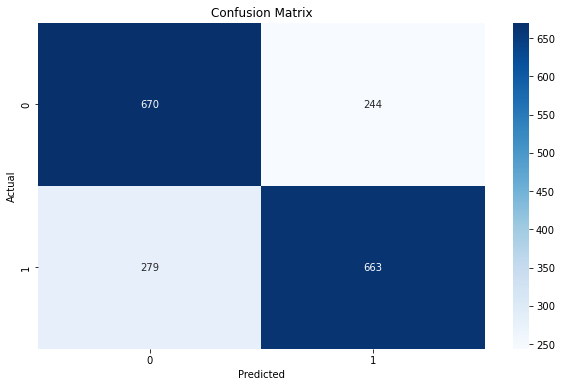

Values
Metrics                                        
Accuracy                               0.718211
Error rate                             0.281789
Sensitivity/Recall/True Positive Rate  0.703822
False Negative Rate                    0.296178
Specificity/True Negative Rate         0.733042
F1 score                               0.718135

In [126]:
cutoff = 0.5
y_pred = modeln_1.predict(X_test)
y_pred_1 = (y_pred > cutoff).astype('int64')
#y_pred_1.shape
Confusion_Matrix(y_test,y_pred_1.reshape(-1))

In [127]:
class datagen:

    def __init__(self,X_train, y_train, X_dev,y_dev,sample_size = 32):
        self.X_train = X_train.to_numpy()
        self.y_train = y_train.to_numpy()
        self.X_dev = X_dev.to_numpy()
        self.y_dev = y_dev.to_numpy()
        self.sample_size = sample_size


    def trainingSample(self):
        while True:
            idxs = np.random.choice(np.arange((self.X_train.shape[0])),self.sample_size)

            X = self.X_train[idxs]
            y = self.y_train[idxs]

            yield X,y

    def devSample(self):
        while True:
            idxs = np.random.choice(np.arange(self.X_dev.shape[0]),self.sample_size)

            X = self.X_dev[idxs]
            y = self.y_dev[idxs]

            yield X,y

In [128]:
datagen_ = datagen(X_train,y_train,X_test,y_test)
X, y = next(iter(datagen_.devSample()))
early_stopping = EarlyStopping(patience=89, monitor='val_loss', restore_best_weights=True)


In [129]:
%time
knt = modeln.fit(
    datagen_.trainingSample(),
    validation_data=datagen_.devSample(),
    epochs=250,
    steps_per_epoch=len(datagen_.X_train) // datagen_.sample_size,
    validation_steps=len(datagen_.X_dev) // datagen_.sample_size,
    callbacks=[early_stopping]
)

CPU times: total: 0 ns
Wall time: 0 ns
Epoch 1/250
232/232 [==============================] - 1s 4ms/step - loss: 0.6335 - accuracy: 0.5971 - auc: 0.5960 - recall: 0.2075 - precision: 0.9437 - val_loss: 0.6393 - val_accuracy: 0.5738 - val_auc: 0.5896 - val_recall: 0.1848 - val_precision: 0.9674
Epoch 2/250
232/232 [==============================] - 0s 2ms/step - loss: 0.6336 - accuracy: 0.5981 - auc: 0.5960 - recall: 0.2095 - precision: 0.9373 - val_loss: 0.6383 - val_accuracy: 0.5744 - val_auc: 0.5921 - val_recall: 0.1884 - val_precision: 0.9681
Epoch 3/250
232/232 [==============================] - 1s 2ms/step - loss: 0.6296 - accuracy: 0.6005 - auc: 0.6007 - recall: 0.2206 - precision: 0.9495 - val_loss: 0.6385 - val_accuracy: 0.5824 - val_auc: 0.5920 - val_recall: 0.1890 - val_precision: 0.9624
Epoch 4/250
232/232 [==============================] - 1s 2ms/step - loss: 0.6399 - accuracy: 0.5936 - auc: 0.5902 - recall: 0.2004 - precision: 0.9251 - val_loss: 0.6305 - val_accuracy: 0.5

Epoch 33/250
232/232 [==============================] - 1s 3ms/step - loss: 0.6353 - accuracy: 0.5932 - auc: 0.5915 - recall: 0.2100 - precision: 0.9348 - val_loss: 0.6386 - val_accuracy: 0.5814 - val_auc: 0.5931 - val_recall: 0.1971 - val_precision: 0.9447
Epoch 34/250
232/232 [==============================] - 1s 2ms/step - loss: 0.6343 - accuracy: 0.5938 - auc: 0.6008 - recall: 0.2092 - precision: 0.9412 - val_loss: 0.6358 - val_accuracy: 0.5911 - val_auc: 0.5969 - val_recall: 0.2021 - val_precision: 0.9548
Epoch 35/250
232/232 [==============================] - 1s 3ms/step - loss: 0.6342 - accuracy: 0.5946 - auc: 0.6046 - recall: 0.2087 - precision: 0.9375 - val_loss: 0.6431 - val_accuracy: 0.5657 - val_auc: 0.5938 - val_recall: 0.1976 - val_precision: 0.9515
Epoch 36/250
232/232 [==============================] - 1s 3ms/step - loss: 0.6357 - accuracy: 0.5998 - auc: 0.5931 - recall: 0.2035 - precision: 0.9348 - val_loss: 0.6435 - val_accuracy: 0.5862 - val_auc: 0.5845 - val_recall:

Epoch 65/250
232/232 [==============================] - 0s 2ms/step - loss: 0.6317 - accuracy: 0.6008 - auc: 0.5959 - recall: 0.2111 - precision: 0.9455 - val_loss: 0.6351 - val_accuracy: 0.5878 - val_auc: 0.5979 - val_recall: 0.2050 - val_precision: 0.9559
Epoch 66/250
232/232 [==============================] - 0s 2ms/step - loss: 0.6365 - accuracy: 0.5931 - auc: 0.5925 - recall: 0.2015 - precision: 0.9387 - val_loss: 0.6343 - val_accuracy: 0.5981 - val_auc: 0.5996 - val_recall: 0.2080 - val_precision: 0.9461
Epoch 67/250
232/232 [==============================] - 0s 2ms/step - loss: 0.6325 - accuracy: 0.5898 - auc: 0.5960 - recall: 0.2079 - precision: 0.9483 - val_loss: 0.6314 - val_accuracy: 0.5819 - val_auc: 0.6004 - val_recall: 0.2029 - val_precision: 0.9703
Epoch 68/250
232/232 [==============================] - 0s 2ms/step - loss: 0.6330 - accuracy: 0.6032 - auc: 0.6024 - recall: 0.2045 - precision: 0.9395 - val_loss: 0.6305 - val_accuracy: 0.5792 - val_auc: 0.5982 - val_recall:

Epoch 97/250
232/232 [==============================] - 1s 2ms/step - loss: 0.6305 - accuracy: 0.6079 - auc: 0.5933 - recall: 0.2156 - precision: 0.9425 - val_loss: 0.6406 - val_accuracy: 0.5770 - val_auc: 0.5914 - val_recall: 0.1889 - val_precision: 0.9577
Epoch 98/250
232/232 [==============================] - 1s 2ms/step - loss: 0.6333 - accuracy: 0.6004 - auc: 0.6031 - recall: 0.2158 - precision: 0.9347 - val_loss: 0.6370 - val_accuracy: 0.5717 - val_auc: 0.5934 - val_recall: 0.1933 - val_precision: 0.9692
Epoch 99/250
232/232 [==============================] - 1s 2ms/step - loss: 0.6368 - accuracy: 0.5987 - auc: 0.5925 - recall: 0.2005 - precision: 0.9387 - val_loss: 0.6438 - val_accuracy: 0.5781 - val_auc: 0.5839 - val_recall: 0.1764 - val_precision: 0.9540
Epoch 100/250
232/232 [==============================] - 0s 2ms/step - loss: 0.6278 - accuracy: 0.6053 - auc: 0.6007 - recall: 0.2193 - precision: 0.9496 - val_loss: 0.6418 - val_accuracy: 0.5803 - val_auc: 0.5920 - val_recall

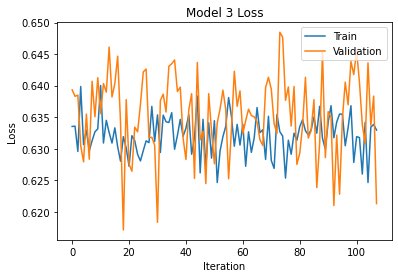

In [130]:
plt.plot(knt.history['loss'])
plt.plot(knt.history['val_loss'])
plt.title('Model 3 Loss')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

58/58 [==============================] - 0s 2ms/step


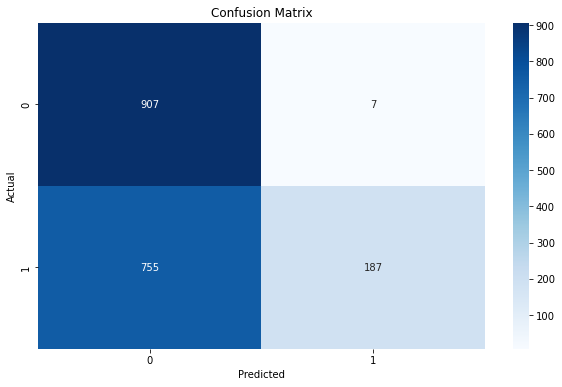

Values
Metrics                                        
Accuracy                               0.589440
Error rate                             0.410560
Sensitivity/Recall/True Positive Rate  0.198514
False Negative Rate                    0.801486
Specificity/True Negative Rate         0.992341
F1 score                               0.330844

In [131]:
cutoff = 0.5
y_pred = modeln.predict(X_test)
y_pred_1 = (y_pred > cutoff).astype('int64')
#y_pred_1.shape
Confusion_Matrix(y_test,y_pred_1.reshape(-1))

In [132]:
def roc_auc(model, X_test, y_test):
    
    RocCurveDisplay.from_estimator(estimator = model, X = X_test, y = y_test)
    
    try:
        auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    except Exception as e:
        auc = None
        print(e)

In [133]:
#roc_auc(log_afterPCA, X_test, y_test)

# ChiSQ Test

Text(0, 0.5, 'P-value')

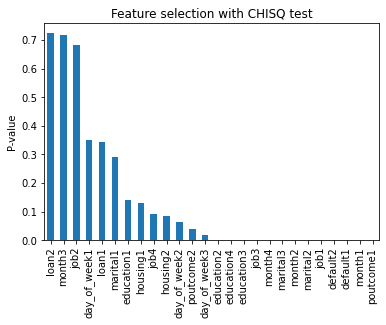

In [134]:
from sklearn.feature_selection import chi2
X = df_cat_encoded
y = df['y']
chi_scores = chi2(X,y)

p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)

p_values.plot.bar()
plt.title("Feature selection with CHISQ test")
plt.ylabel("P-value")

In [135]:
imp_col = p_values[p_values <= 0.05].index
list(imp_col)

['poutcome2',
 'day_of_week3',
 'education2',
 'education4',
 'education3',
 'job3',
 'month4',
 'marital3',
 'month2',
 'marital2',
 'job1',
 'default2',
 'default1',
 'month1',
 'poutcome1']

In [136]:
df_cat_encoded_1 = df_cat_encoded[list(imp_col)]

In [137]:
df_beforePCA = pd.concat([df_cat_encoded_1,df_num],axis = 1)
df_beforePCA.shape

(41188, 25)

In [138]:
df_afterPCA = pd.concat([df_cat_encoded_1,d,df_num],axis= 1)

In [139]:
df_afterPCA = df_afterPCA.drop('emp.var.rate',axis = 1)
df_afterPCA.shape

(41188, 25)

## Logistic Regression

In [140]:
X = df_beforePCA.drop('y',axis =1)
y = df_beforePCA['y']
X_Ptrain, X_Ptest, y_Ptrain, y_Ptest = train_test_split(X,y,test_size=0.3,random_state=24,stratify=y)
X_Ptrain.shape, X_Ptest.shape, y_Ptrain.shape, y_Ptest.shape

((28831, 24), (12357, 24), (28831,), (12357,))

CPU times: total: 0 ns
Wall time: 0 ns


  0%|                                                                                          | 0/999 [00:00<?, ?it/s]C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\4144562977.py:30: RuntimeWarning:

overflow encountered in exp

C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\4144562977.py:43: RuntimeWarning:

divide by zero encountered in log

C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\4144562977.py:43: RuntimeWarning:

invalid value encountered in matmul

100%|███████████████████████████████████████████████████████████████████████████████| 999/999 [00:07<00:00, 126.54it/s]


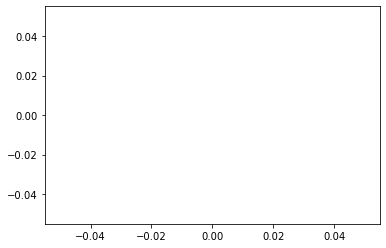

Gradient descent used
[ 2.43111767e-01 -7.86173233e-01 -4.05029127e-01  1.18565101e+00
  1.24172575e+00  1.76044872e+00  1.58503894e+00 -1.43288313e+00
 -2.00844225e+00  1.07185003e+00  2.02189406e+00  1.10564501e+00
  3.58611713e+00 -3.34513537e+00  4.35130000e+00  3.86827015e+00
  2.82349580e+01 -1.56530505e+01 -2.74953879e+03  6.58372986e+00
 -3.87264908e+01  1.56752254e+01  7.94434232e+00 -4.25847828e+01
 -7.84691648e+02] 

Training metrics


C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\4144562977.py:30: RuntimeWarning:

overflow encountered in exp



Values
Metrics                                        
Accuracy                               0.887343
Error rate                             0.112657
Sensitivity/Recall/True Positive Rate  0.000000
False Negative Rate                    1.000000
Specificity/True Negative Rate         1.000000
F1 score                               0.000000

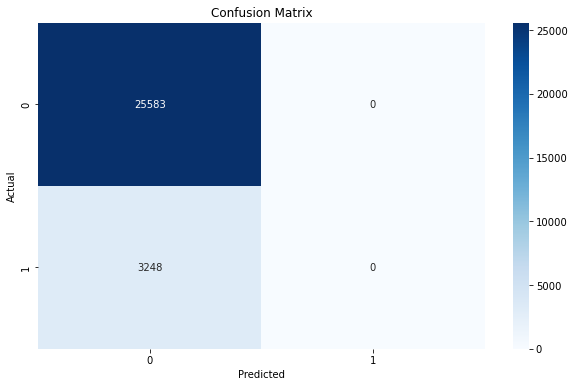

In [141]:
%time
log_beforePCA = LogisticRegressionClass(data = X_Ptrain,target = y_Ptrain,learning_rate = 1e-5, epsilon = 1e-5, max_iterations= 1000)
log_beforePCA.fit()

Testing metrics


C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\4144562977.py:30: RuntimeWarning:

overflow encountered in exp



Values
Metrics                                        
Accuracy                               0.887351
Error rate                             0.112649
Sensitivity/Recall/True Positive Rate  0.000000
False Negative Rate                    1.000000
Specificity/True Negative Rate         1.000000
F1 score                               0.000000

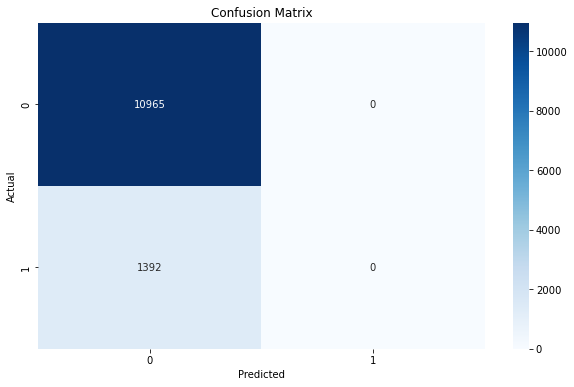

In [142]:
log_beforePCA.evaluation_metrics(X_Ptest,y_Ptest,mode = 'test')

In [143]:
X = df_afterPCA.drop('y',axis =1)
y = df_afterPCA['y']
X_Ptrain, X_Ptest, y_Ptrain, y_Ptest = train_test_split(X,y,test_size=0.3,random_state=24,stratify=y)
X_Ptrain.shape, X_Ptest.shape, y_Ptrain.shape, y_Ptest.shape

((28831, 24), (12357, 24), (28831,), (12357,))

CPU times: total: 0 ns
Wall time: 0 ns


  0%|                                                                                          | 0/999 [00:00<?, ?it/s]C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\4144562977.py:30: RuntimeWarning:

overflow encountered in exp

C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\4144562977.py:43: RuntimeWarning:

divide by zero encountered in log

C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\4144562977.py:43: RuntimeWarning:

invalid value encountered in matmul

100%|███████████████████████████████████████████████████████████████████████████████| 999/999 [00:07<00:00, 127.51it/s]


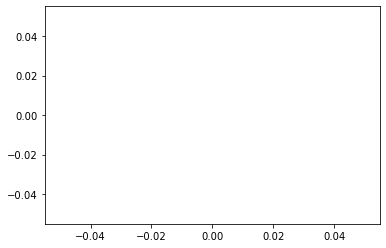

Gradient descent used
[ 4.22551822e-01 -4.54824834e-01 -3.08161735e-01  1.29497500e+00
  1.35776120e+00  1.84762809e+00  1.64272992e+00 -1.49347438e+00
 -1.81470818e+00  1.18723464e+00  2.03308000e+00  1.09932500e+00
  3.61588682e+00 -3.19534500e+00  4.19034027e+00  3.67303356e+00
  1.37461279e+03  3.54568145e+01 -1.45293098e+01 -2.52256151e+03
  6.29877258e+00  3.29257212e+01  1.72716673e+00 -3.95251547e+01
  2.49243699e+02] 

Training metrics


C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\4144562977.py:30: RuntimeWarning:

overflow encountered in exp



Values
Metrics                                        
Accuracy                               0.897541
Error rate                             0.102459
Sensitivity/Recall/True Positive Rate  0.205665
False Negative Rate                    0.794335
Specificity/True Negative Rate         0.985381
F1 score                               0.340303

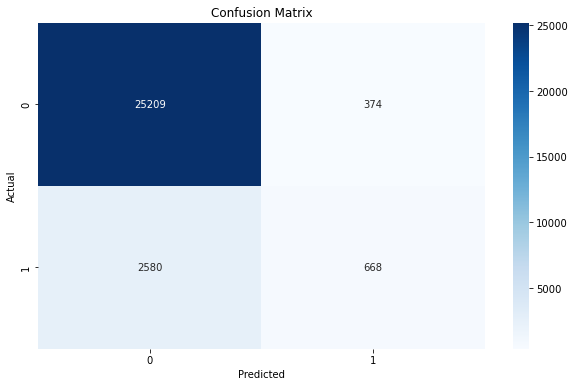

In [144]:
%time
log_afterPCA = LogisticRegressionClass(data = X_Ptrain,target = y_Ptrain,learning_rate = 1e-5, epsilon = 1e-5, max_iterations= 1000)
log_afterPCA.fit()

C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\4144562977.py:30: RuntimeWarning:

overflow encountered in exp



Testing metrics


Values
Metrics                                        
Accuracy                               0.897467
Error rate                             0.102533
Sensitivity/Recall/True Positive Rate  0.214799
False Negative Rate                    0.785201
Specificity/True Negative Rate         0.984131
F1 score                               0.352632

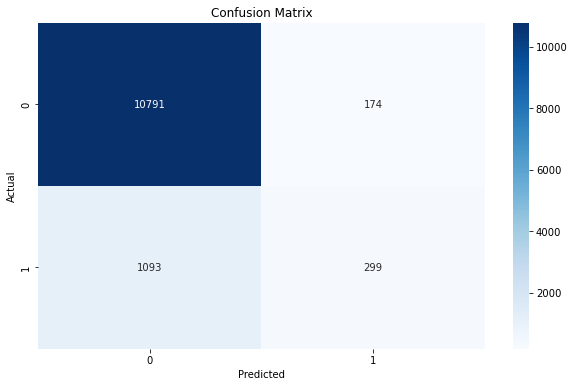

In [145]:
log_afterPCA.evaluation_metrics(X_Ptest,y_Ptest,mode = 'test')

## SVM

In [190]:
%time
X_train, X_test, y_train, y_test = train_test_split(x_rus, y_rus, test_size=0.95, random_state=42, stratify = y_rus)
SVM_RUS_beforePCA = SoftMarginSVM(c=0.01)
SVM_RUS_beforePCA.fit(X_train,y_train)

CPU times: total: 0 ns
Wall time: 0 ns


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]C:\Users\DELL\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:19<00:00, 63.84s/it]

(464,)
(464, 33)
[ 2.20236326e-02  2.06770899e-02  9.63571465e-03  1.63385931e-03
 -9.99999988e-03 -8.74143369e-03 -3.68029036e-03  0.00000000e+00
 -9.69479867e-05 -1.16950331e-02  1.33813755e-02 -1.43070098e-02
  1.37723607e-02 -1.28887207e-03  3.90124112e-03  5.83480969e-03
 -3.22244063e-03  1.06133493e-01  2.32135915e-02  1.23053413e-01
 -1.95663120e-01 -2.06712096e-02 -6.84089836e-03 -9.26419691e-03
 -5.07193628e-02  5.94653314e-02 -2.07286904e-01  1.68914260e-02
 -1.63193191e-04 -3.26849880e-03 -5.96795116e-04 -9.44255398e-02
 -1.36571596e-02]
-0.03804862518906646


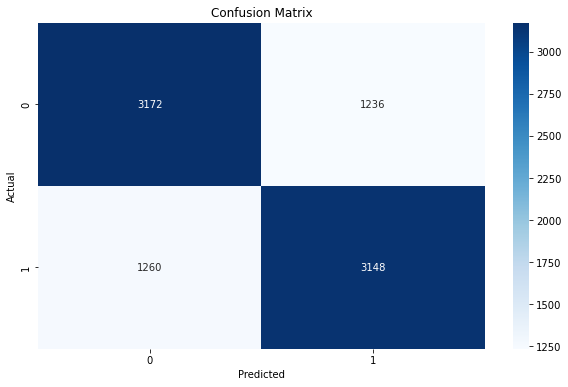

Values
Metrics                                        
Accuracy                               0.716878
Error rate                             0.283122
Sensitivity/Recall/True Positive Rate  0.714156
False Negative Rate                    0.285844
Specificity/True Negative Rate         0.719601
F1 score                               0.716868

In [191]:
y_pred = np.sign(np.add(np.matmul(X_test,SVM_RUS_beforePCA.w),SVM_RUS_beforePCA.b))
y_pred = np.where(y_pred==-1,0,1)
Confusion_Matrix(y_test,y_pred)

## QDA

In [147]:
X = df_afterPCA.drop('y',axis =1)
y = df_afterPCA['y']
X_Ptrain, X_Ptest, y_Ptrain, y_Ptest = train_test_split(X,y,test_size=0.3,random_state=24,stratify=y)
X_Ptrain.shape, X_Ptest.shape, y_Ptrain.shape, y_Ptest.shape


((28831, 24), (12357, 24), (28831,), (12357,))

In [148]:
%time
QDA = LDAQDA(X_Ptrain,y_Ptrain,method='QDA')
QDA.fit()

CPU times: total: 0 ns
Wall time: 0 ns


C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\3240372393.py:54: RuntimeWarning:

overflow encountered in exp

C:\Users\DELL\AppData\Local\Temp\ipykernel_17964\3240372393.py:54: RuntimeWarning:

overflow encountered in double_scalars



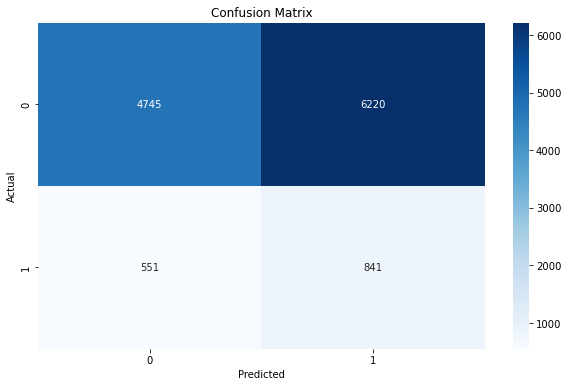

Values
Metrics                                        
Accuracy                               0.452051
Error rate                             0.547949
Sensitivity/Recall/True Positive Rate  0.604167
False Negative Rate                    0.395833
Specificity/True Negative Rate         0.432741
F1 score                               0.504283

In [149]:
y_pred = QDA.predict(X_Ptest)
Confusion_Matrix(y_Ptest,y_pred.astype('int32'))

In [192]:
X_RUS = df_afterPCA.drop('y',axis = 1)
y_RUS = df_afterPCA['y']
rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable
x_rus, y_rus = rus.fit_resample(X_RUS, y_RUS)
print('original dataset shape:', Counter(y_RUS))
print('Resample dataset shape', Counter(y_rus))

original dataset shape: Counter({0: 36548, 1: 4640})
Resample dataset shape Counter({0: 4640, 1: 4640})


In [193]:
dfn = x_rus
X = dfn
y = y_rus

# Create train-test split with 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the training and testing data
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (7424, 24)
X_test shape: (1856, 24)
y_train shape: (7424,)
y_test shape: (1856,)


In [194]:
%time
modeln = Sequential()
modeln.add(Dense(20, input_shape=(X_train.shape[1],), activation='relu')) # layer 1
modeln.add(Dense(10, activation='tanh'))  # layer 2
modeln.add(Dense(1, activation='sigmoid'))  # layer 3

# Compile the model
modeln.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'],)

# Train the model
NeuralNet = modeln.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=1)

CPU times: total: 0 ns
Wall time: 0 ns
Epoch 1/20
186/186 [==============================] - 2s 4ms/step - loss: 0.6447 - accuracy: 0.6309 - val_loss: 0.6594 - val_accuracy: 0.6007
Epoch 2/20
186/186 [==============================] - 0s 2ms/step - loss: 0.6578 - accuracy: 0.5999 - val_loss: 0.6538 - val_accuracy: 0.6007
Epoch 3/20
186/186 [==============================] - 0s 2ms/step - loss: 0.6532 - accuracy: 0.5999 - val_loss: 0.6494 - val_accuracy: 0.6007
Epoch 4/20
186/186 [==============================] - 0s 2ms/step - loss: 0.6498 - accuracy: 0.5999 - val_loss: 0.6462 - val_accuracy: 0.6007
Epoch 5/20
186/186 [==============================] - 0s 2ms/step - loss: 0.6473 - accuracy: 0.5999 - val_loss: 0.6438 - val_accuracy: 0.6007
Epoch 6/20
186/186 [==============================] - 0s 2ms/step - loss: 0.6456 - accuracy: 0.5999 - val_loss: 0.6425 - val_accuracy: 0.6007
Epoch 7/20
186/186 [==============================] - 0s 2ms/step - loss: 0.6440 - accuracy: 0.5999 - val_los

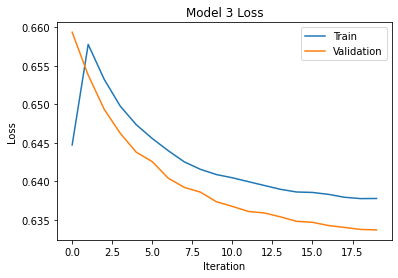

In [195]:
plt.plot(NeuralNet.history['loss'])
plt.plot(NeuralNet.history['val_loss'])
plt.title('Model 3 Loss')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

58/58 [==============================] - 0s 2ms/step


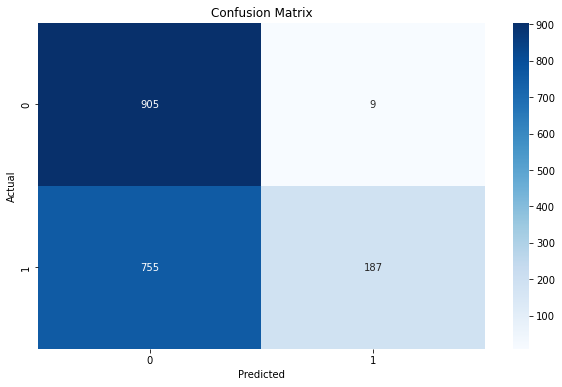

Values
Metrics                                        
Accuracy                               0.588362
Error rate                             0.411638
Sensitivity/Recall/True Positive Rate  0.198514
False Negative Rate                    0.801486
Specificity/True Negative Rate         0.990153
F1 score                               0.330722

In [197]:
cutoff = 0.5
y_pred = modeln.predict(X_test)
y_pred_1 = (y_pred > cutoff).astype('int64')
y_pred_1.shape
Confusion_Matrix(y_test,y_pred_1.reshape(-1))

In [199]:
%time
modeln = Sequential()
modeln.add(Dense(20, input_shape=(X_train.shape[1],), activation='sigmoid')) # layer 1
modeln.add(Dense(10, activation='sigmoid'))  # layer 2
modeln.add(Dense(1, activation='sigmoid'))  # layer 3

# Compile the model
modeln.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'],)

# Train the model
NeuralNet = modeln.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=1)

CPU times: total: 0 ns
Wall time: 0 ns
Epoch 1/20
186/186 [==============================] - 1s 3ms/step - loss: 0.6851 - accuracy: 0.5614 - val_loss: 0.6765 - val_accuracy: 0.5003
Epoch 2/20
186/186 [==============================] - 0s 2ms/step - loss: 0.6721 - accuracy: 0.5919 - val_loss: 0.6660 - val_accuracy: 0.6007
Epoch 3/20
186/186 [==============================] - 0s 2ms/step - loss: 0.6632 - accuracy: 0.5999 - val_loss: 0.6568 - val_accuracy: 0.6007
Epoch 4/20
186/186 [==============================] - 0s 2ms/step - loss: 0.6549 - accuracy: 0.5999 - val_loss: 0.6494 - val_accuracy: 0.6007
Epoch 5/20
186/186 [==============================] - 1s 3ms/step - loss: 0.6490 - accuracy: 0.5999 - val_loss: 0.6441 - val_accuracy: 0.6007
Epoch 6/20
186/186 [==============================] - 0s 2ms/step - loss: 0.6451 - accuracy: 0.5999 - val_loss: 0.6404 - val_accuracy: 0.6007
Epoch 7/20
186/186 [==============================] - 0s 2ms/step - loss: 0.6421 - accuracy: 0.5999 - val_los

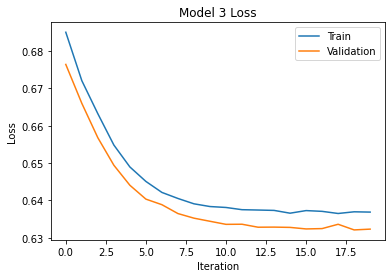

In [200]:
plt.plot(NeuralNet.history['loss'])
plt.plot(NeuralNet.history['val_loss'])
plt.title('Model 3 Loss')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

58/58 [==============================] - 0s 976us/step


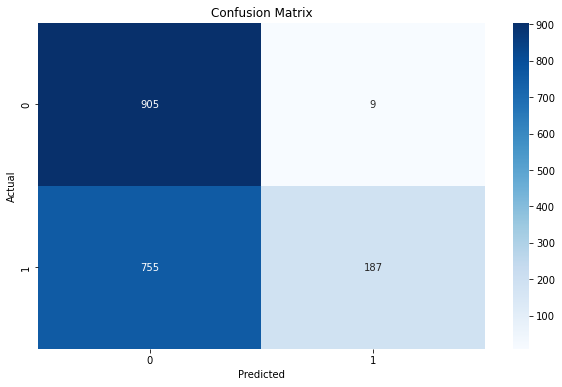

Values
Metrics                                        
Accuracy                               0.588362
Error rate                             0.411638
Sensitivity/Recall/True Positive Rate  0.198514
False Negative Rate                    0.801486
Specificity/True Negative Rate         0.990153
F1 score                               0.330722

In [201]:
cutoff = 0.5
y_pred = modeln.predict(X_test)
y_pred_1 = (y_pred > cutoff).astype('int64')
y_pred_1.shape
Confusion_Matrix(y_test,y_pred_1.reshape(-1))